<a href="https://colab.research.google.com/github/Lorddickenstein/FSLRwithNLP/blob/main/Application/Organize_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organizing the Datasets
This program will organize the dataset from the Raw_Dataset folder in Colab Notebooks/Datasets/OurDataset/Raw_Dataset and put them in Colab Notebooks/Datgasets/OurDataset/Raw_Dataset_Renamed.

# Preprocessing and Renaming the Datasets
The program will copy all the files extracting only the located hand images, extracting the hand from the background using skin segmentation,resizing the images into 224x224, and renaming the images to their class name.

In [1]:
!pip install mediapipe==0.8.8

     |████████████████████████████████| 30.1 MB 12 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import mediapipe as mp
import numpy as np
import glob
import warnings
import random
import shutil
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
class HandDetector():
    def __init__(self, mode=False, maxHands=2, detectionConf=0.5, trackingConf=0.5):
        # Arguments
        self.mode = mode
        self.maxHands = maxHands
        self.detectionConf = detectionConf
        self.trackingConf = trackingConf

        # Initialize mediapipe variables
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,
                                        self.detectionConf, self.trackingConf)
        self.mpDraw = mp.solutions.drawing_utils


    def find_hands(self, src_img, draw=False):
        # Convert frame to rgb for mediapipe
        rgb = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        rgb.flags.writeable = False
        self.results = self.hands.process(rgb)

        if self.results.multi_hand_landmarks:
            x_pts, y_pts = [], []
            for handLMs in self.results.multi_hand_landmarks:
                for id, lm in enumerate(handLMs.landmark):
                    h, w, c = src_img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    x_pts.append(cx)
                    y_pts.append(cy)
                if draw:
                    self.mpDraw.draw_landmarks(src_img, handLMs, self.mpHands.HAND_CONNECTIONS)

            # Find the max and min points
            y_max, y_min, x_max, x_min = max(y_pts), min(y_pts), max(x_pts), min(x_pts)
            extra_space = src_img.shape[0] * 0.14
            return True, (x_min - extra_space, y_max + extra_space), (x_max + extra_space, y_min - extra_space)

        return False, (), ()

## Functions
Contains all the functions that are needed for this program.

In [5]:
# Show image in matplotlib
def show_plt_image(src_img):
    plt.imshow(src_img, cmap='gray')
    plt.show()

In [6]:
# Creates a directory for every enumerable class_obj
def make_dir(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    os.makedirs(path_class)

In [7]:
# Resize the image into 224x224
def resize_image(src_img, img_size=(224, 224)):
  return cv2.resize(src_img, img_size, interpolation=cv2.INTER_CUBIC)

In [8]:
# Returns an image with morphological transformation using MORPH_CLOSE
def morph_image(src_img, method=cv2.MORPH_CLOSE, kernel=(5, 5)):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
    return cv2.morphologyEx(src_img, method, kernel)

In [9]:
# Returns a masked image showing only the skin range values in the YCrCb colorspace
def skin_segmentation(src_img):
    # YCrCb pixel upper and lower boundaries
    YCbCr_lower = np.array([0, 135, 80], np.uint8)
    YCbCr_upper = np.array([255, 180, 135], np.uint8)

    # Convert bgr to YCbCr color space
    img_YCbCr = cv2.cvtColor(src_img, cv2.COLOR_BGR2YCrCb)

    # Determine the intensities of YCbCr pixel intensities that fall inside the upper and lower boundaries
    YCrCb_mask = cv2.inRange(img_YCbCr, YCbCr_lower, YCbCr_upper)

    # Apply open morphological transformation
    YCrCb_mask = morph_image(YCrCb_mask, method=cv2.MORPH_OPEN, kernel=(5, 5))

    # Apply close morphological transformation
    YCrCb_mask = morph_image(YCrCb_mask, method=cv2.MORPH_CLOSE, kernel=(9, 9))

    # Apply Dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    YCrCb_mask = cv2.dilate(YCrCb_mask, kernel, iterations=2)

    # Blur image to lessen noise
    YCrCb_mask_blur = cv2.medianBlur(YCrCb_mask, 21)

    show_plt_image(YCrCb_mask_blur)

    # Apply mask to the frame
    return cv2.bitwise_and(src_img.copy(), src_img.copy(), mask=YCrCb_mask_blur)

In [10]:
# Counts all the images that is located in path for every enumerable class_obj
def count_items(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    # print(path_class)
    print(obj, len(os.listdir(path_class)))

## Path and Variable Configurations

In [11]:
dataset_raw = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset'
dataset_preprocessed = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Preprocessed_Raw_Dataset'

In [27]:
# Organize data into train, valid, test dirs
dataset_categories = ['Dynamic_Single', 'Dynamic_Double',
                       'Static_Single', 'Static_Double',
                       'Letters', 'Numbers']

letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O',
           'P', 'Q', 'R', 'S', 'T',
           'U', 'V', 'W', 'X', 'Y',
           'Z']

numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

static_single = ['Fine', 'Gabi', 'Good', 'Hapon', 'He-She',
                 'His-Her', 'I Love You', 'I-Me', 'Mine',
                 'Tanghali', 'Umaga', 'You', 'Your']

static_double = ['Congratulations', 'Great', 'Help', 'Meet',
                 'Name', 'Night', 'Occupation', 'Pray', 'Rest',
                 'Stand', 'Study', 'To']

dynamic_single = ['Eroplano', 'Eroplano-2', 'Invite', 'Late', 'Late-2',
                  'No', 'No-2', 'Our', 'Our-2', 'Sorry', 'That', 'Them',
                  'This', 'We', 'Welcome', 'Welcome-2', 'When', 'Who',
                  'Who_2', 'Why', 'Yes', 'Yesterday']

dynamic_double = ['Ago', 'Allow', 'Ball', 'Banana', 'Banana-2', 'Bread', 'Break',
                  'Break-2', 'Bring', 'Bring-2', 'Buy', 'Buy-2', 'Bye', 'Coconut',
                  'Coffee', 'Come', 'Come-2', 'Cook', 'From', 'From-2', 'Get', 'Get-2',
                  'Go', 'Go-2', 'Happen', 'Happen-2', 'How', 'How-2', 'Introduce', 'Introduce-2',
                  'Let', 'Let-2', 'Live', 'Make', 'Mango', 'Maybe', 'Nice', 'Now', 'Office', 'Office-2',
                  'School', 'Sit', 'Sit_2', 'Store', 'Strawberry', 'Thank You', 'Today', 'Today-2',
                  'What', 'Where', 'Which', 'Work', 'Year']

dataset_classes = [numbers, letters,
                   static_single, static_double,
                   dynamic_single, dynamic_double]

In [29]:
assert len(static_single) == 13
assert len(static_double) == 12
assert len(dynamic_single) == 22
assert len(dynamic_double) == 53

In [31]:
print(dataset_classes)

[['1', '2', '3', '4', '5', '6', '7', '8', '9'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], ['Fine', 'Gabi', 'Good', 'Hapon', 'He-She', 'His-Her', 'I Love You', 'I-Me', 'Mine', 'Tanghali', 'Umaga', 'You', 'Your'], ['Congratulations', 'Great', 'Help', 'Meet', 'Name', 'Night', 'Occupation', 'Pray', 'Rest', 'Stand', 'Study', 'To'], ['Eroplano', 'Eroplano-2', 'Invite', 'Late', 'Late-2', 'No', 'No-2', 'Our', 'Our-2', 'Sorry', 'That', 'Them', 'This', 'We', 'Welcome', 'Welcome-2', 'When', 'Who', 'Who_2', 'Why', 'Yes', 'Yesterday'], ['Ago', 'Allow', 'Ball', 'Banana', 'Banana-2', 'Bread', 'Break', 'Break-2', 'Bring', 'Bring-2', 'Buy', 'Buy-2', 'Bye', 'Coconut', 'Coffee', 'Come', 'Come-2', 'Cook', 'From', 'From-2', 'Get', 'Get-2', 'Go', 'Go-2', 'Happen', 'Happen-2', 'How', 'How-2', 'Introduce', 'Introduce-2', 'Let', 'Let-2', 'Live', 'Make', 'Mango', 'Maybe', 'Nice', 'Now', 'Office', 'Office-2', 'School', 'Sit

## Create a directory for each category in Preprocessed Folder

In [14]:
# Letters
dataset_preprocessed_letters = os.path.join(dataset_preprocessed, 'Letters')
if os.path.isdir(dataset_preprocessed_letters) is False:
  make_dir(dataset_preprocessed_letters, letters)
else:
  print('Path already exist')

Path already exist


In [15]:
# Numbers
dataset_preprocessed_numbers = os.path.join(dataset_preprocessed, 'Numbers')
if os.path.isdir(dataset_preprocessed_numbers) is False:
  make_dir(dataset_preprocessed_numbers, numbers)
else:
  print('Path already exist')

Path already exist


In [ ]:
# Static Single
dataset_preprocessed_static_single = os.path.join(dataset_preprocessed, 'Static Single')
if os.path.isdir(dataset_preprocessed_static_single) is False:
  make_dir(dataset_preprocessed_static_single, static_single)
else:
  print('Path already exist')

In [ ]:
# Static Double
dataset_preprocessed_static_double = os.path.join(dataset_preprocessed, 'Static Double')
if os.path.isdir(dataset_preprocessed_static_double) is False:
  make_dir(dataset_preprocessed_static_double, static_single)
else:
  print('Path already exist')

In [ ]:
# Dynamic Single
dataset_preprocessed_dynamic_single = os.path.join(dataset_preprocessed, 'Dynamic Single')
if os.path.isdir(dataset_preprocessed_dynamic_single) is False:
  make_dir(dataset_preprocessed_dynamic_single, static_single)
else:
  print('Path already exist')

In [ ]:
# Dynamic Double
dataset_preprocessed_dynamic_double = os.path.join(dataset_preprocessed, 'Dynamic Double')
if os.path.isdir(dataset_preprocessed_dynamic_double) is False:
  make_dir(dataset_preprocessed_dynamic_double, static_single)
else:
  print('Path already exist')

## Extract Frame from videos in the dataset
Dynamic gestures are stored in video clips. Extract those frames using

## Preprocessing Steps
1. Take the images from Raw_Dataset.
2. Crop the hands from each images.
3. Apply skin-segmentation to extract hands from background.
4. Transform images to grayscale.
5. Save the images to Preprocessed_Raw_Dataset.
6. Rename images from 0 to N number of images.

In [16]:
detector = HandDetector()

In [ ]:
# Letters
dataset_raw_letters = os.path.join(dataset_raw, 'Letters')
dataset_raw_preprocessed_letters = os.path.join(dataset_preprocessed, 'Letters')
for letter in letters:
  path_class = os.path.join(dataset_raw_letters, letter)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_letters, letter)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = letter + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1


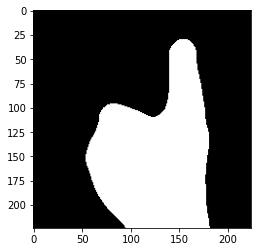

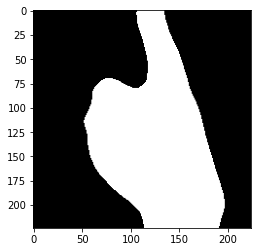

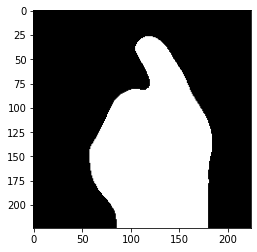

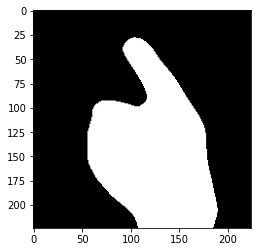

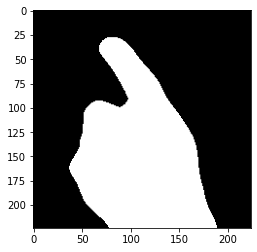

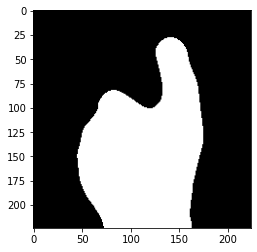

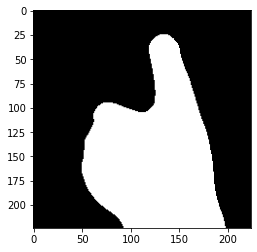

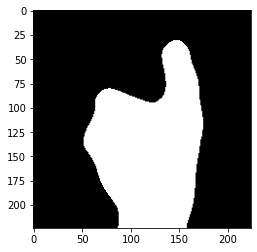

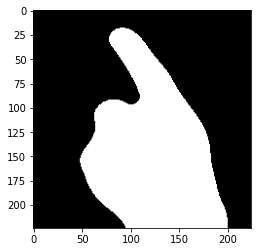

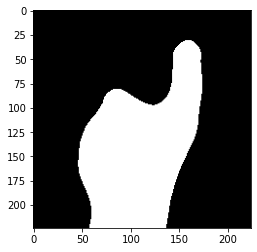

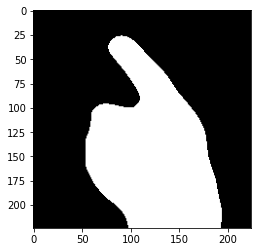

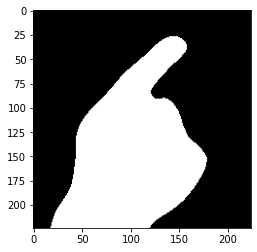

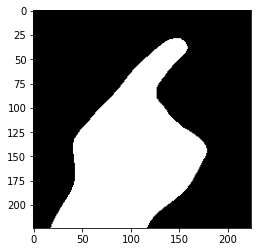

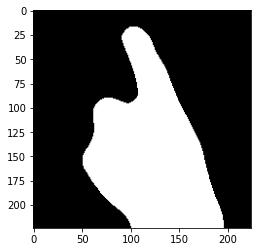

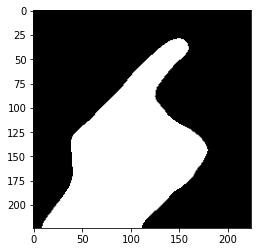

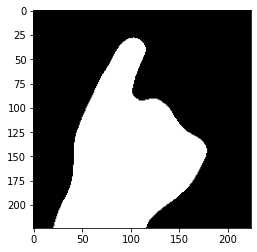

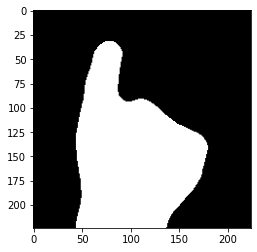

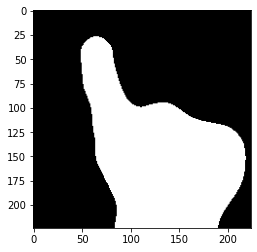

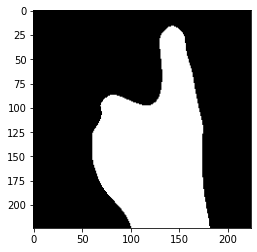

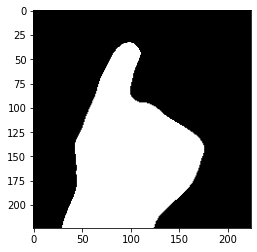

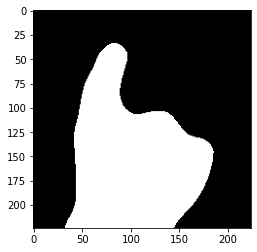

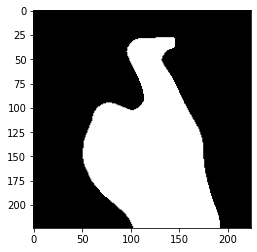

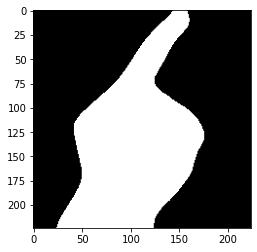

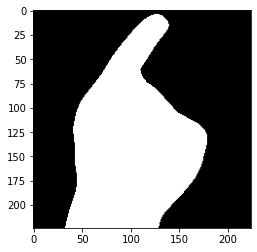

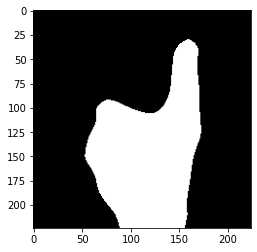

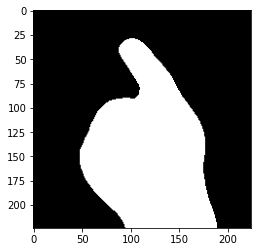

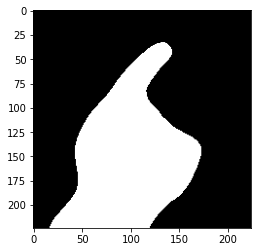

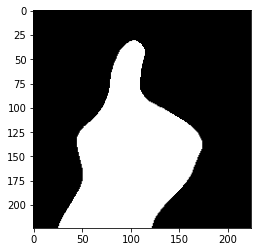

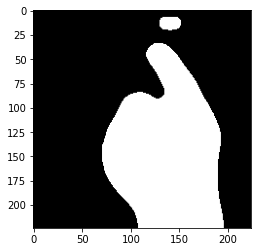

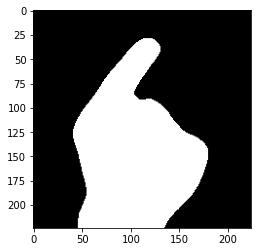

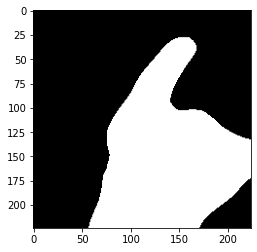

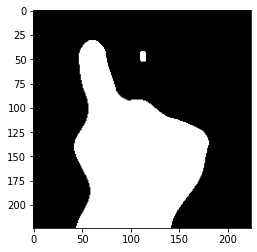

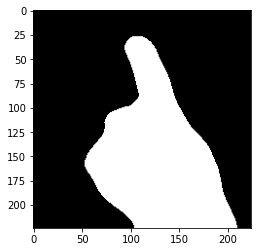

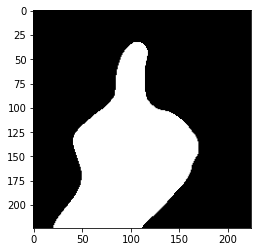

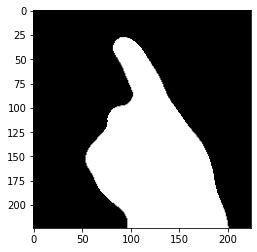

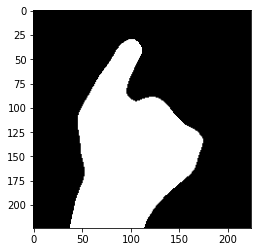

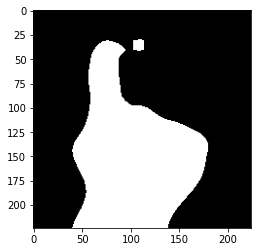

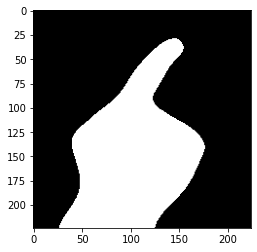

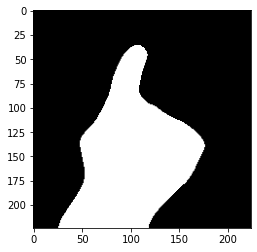

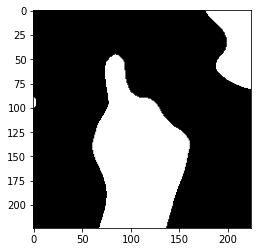

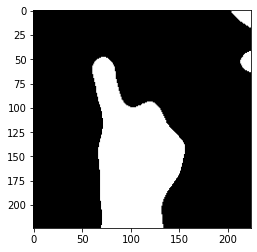

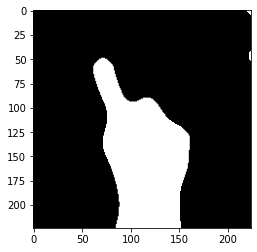

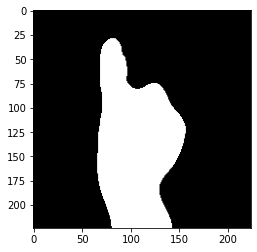

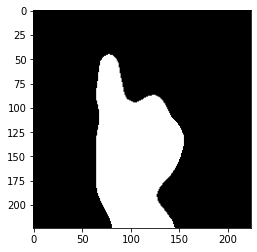

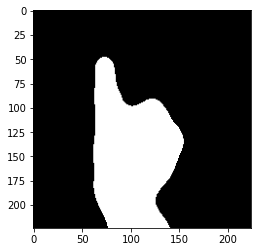

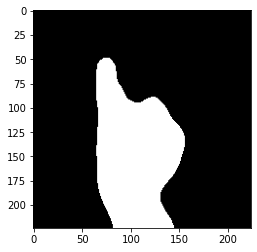

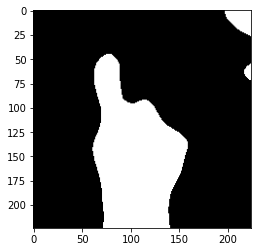

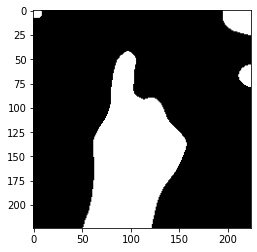

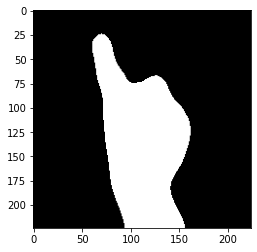

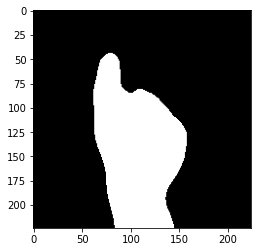

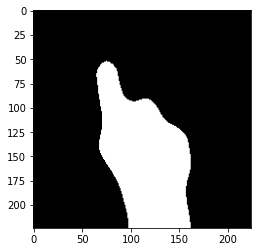

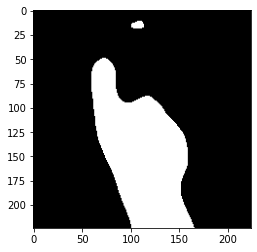

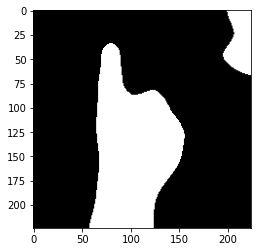

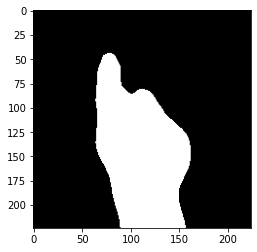

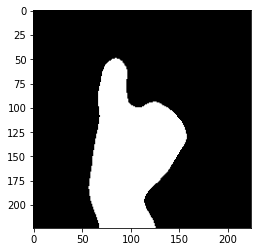

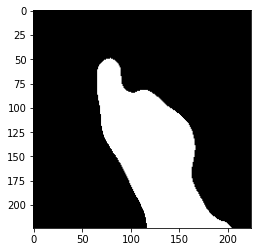

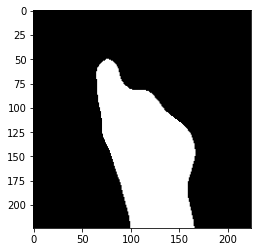

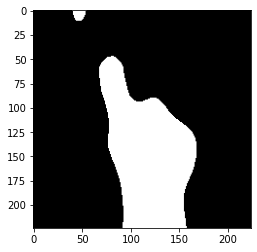

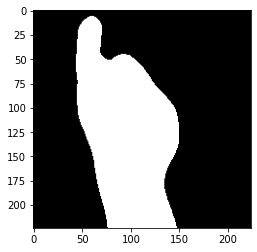

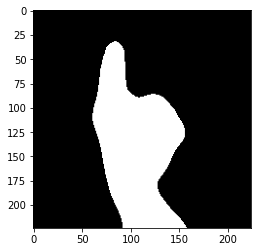

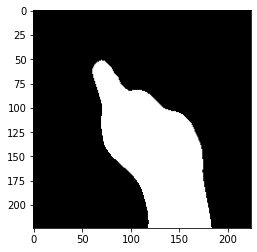

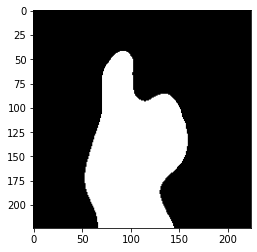

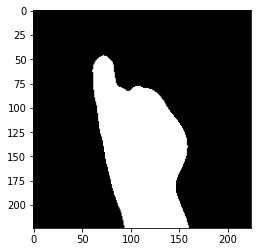

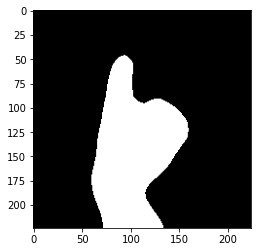

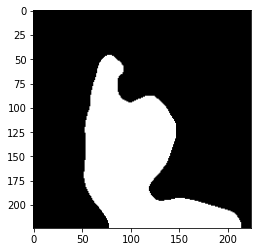

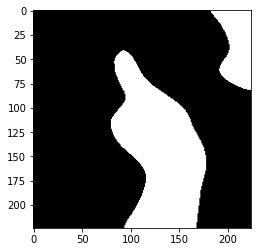

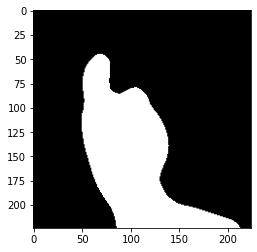

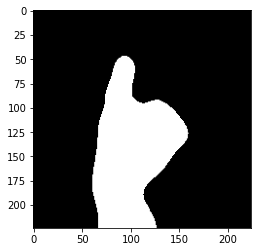

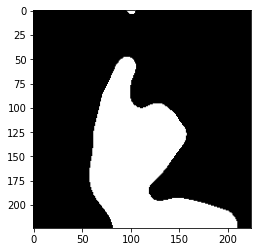

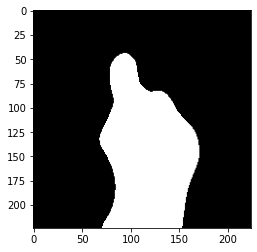

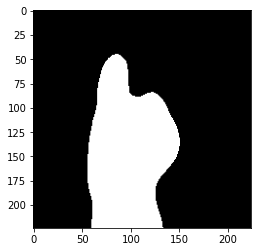

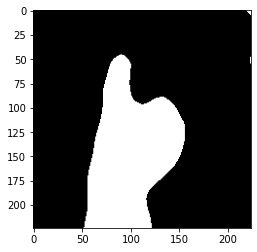

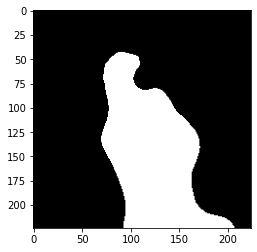

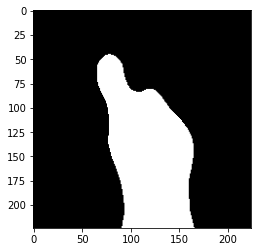

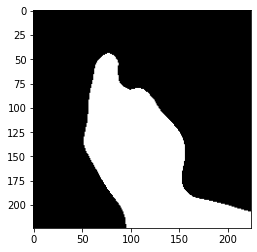

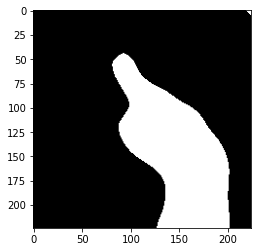

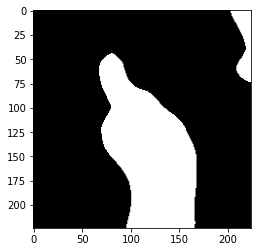

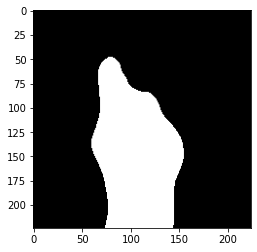

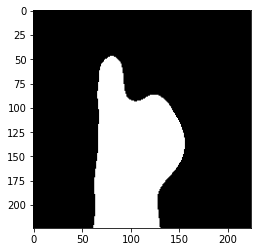

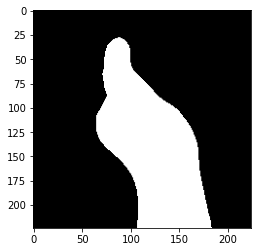

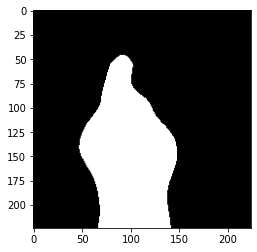

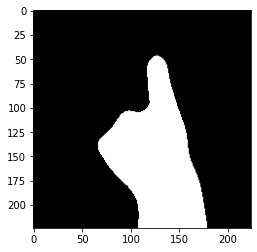

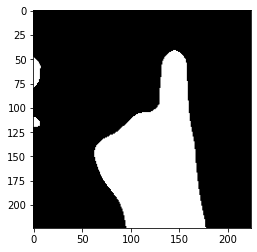

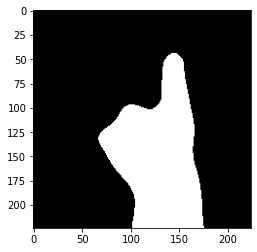

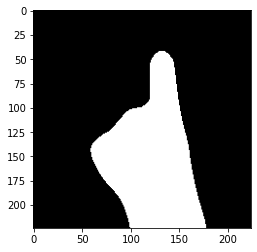

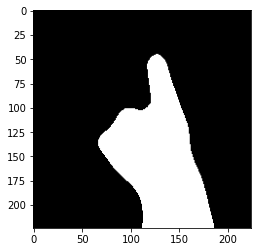

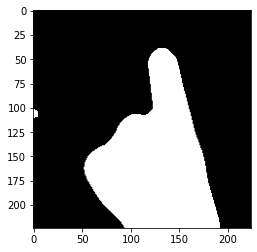

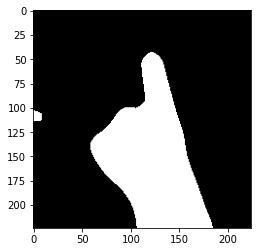

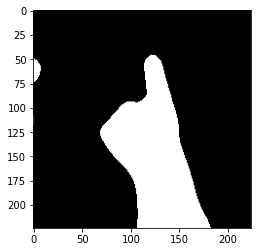

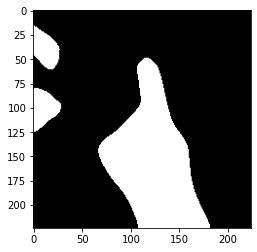

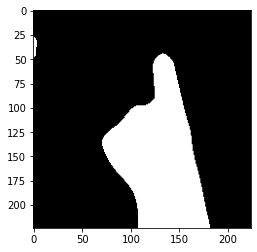

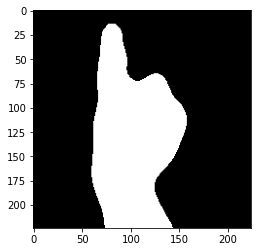

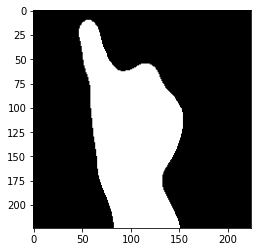

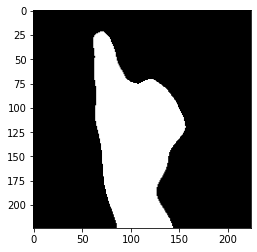

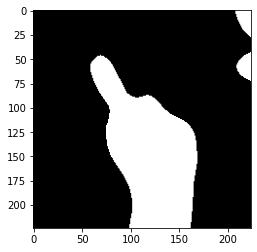

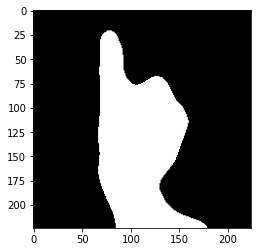

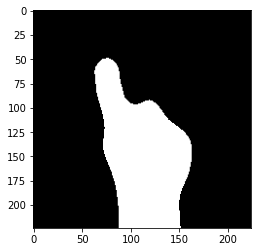

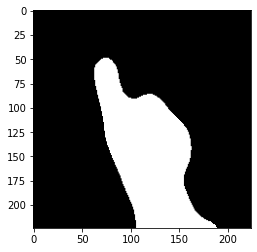

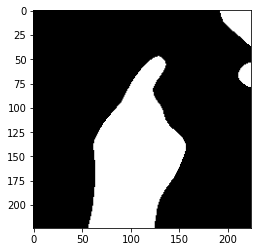

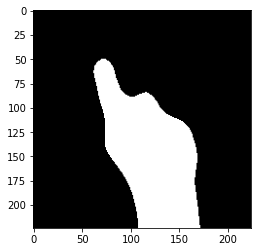

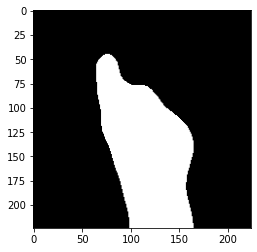

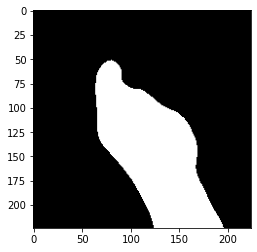

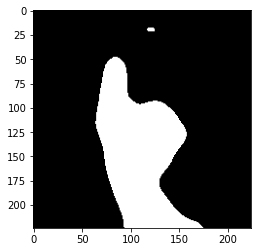

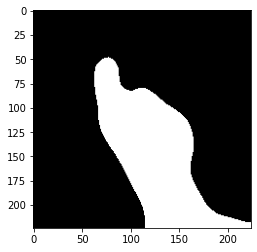

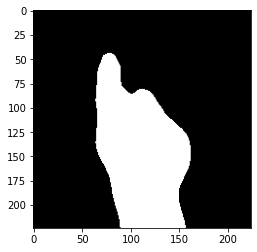

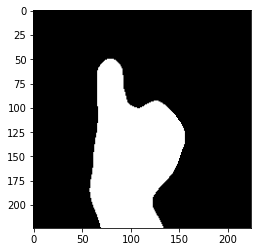

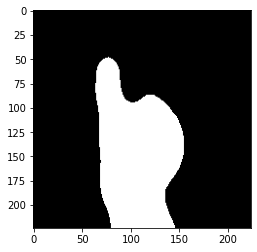

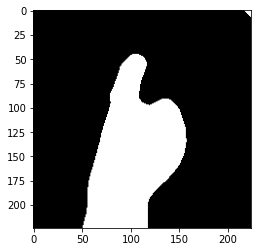

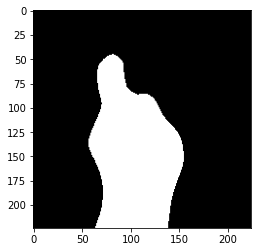

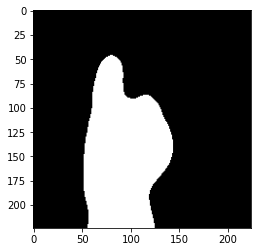

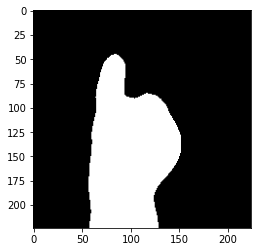

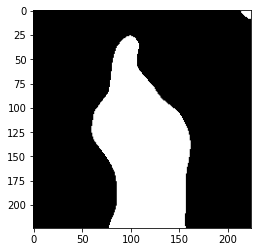

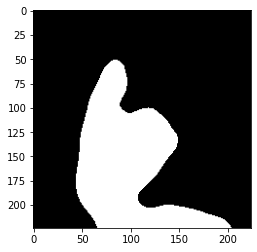

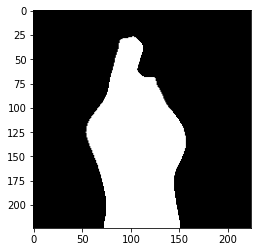

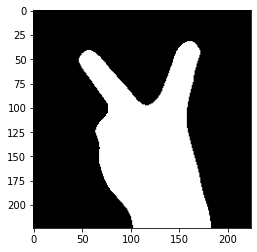

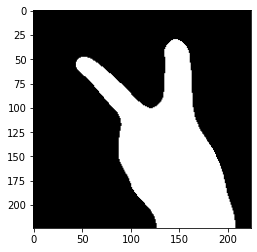

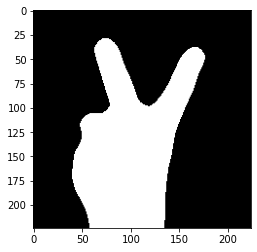

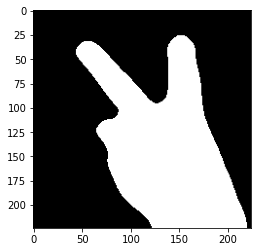

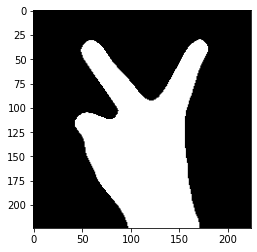

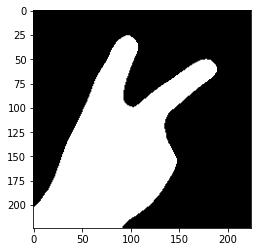

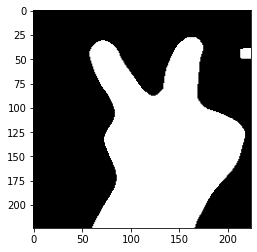

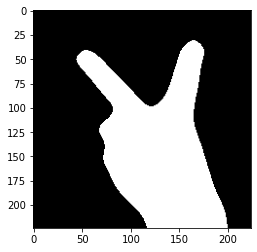

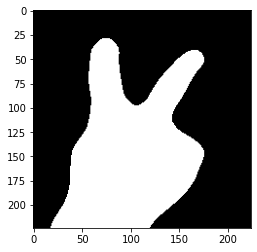

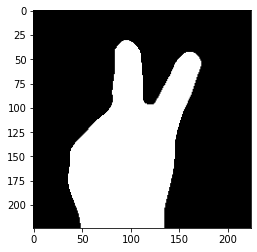

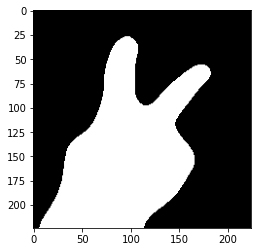

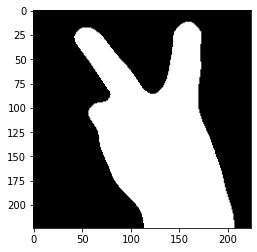

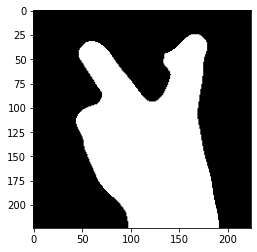

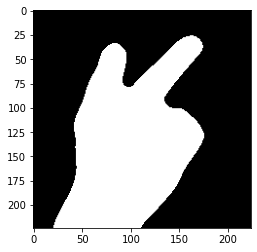

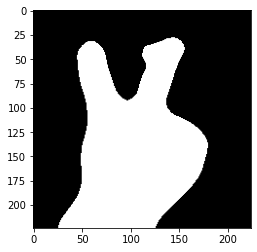

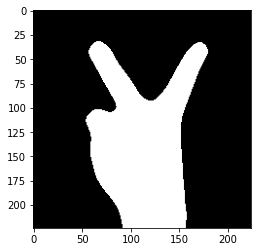

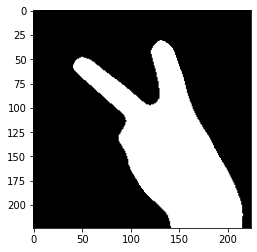

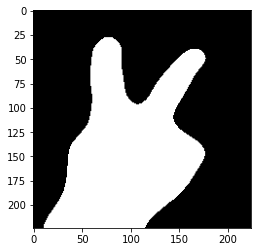

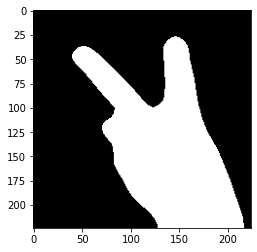

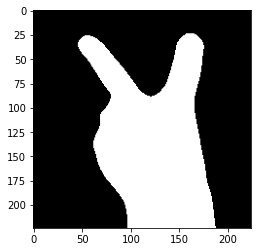

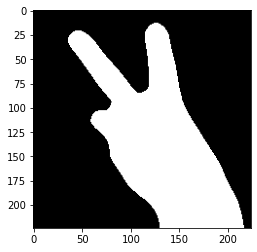

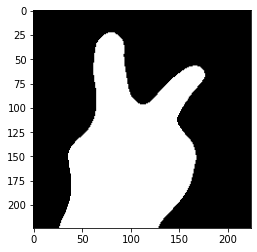

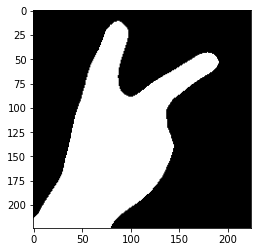

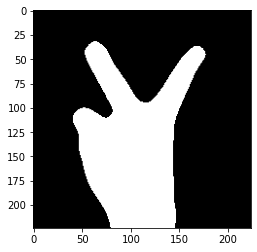

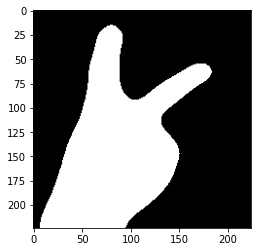

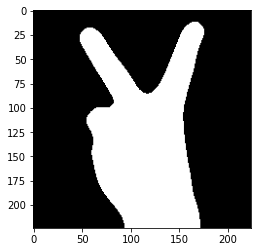

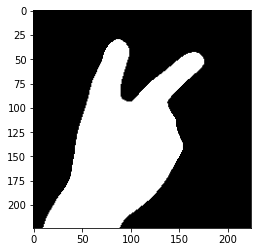

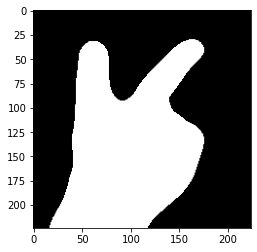

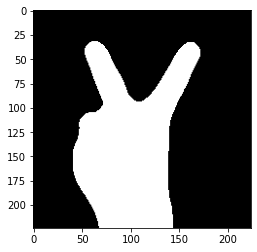

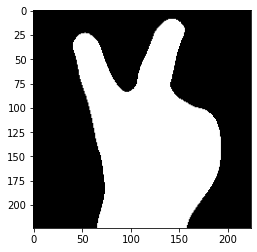

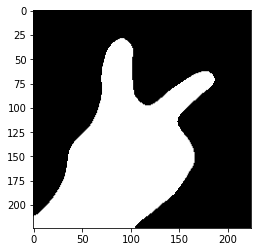

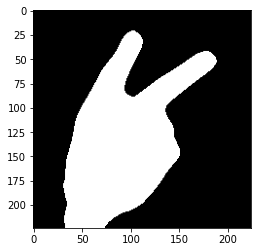

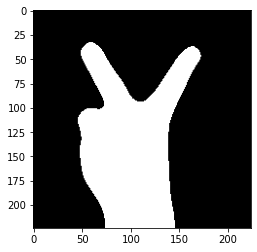

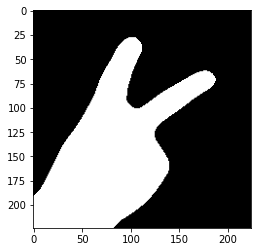

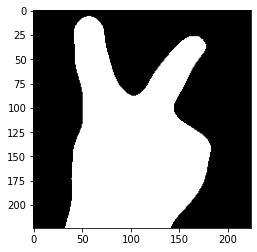

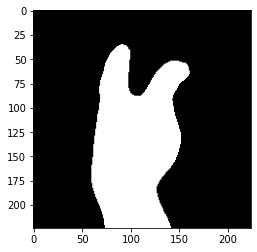

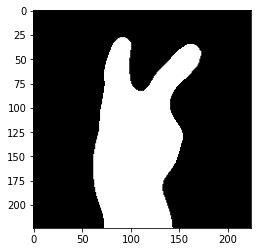

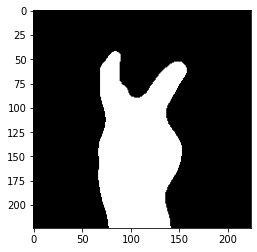

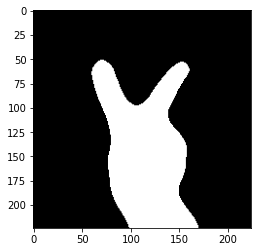

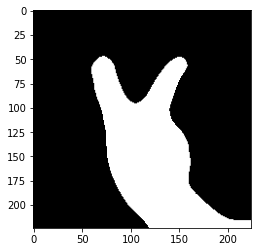

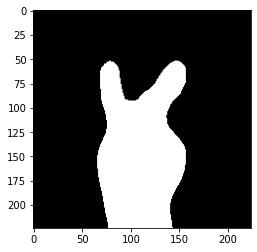

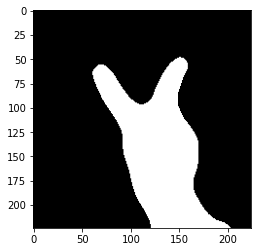

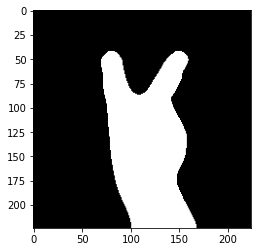

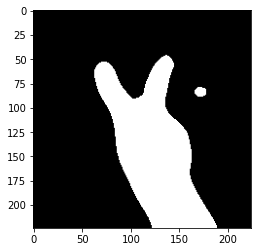

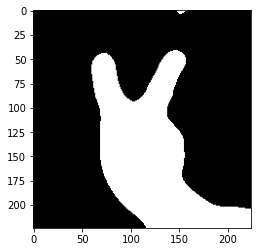

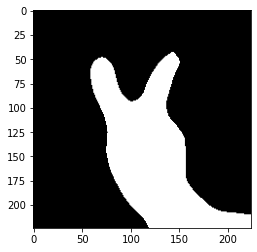

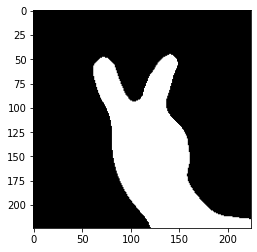

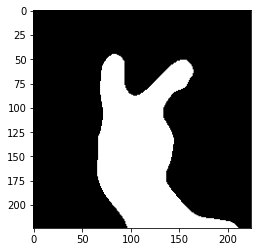

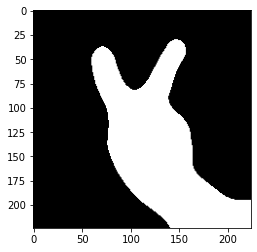

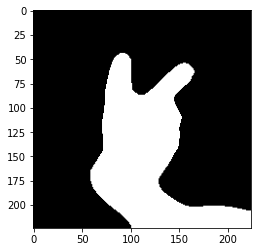

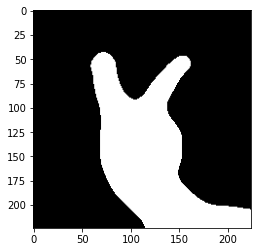

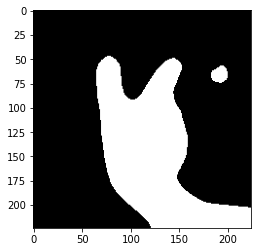

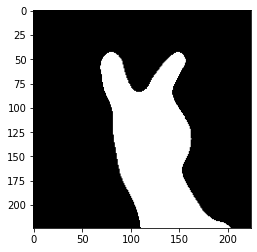

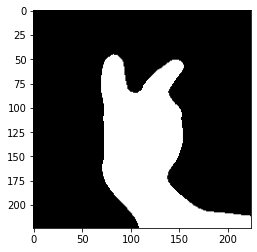

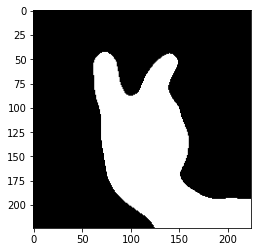

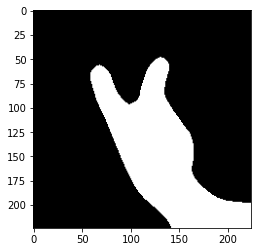

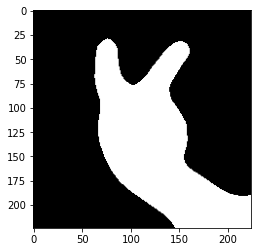

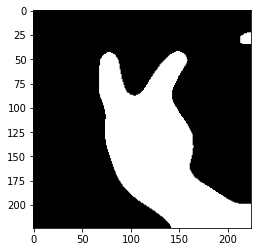

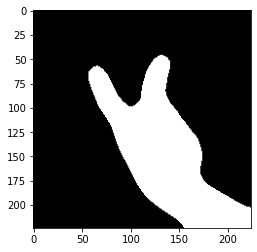

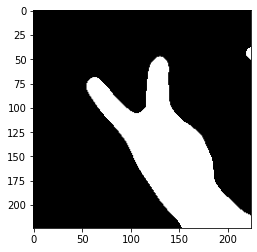

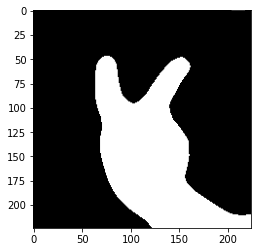

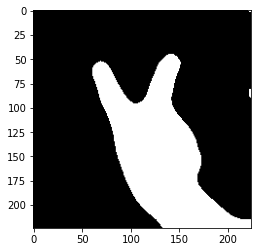

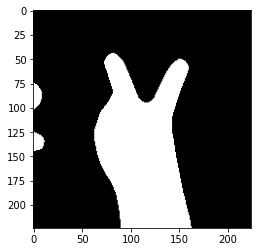

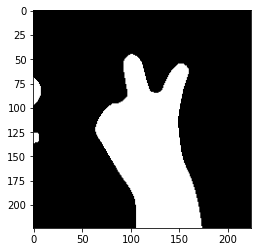

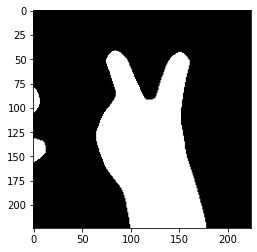

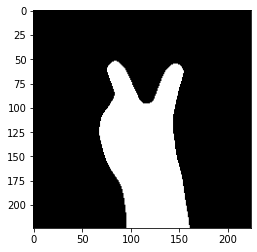

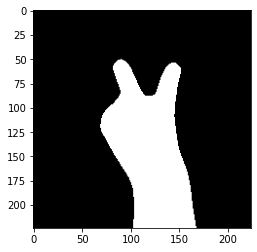

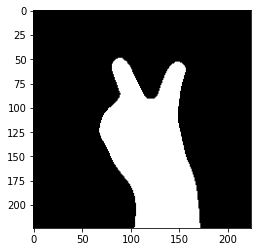

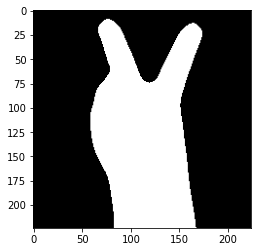

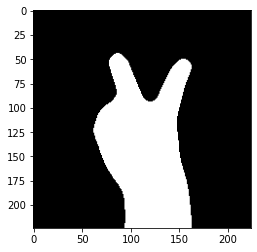

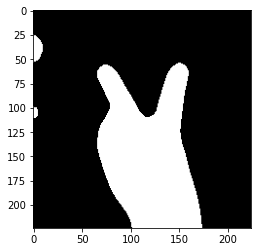

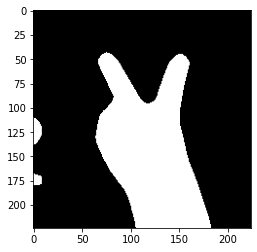

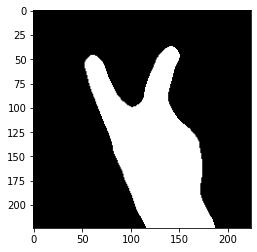

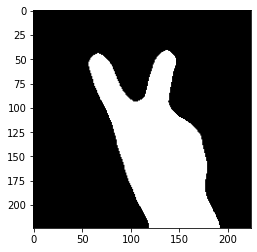

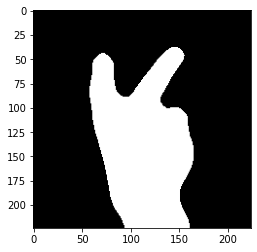

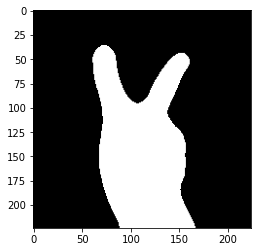

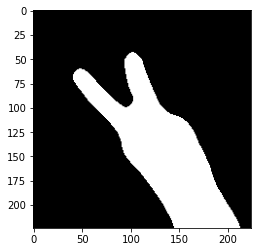

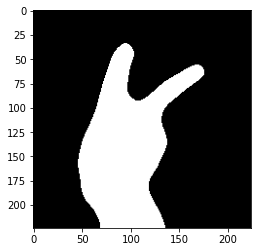

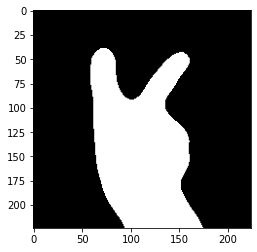

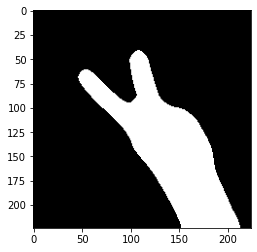

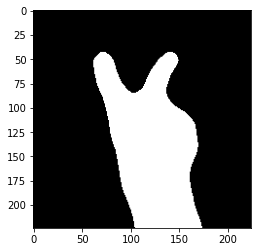

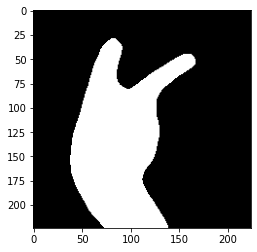

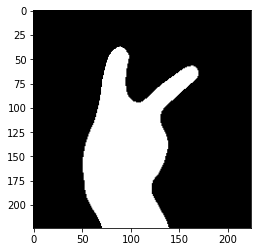

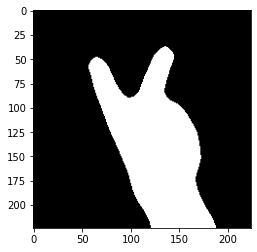

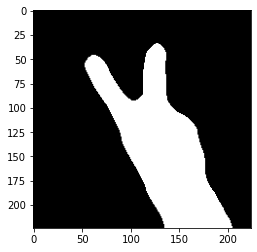

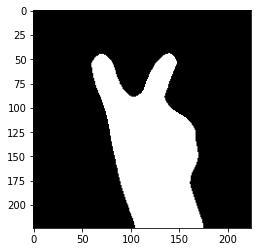

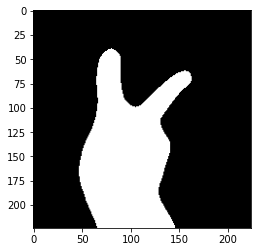

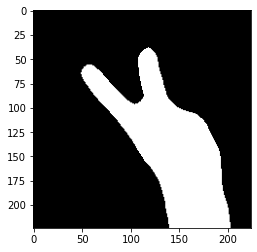

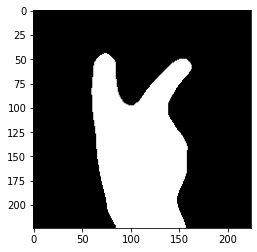

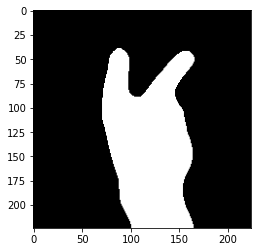

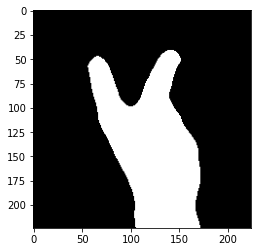

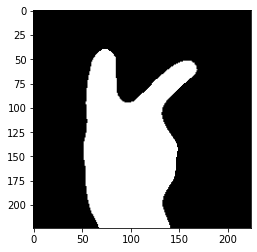

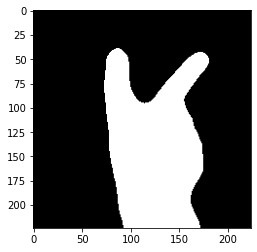

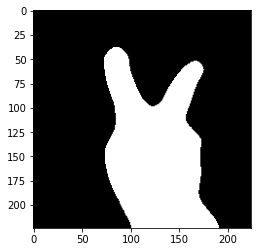

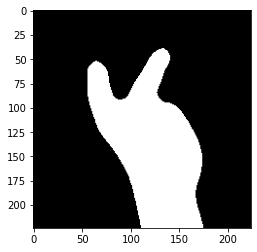

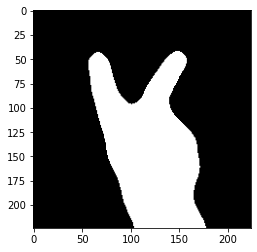

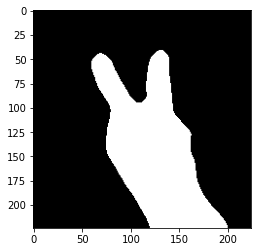

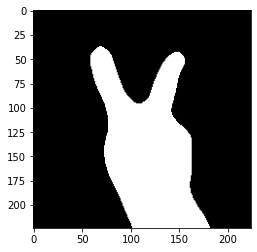

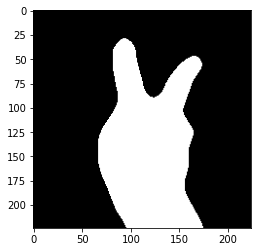

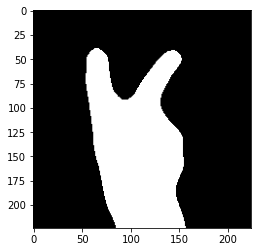

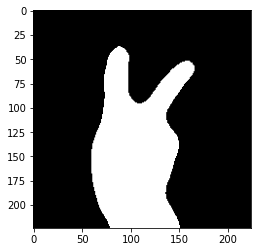

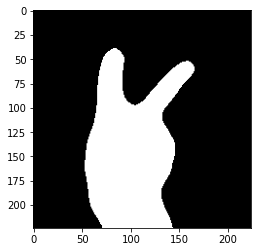

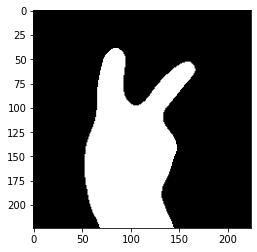

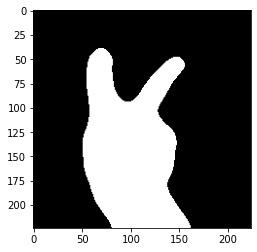

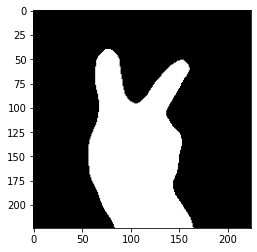

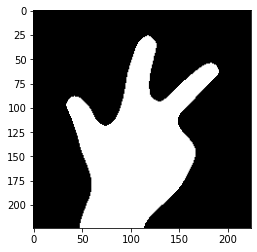

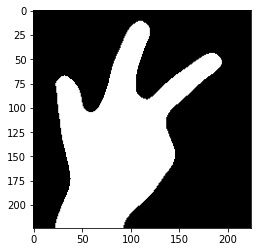

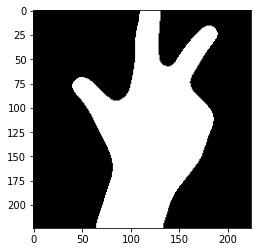

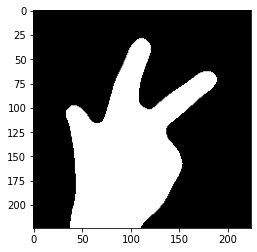

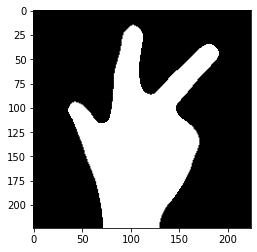

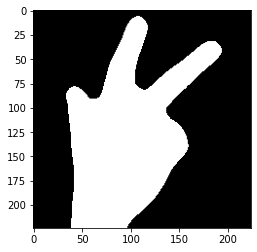

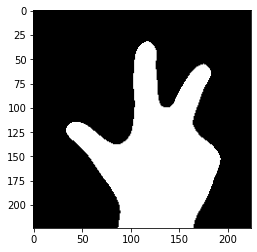

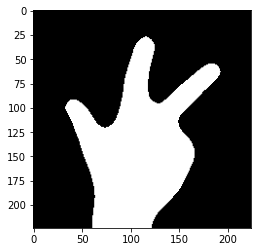

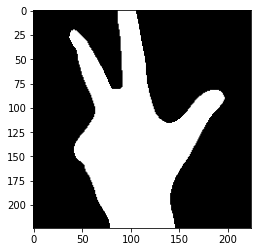

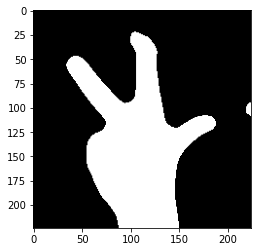

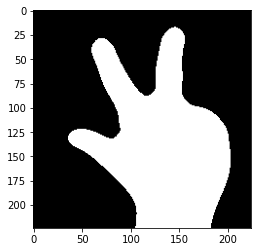

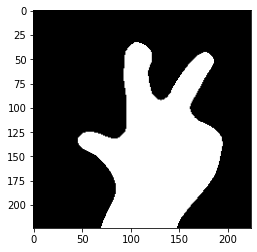

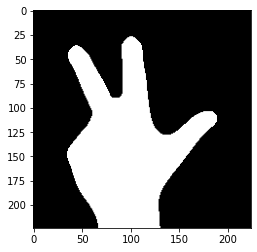

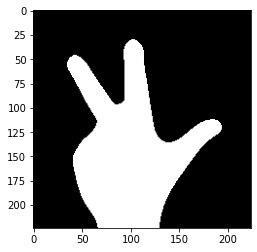

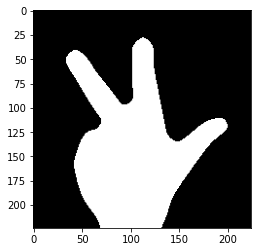

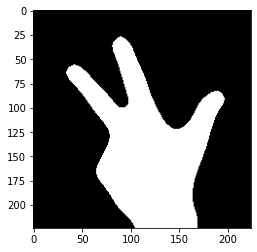

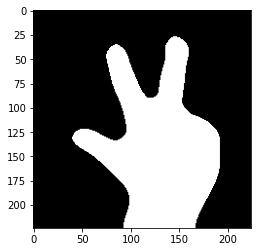

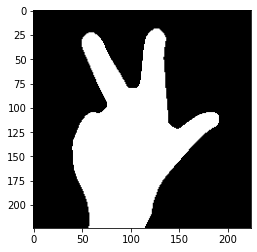

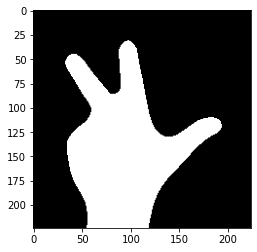

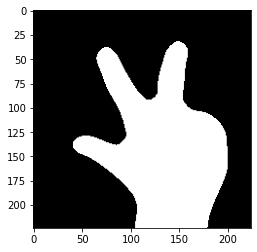

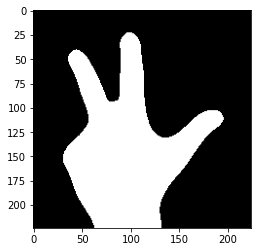

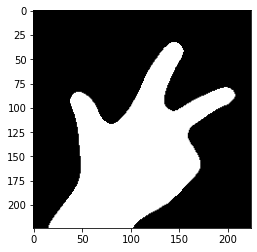

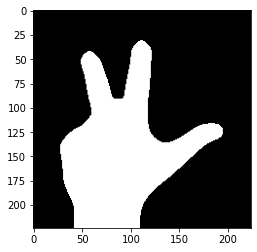

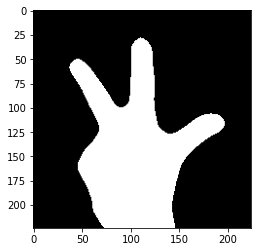

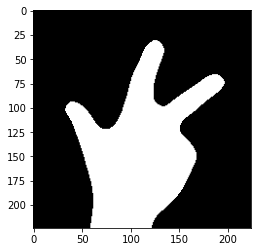

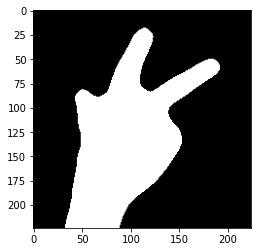

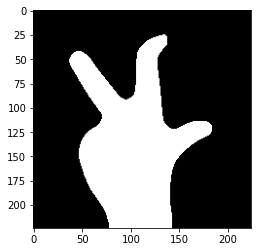

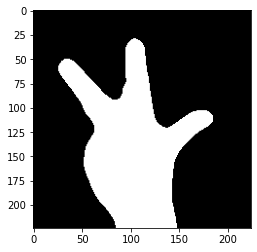

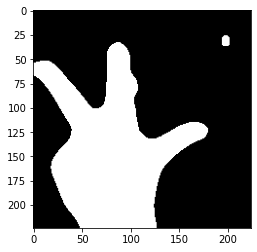

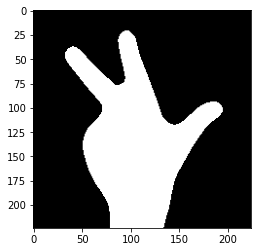

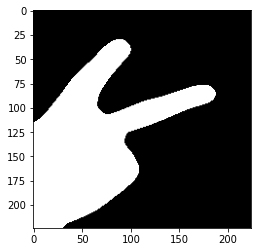

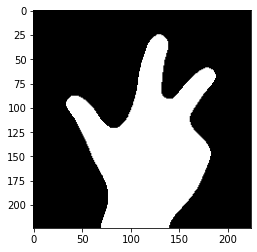

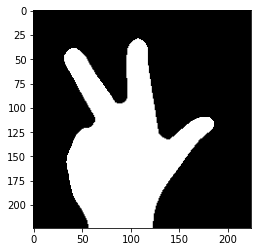

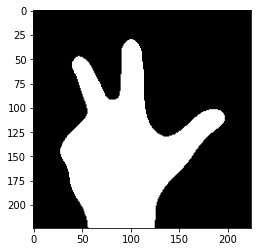

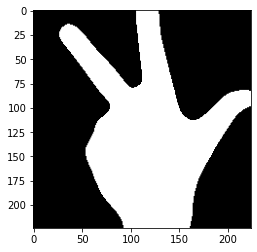

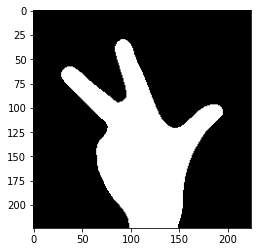

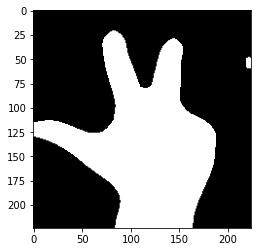

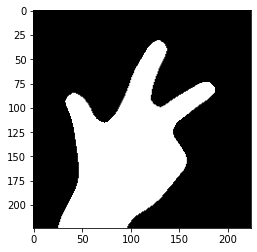

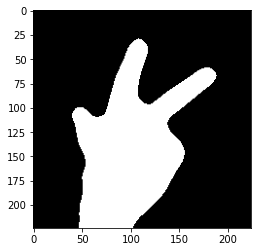

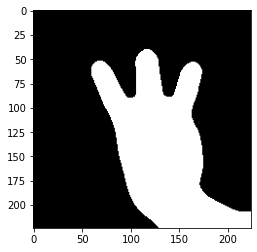

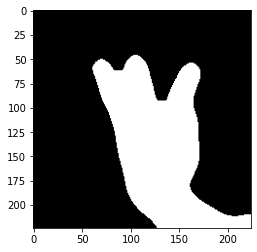

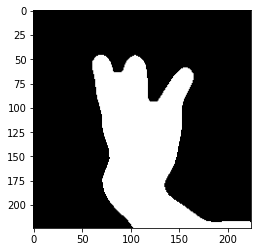

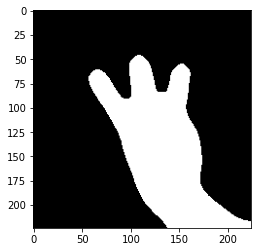

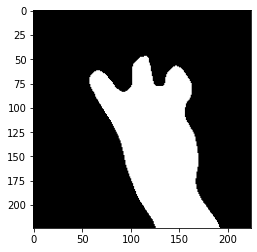

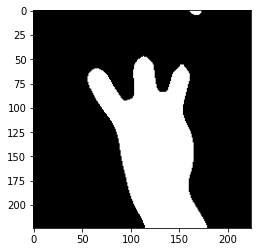

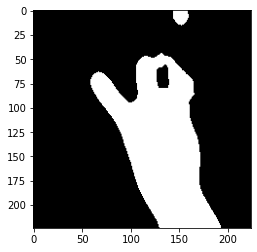

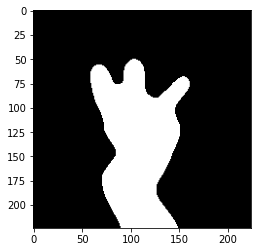

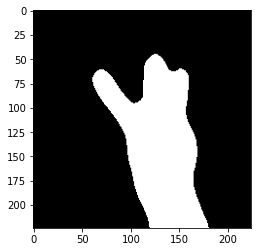

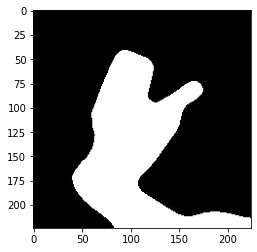

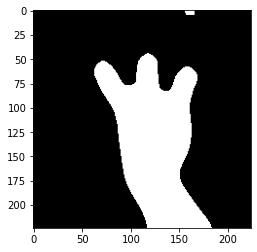

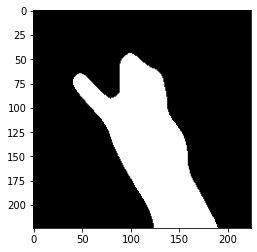

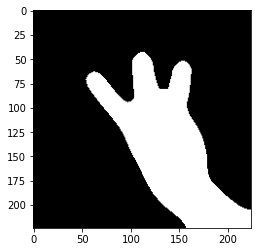

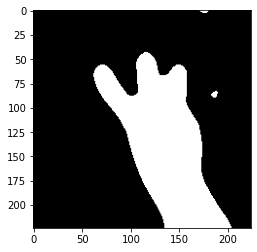

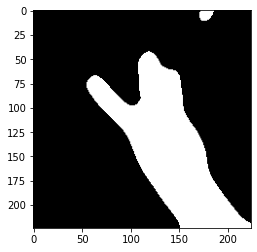

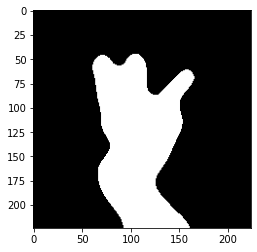

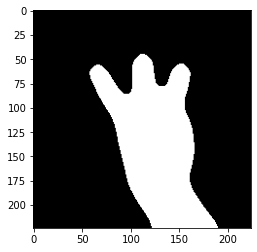

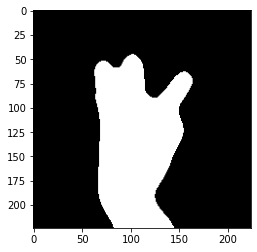

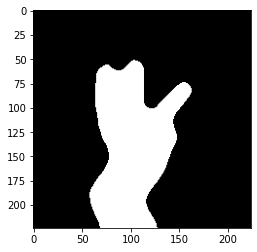

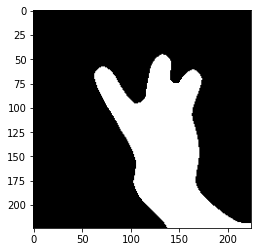

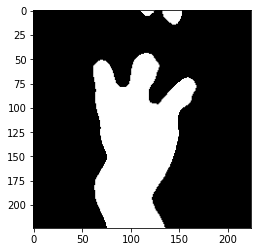

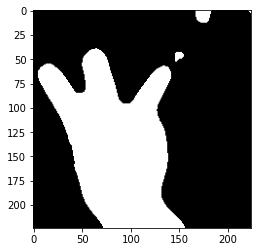

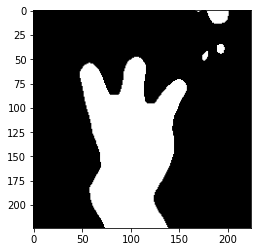

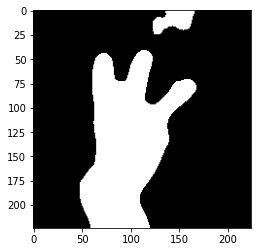

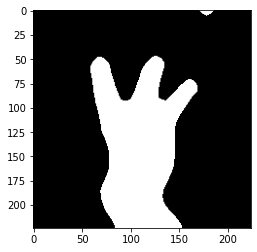

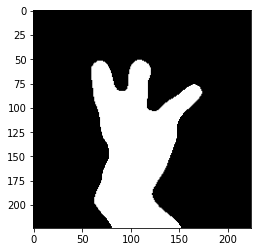

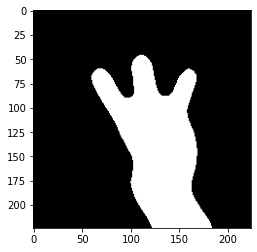

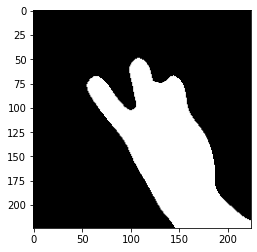

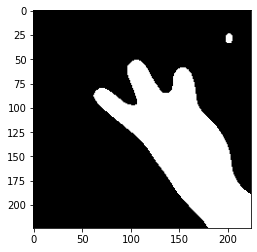

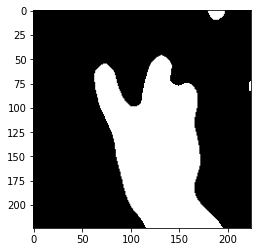

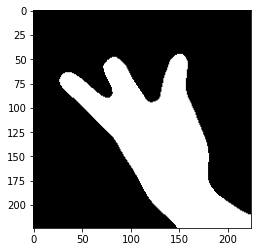

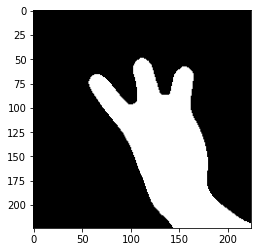

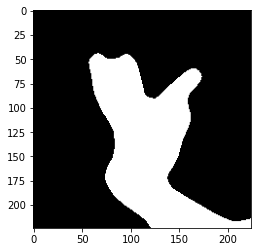

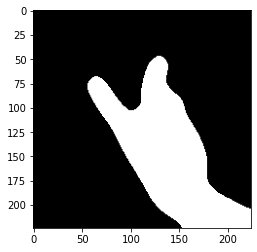

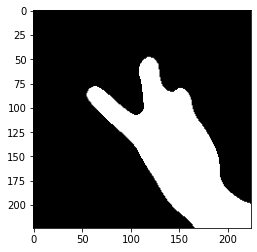

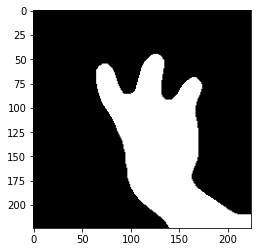

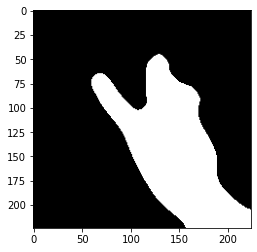

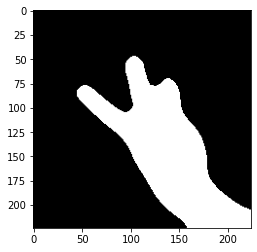

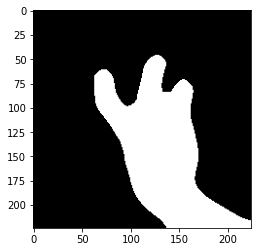

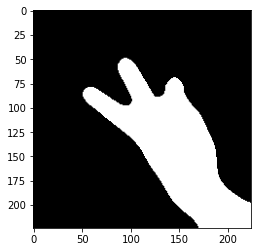

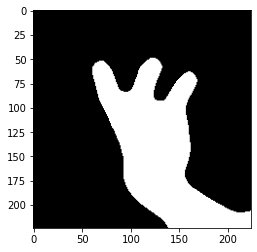

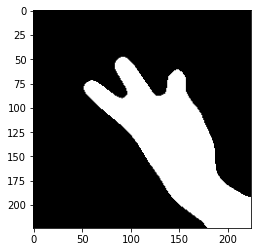

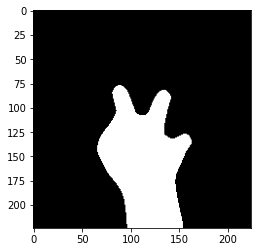

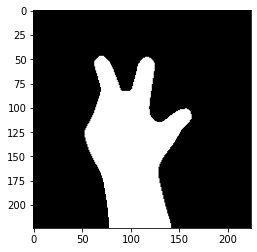

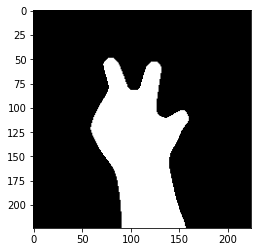

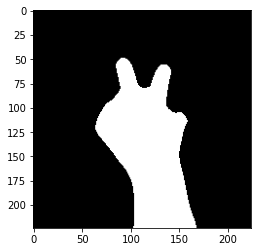

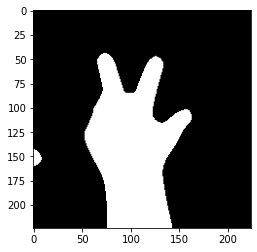

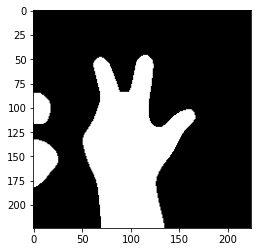

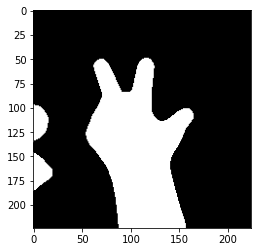

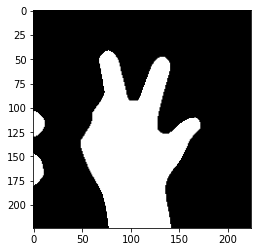

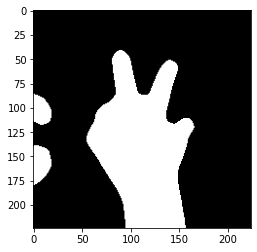

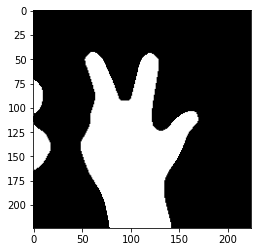

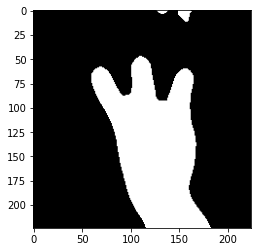

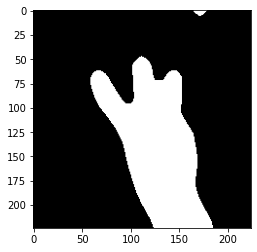

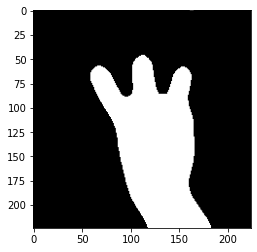

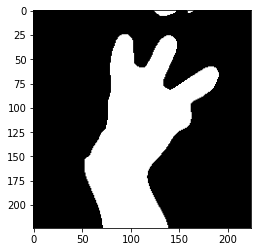

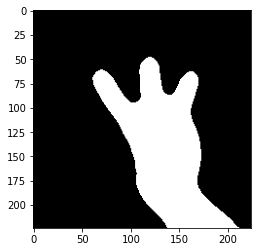

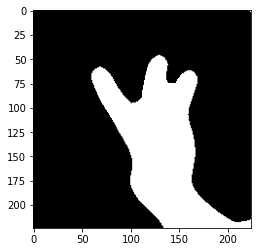

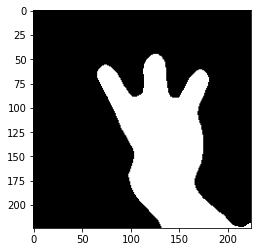

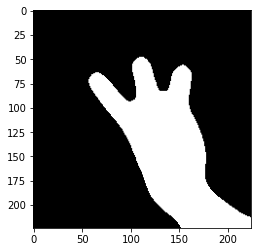

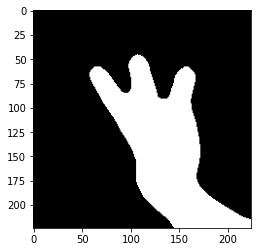

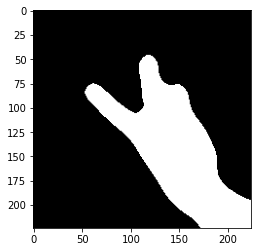

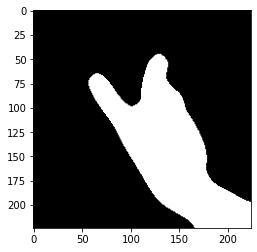

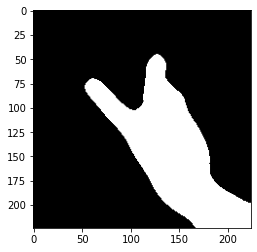

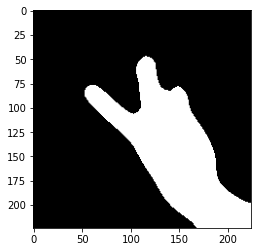

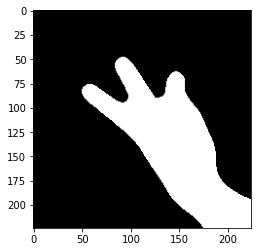

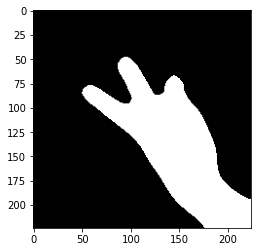

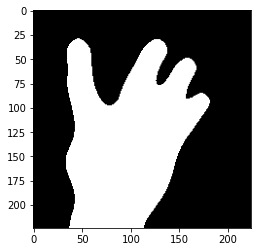

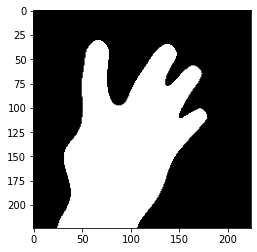

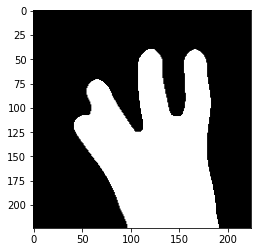

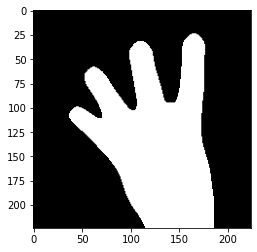

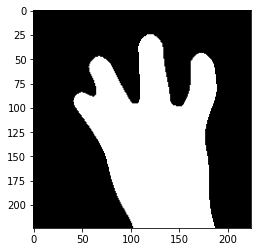

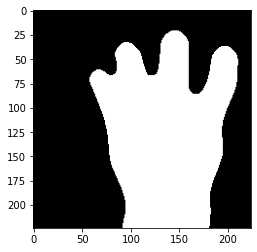

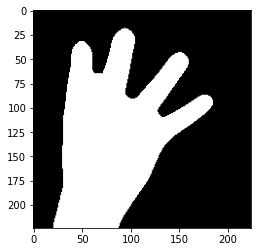

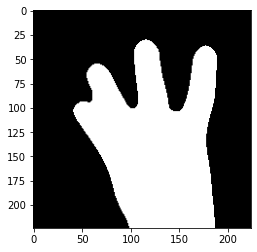

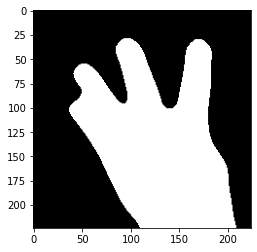

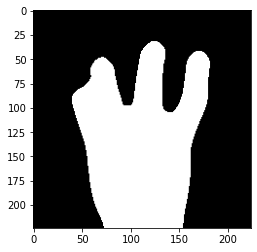

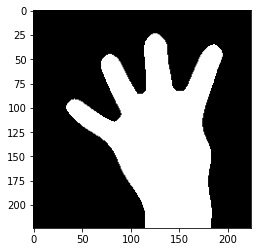

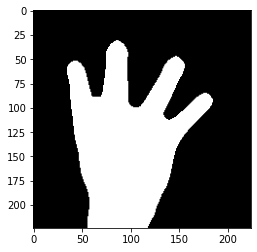

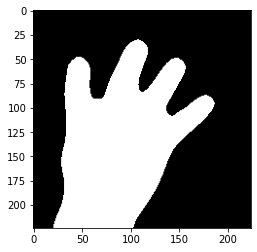

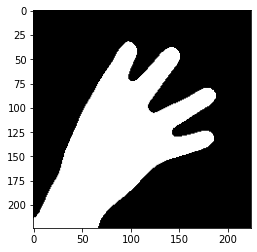

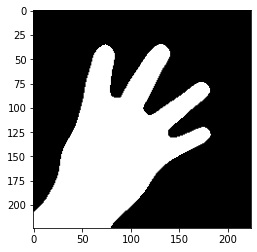

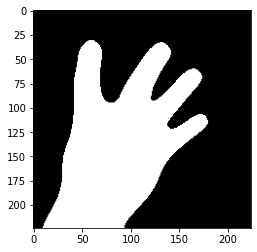

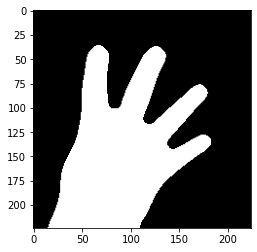

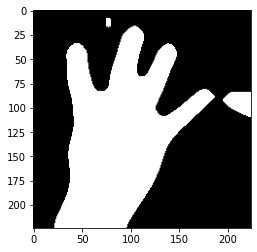

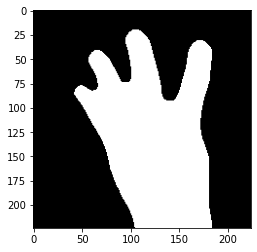

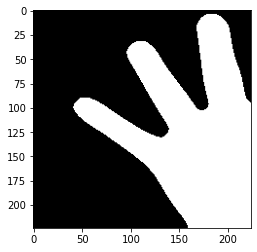

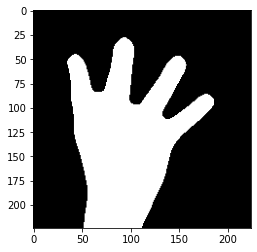

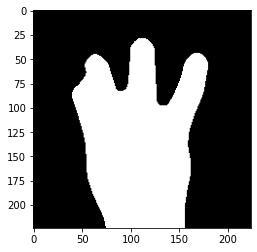

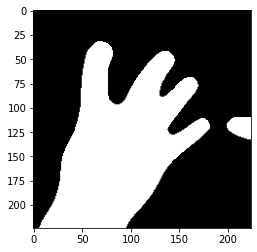

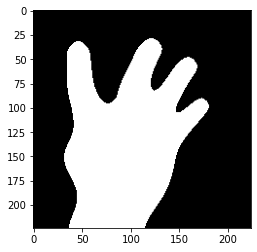

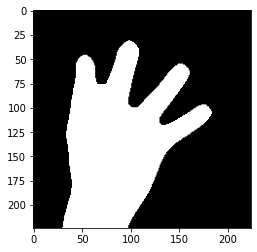

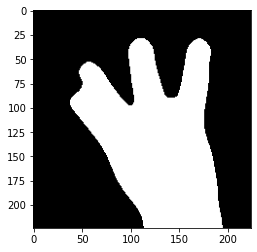

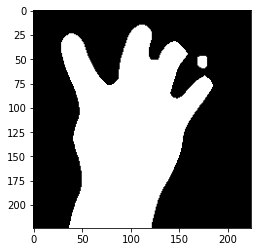

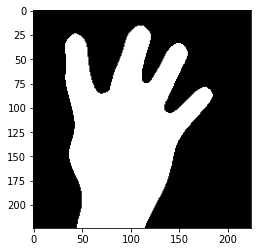

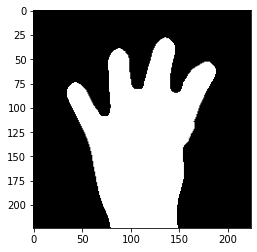

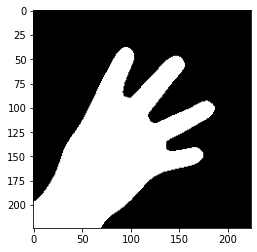

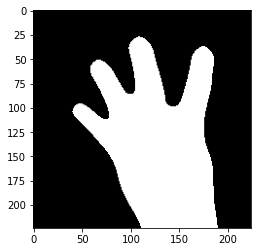

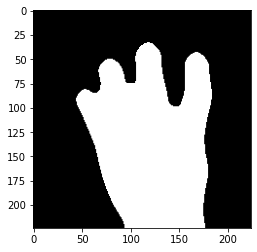

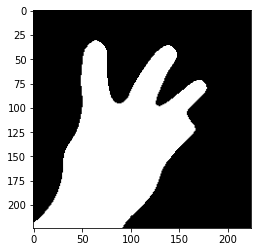

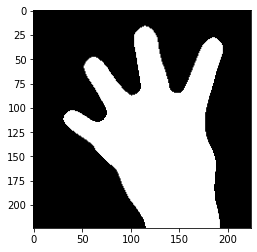

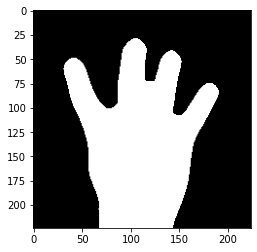

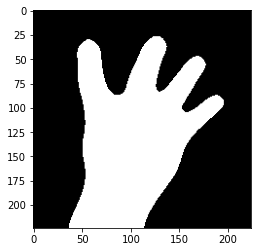

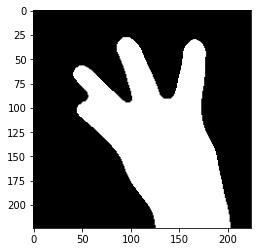

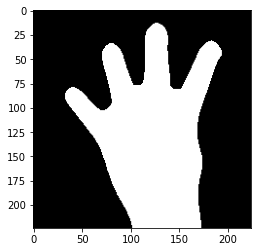

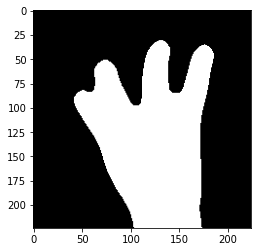

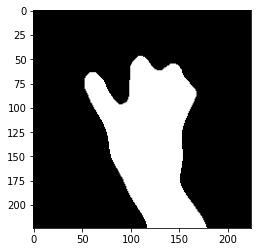

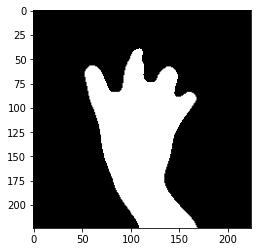

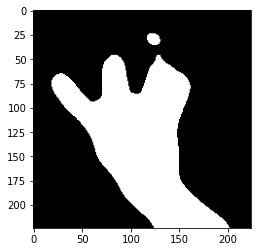

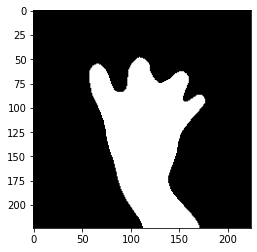

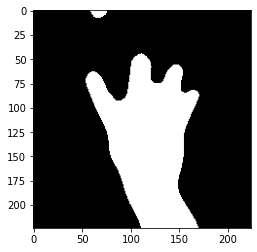

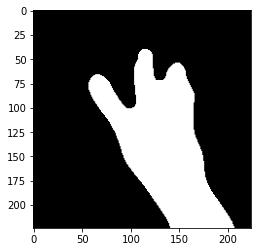

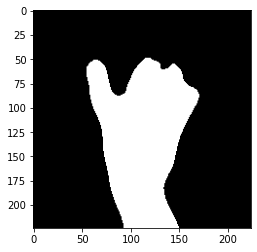

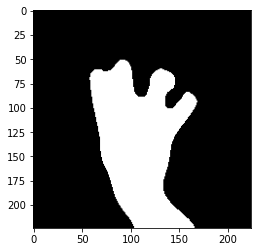

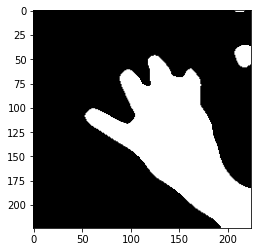

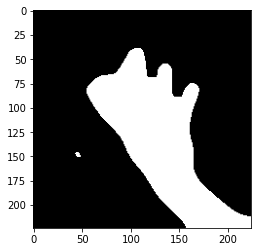

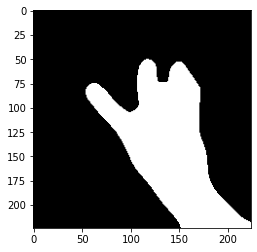

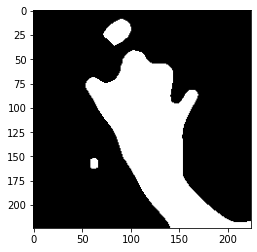

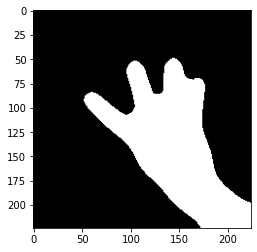

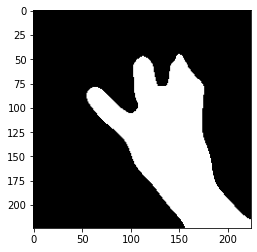

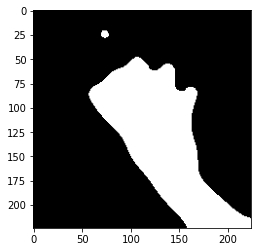

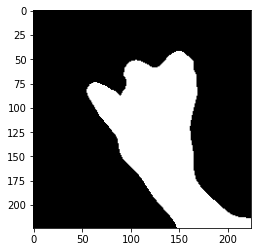

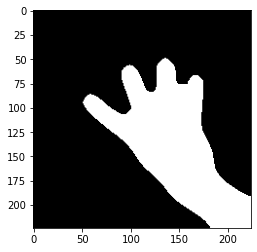

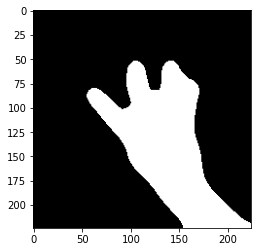

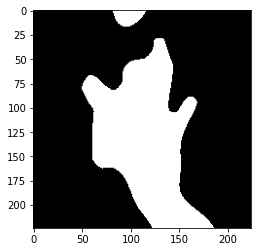

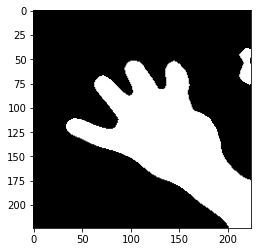

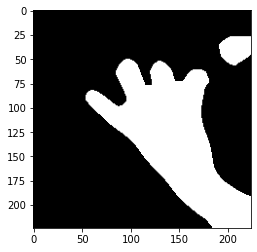

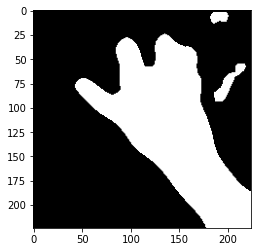

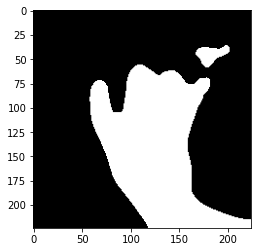

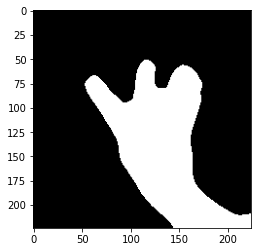

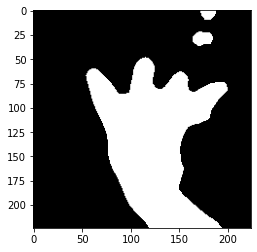

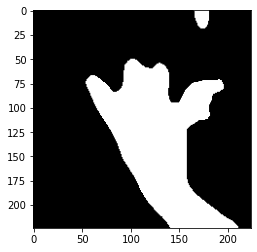

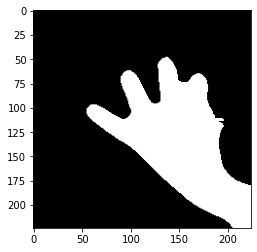

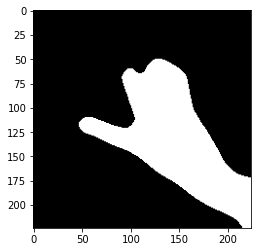

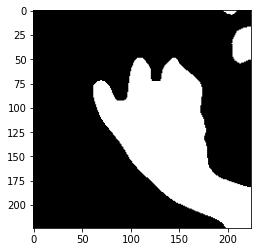

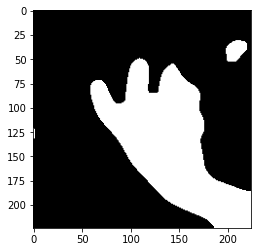

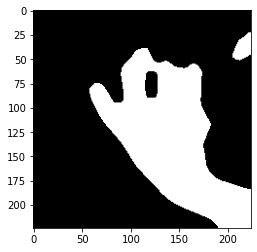

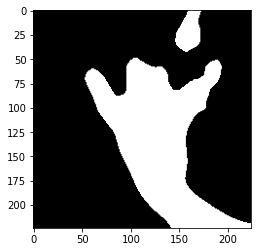

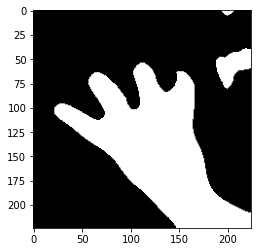

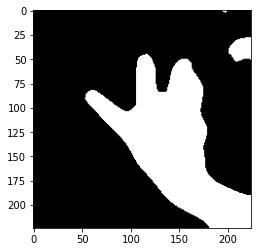

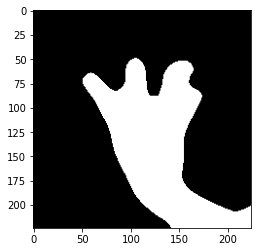

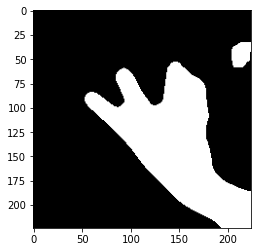

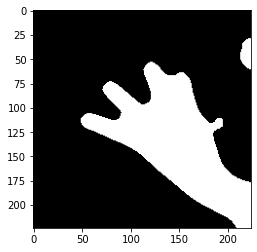

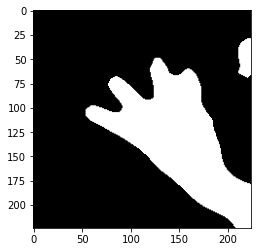

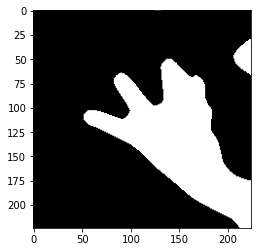

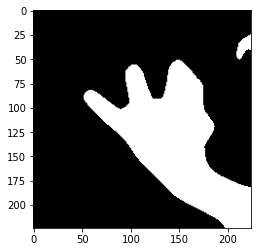

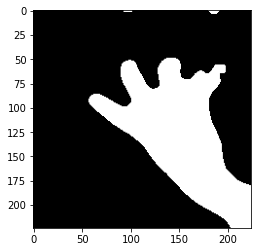

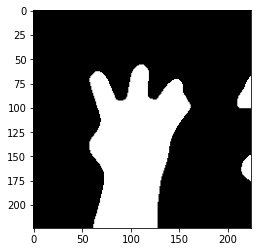

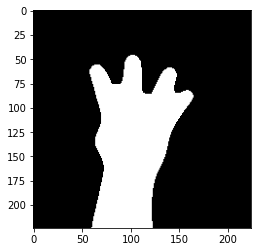

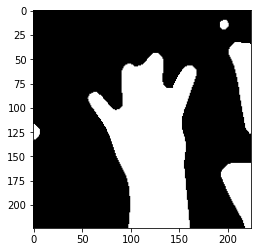

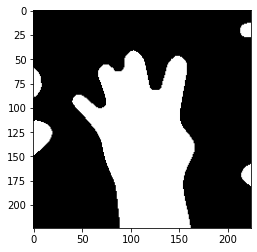

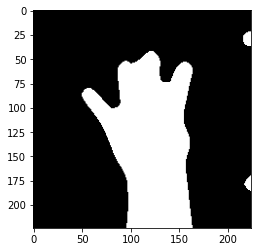

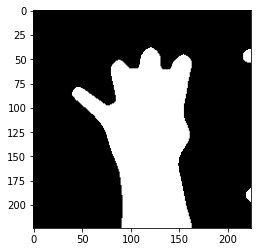

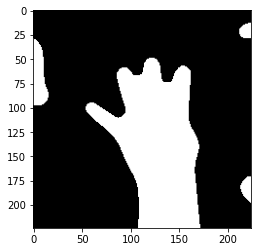

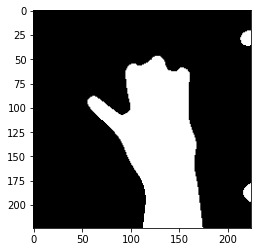

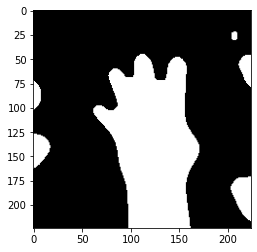

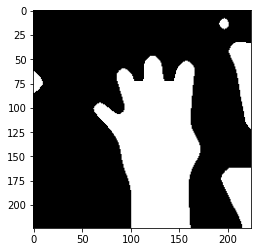

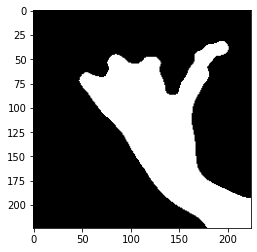

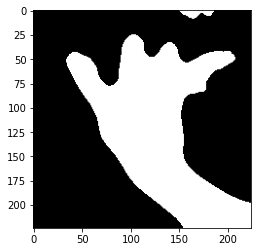

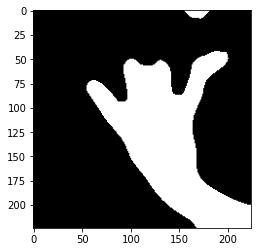

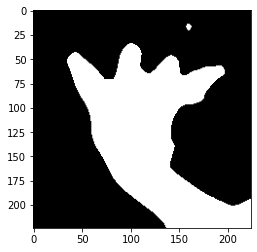

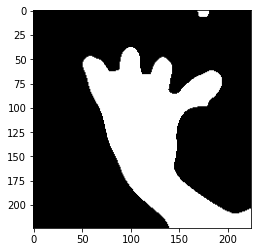

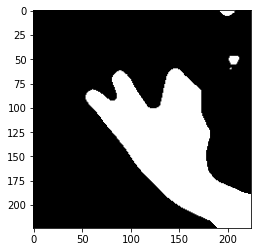

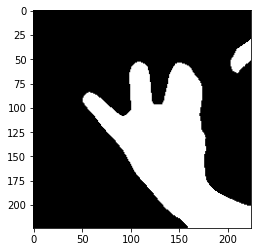

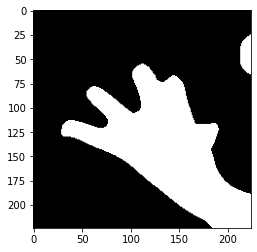

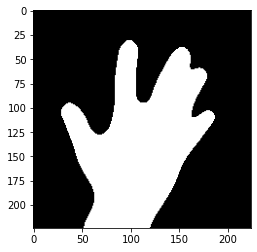

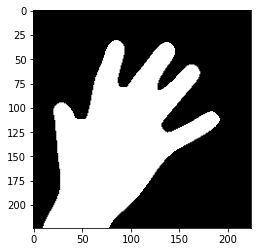

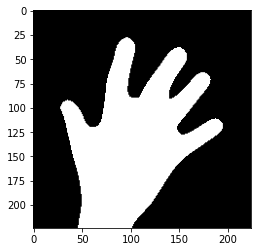

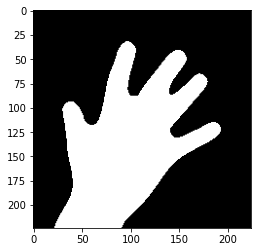

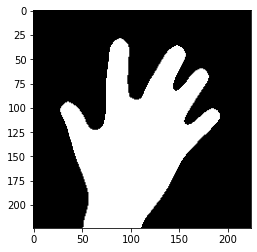

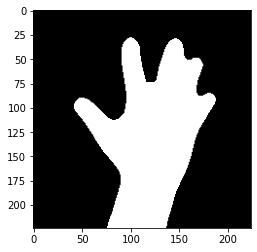

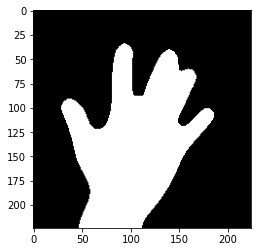

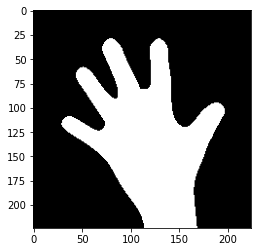

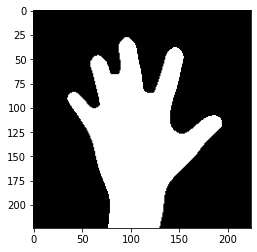

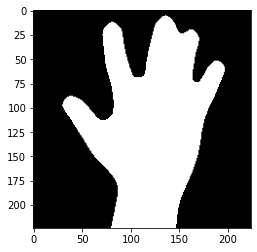

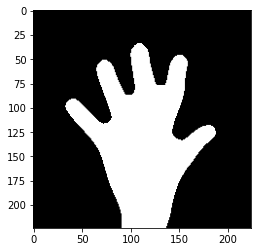

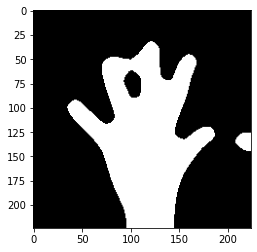

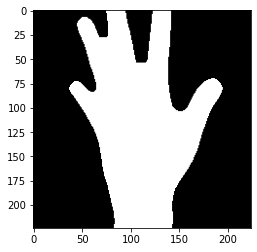

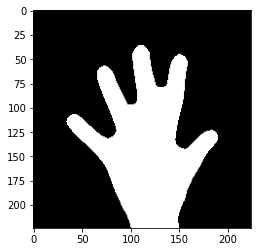

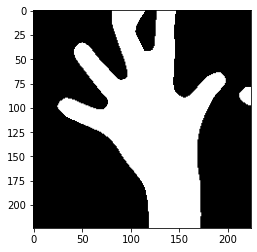

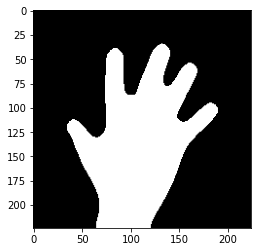

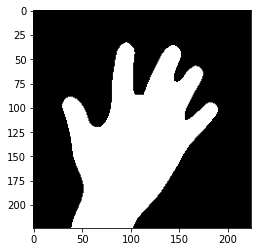

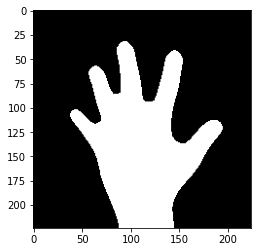

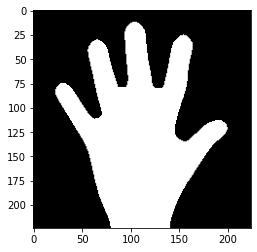

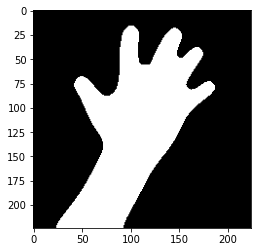

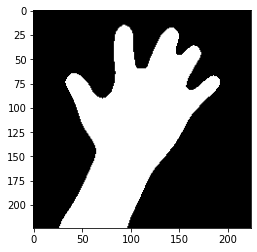

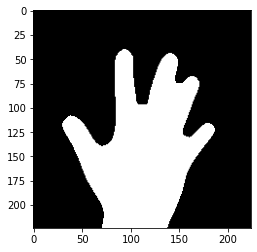

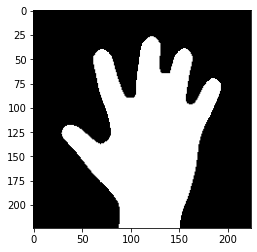

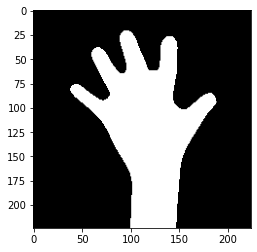

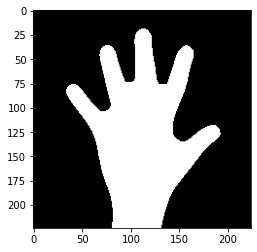

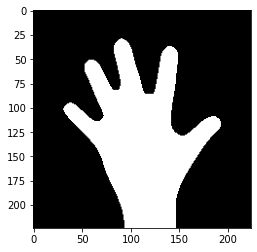

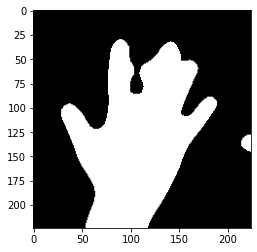

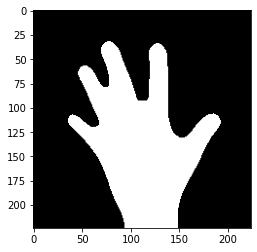

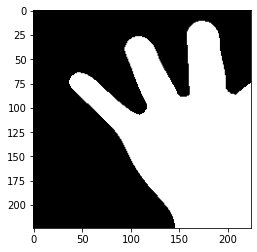

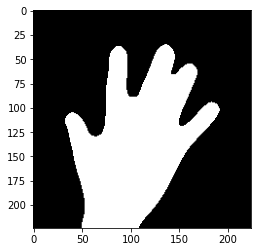

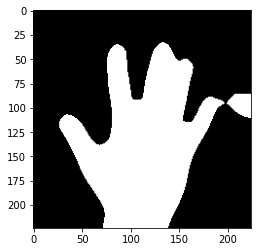

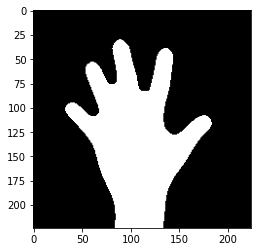

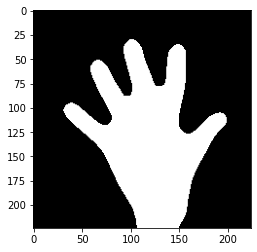

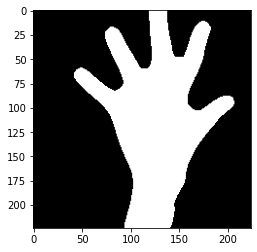

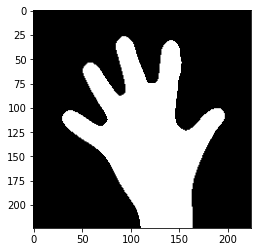

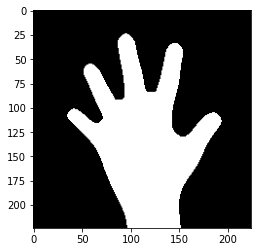

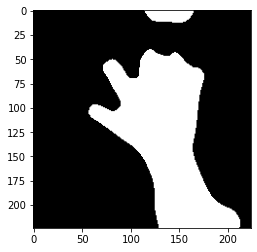

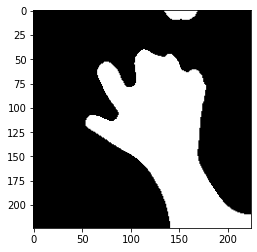

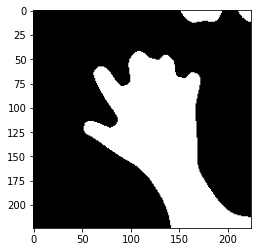

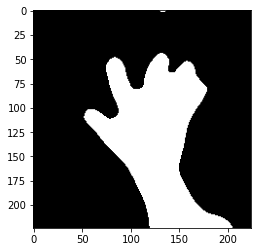

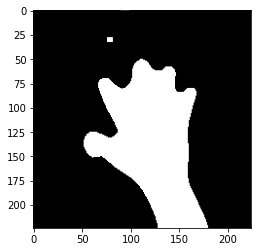

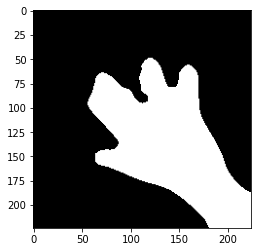

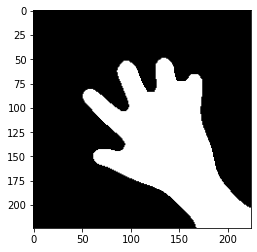

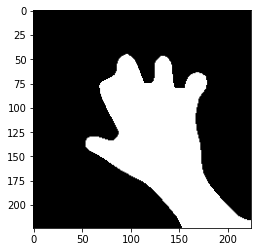

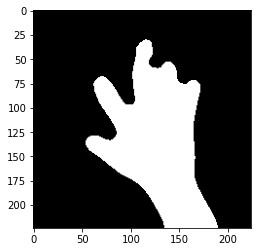

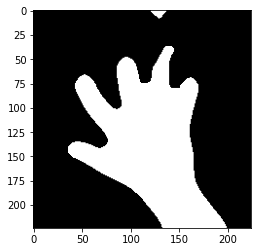

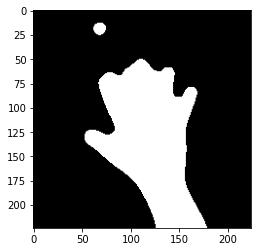

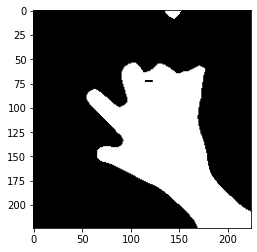

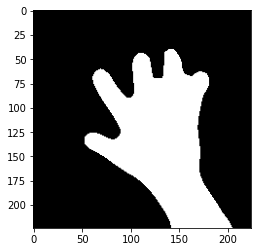

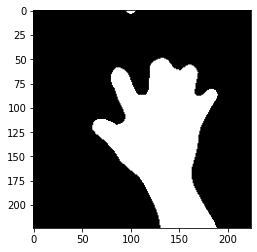

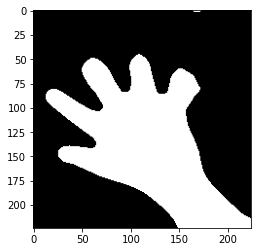

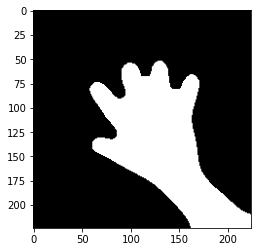

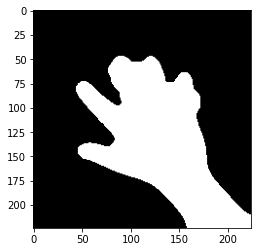

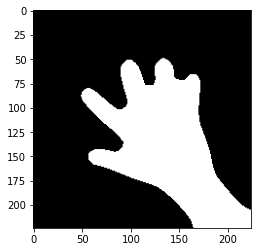

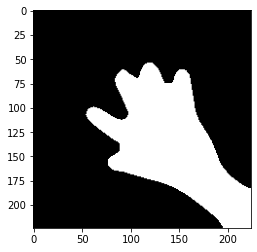

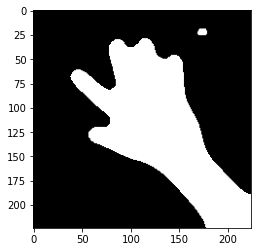

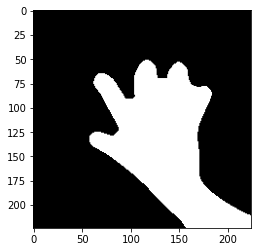

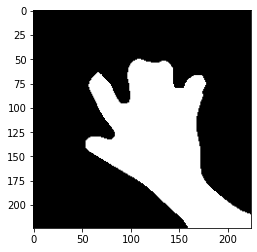

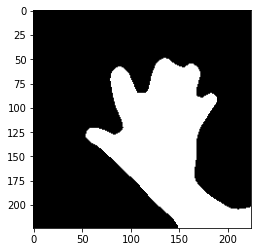

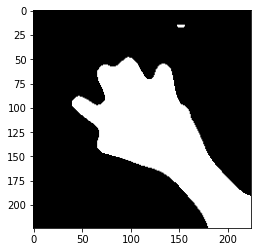

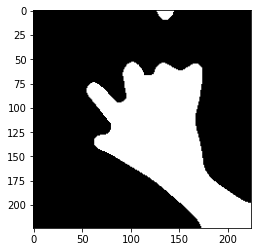

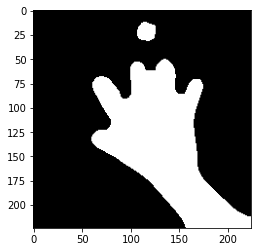

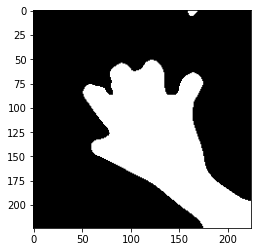

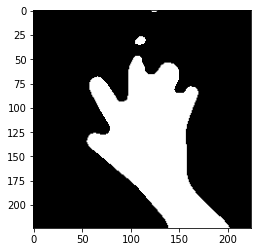

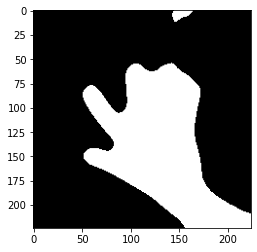

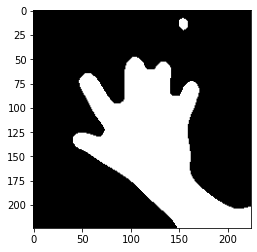

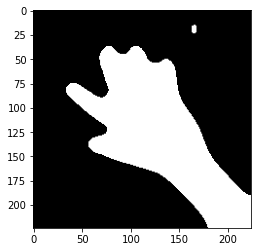

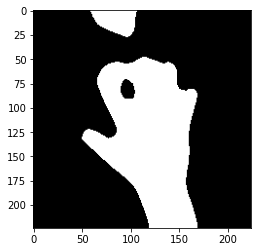

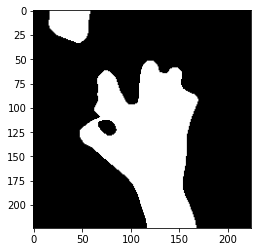

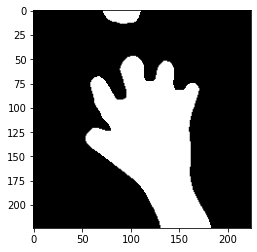

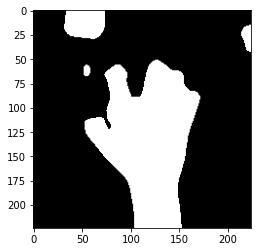

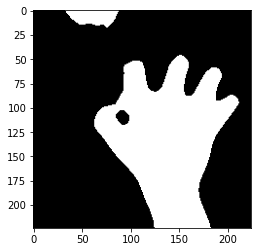

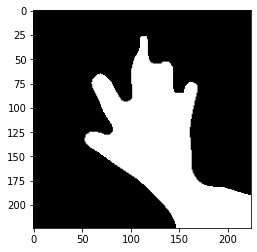

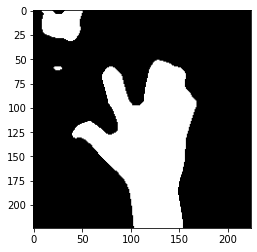

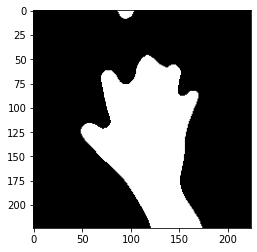

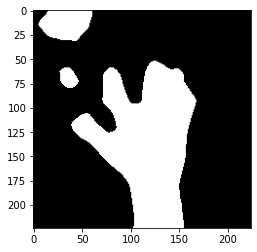

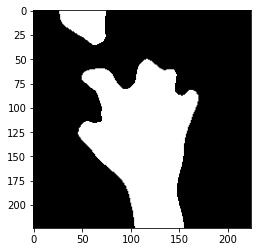

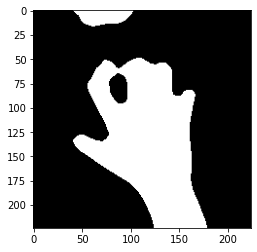

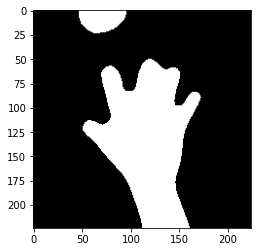

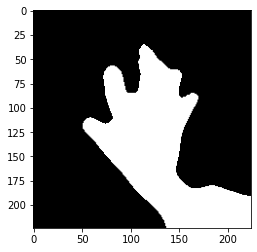

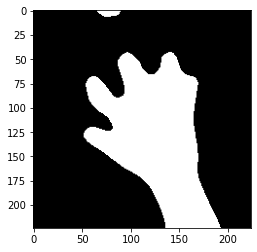

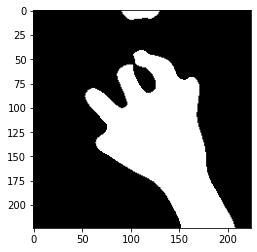

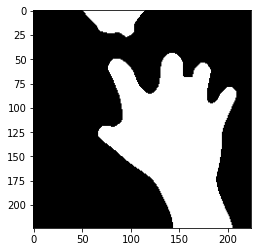

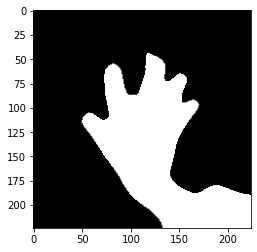

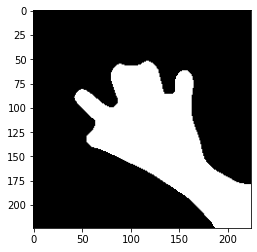

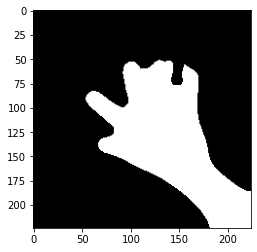

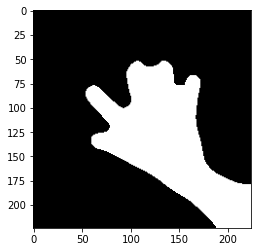

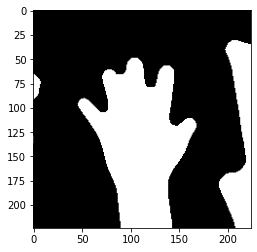

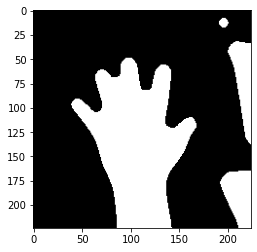

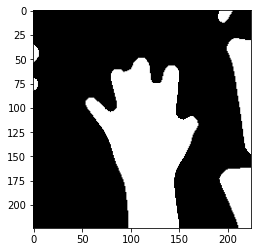

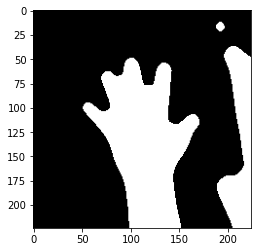

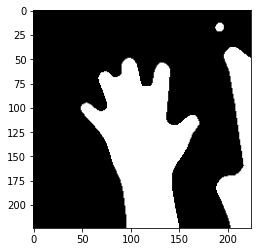

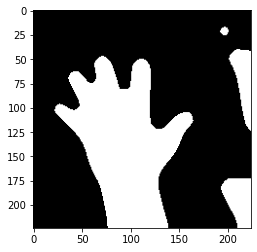

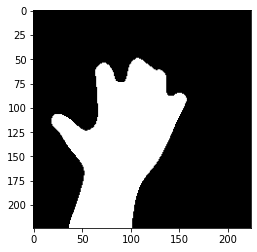

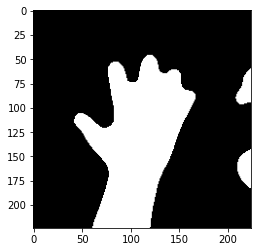

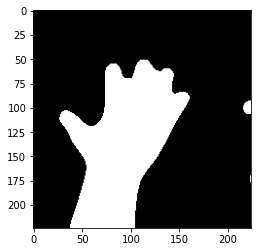

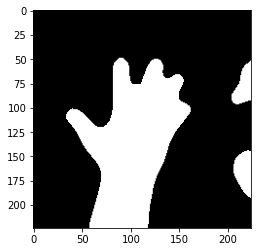

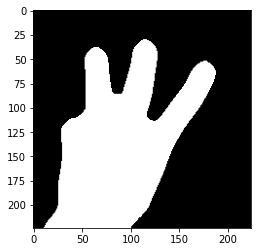

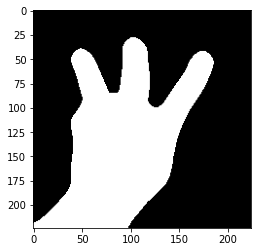

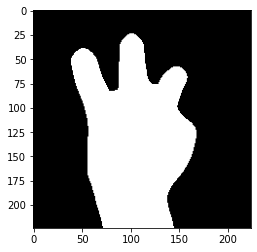

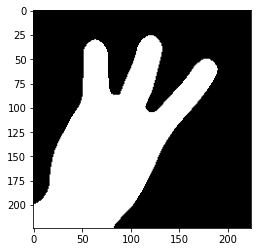

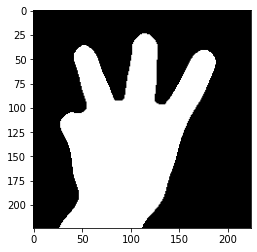

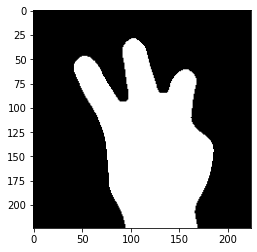

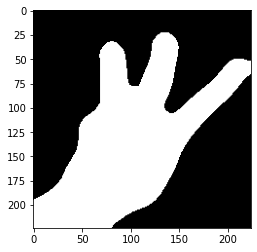

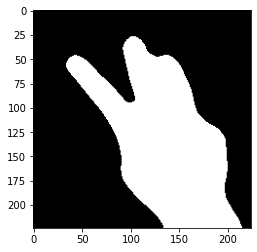

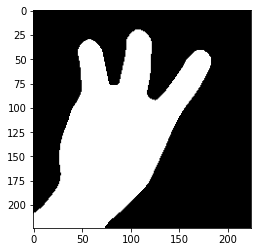

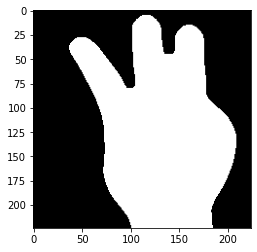

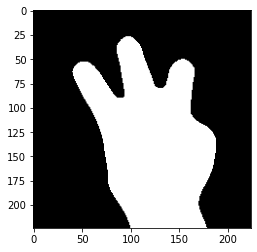

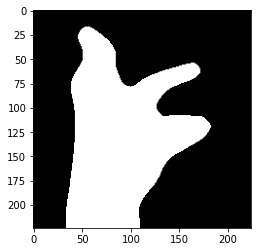

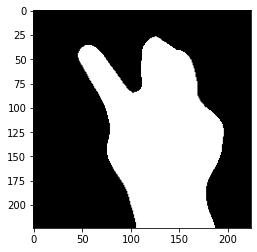

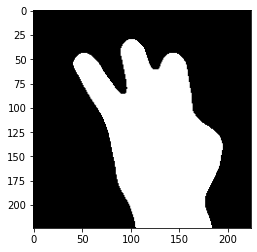

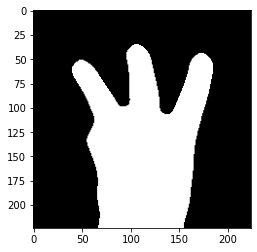

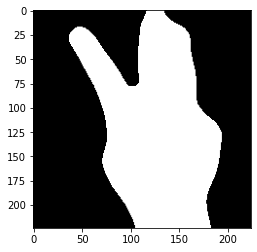

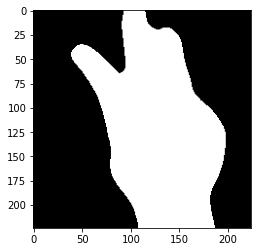

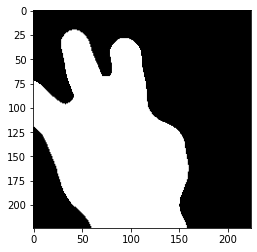

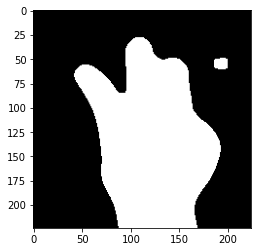

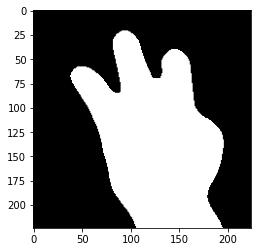

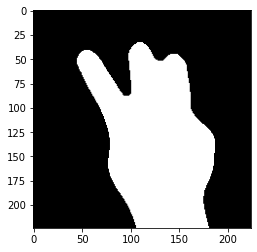

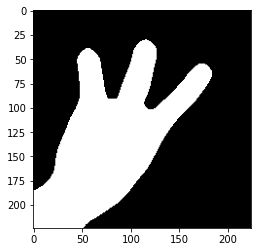

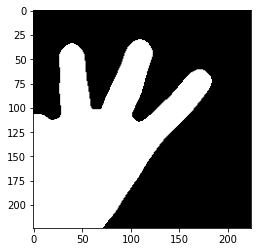

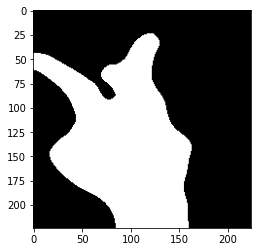

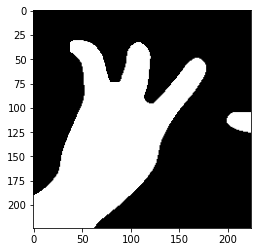

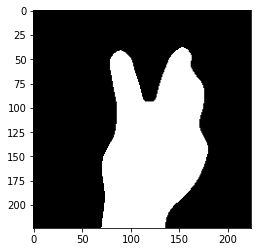

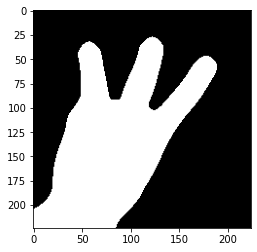

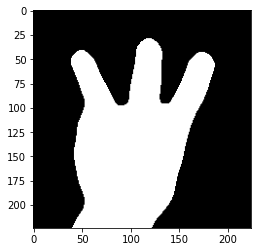

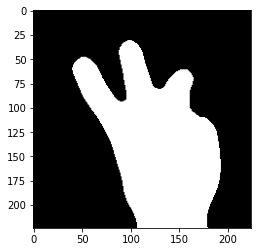

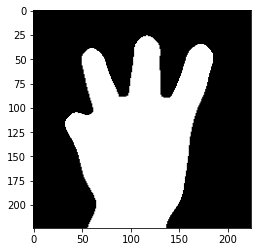

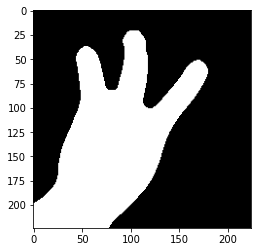

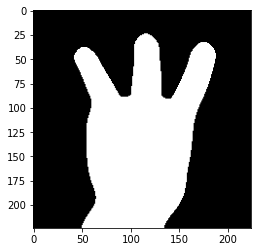

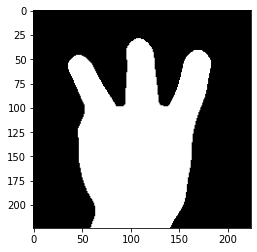

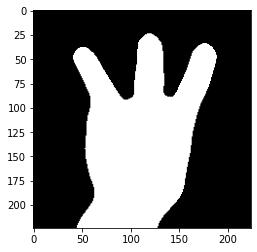

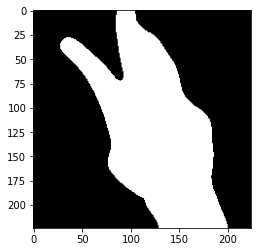

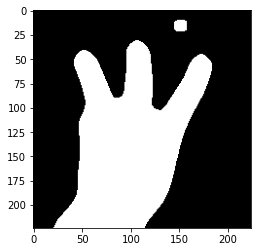

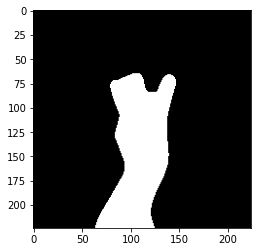

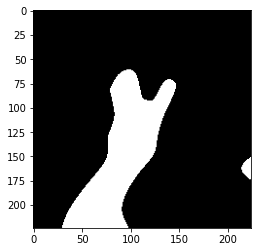

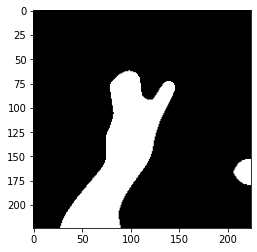

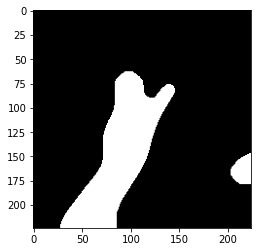

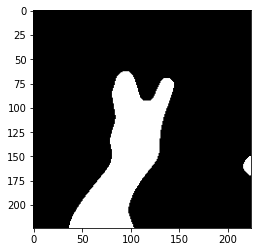

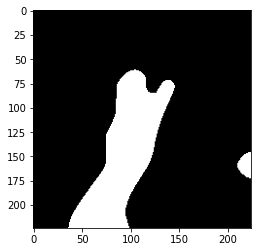

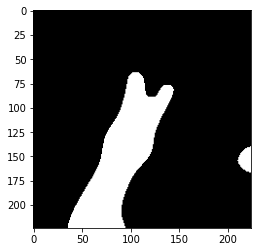

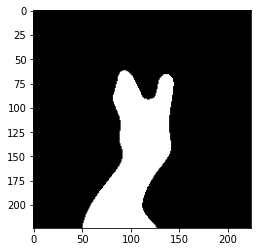

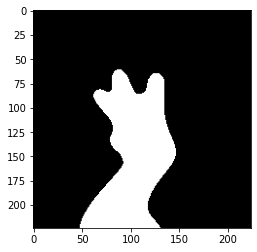

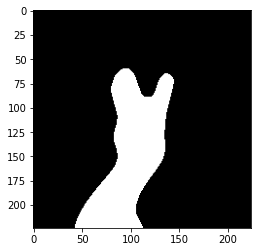

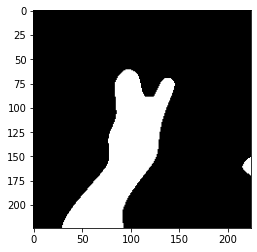

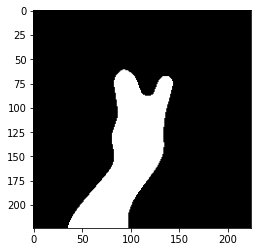

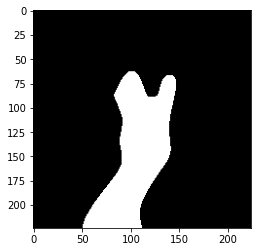

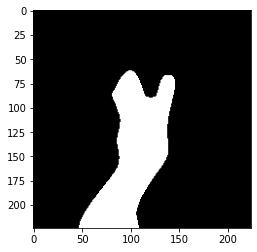

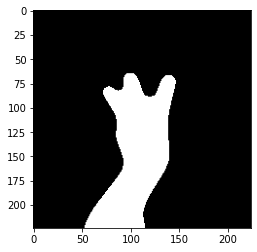

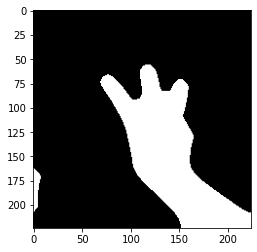

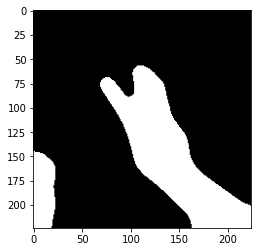

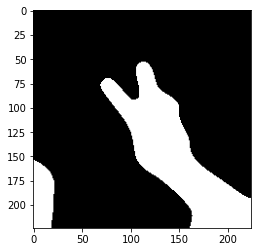

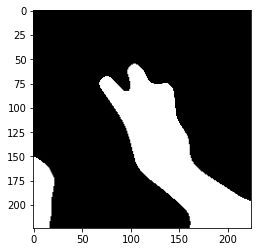

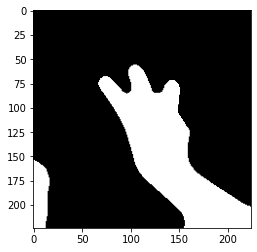

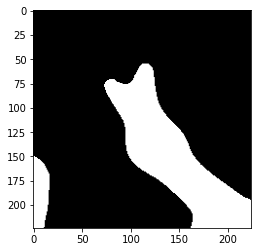

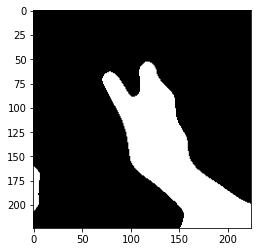

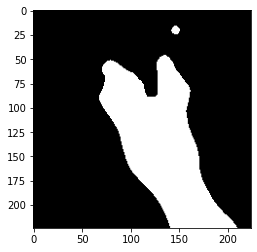

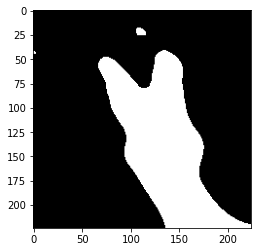

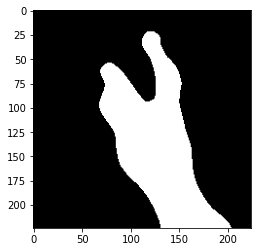

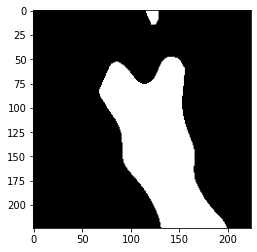

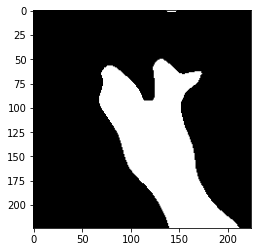

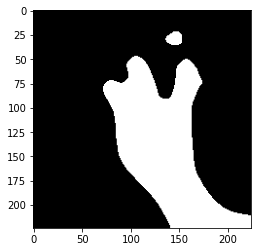

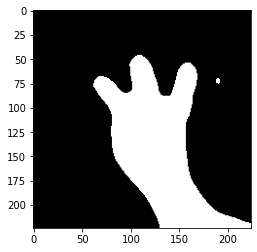

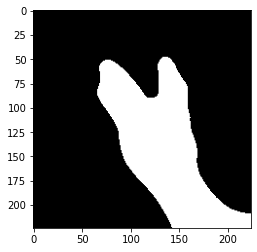

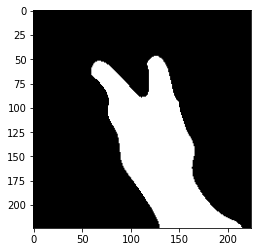

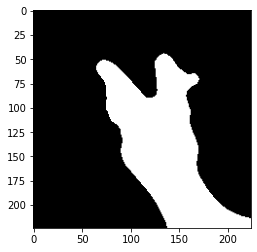

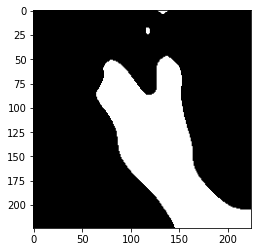

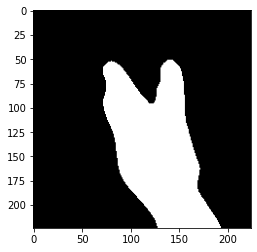

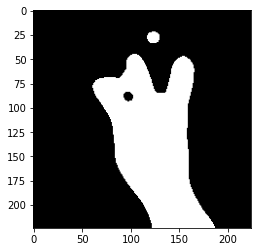

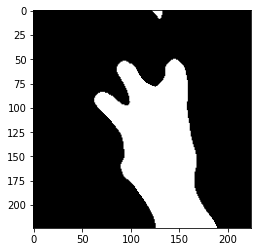

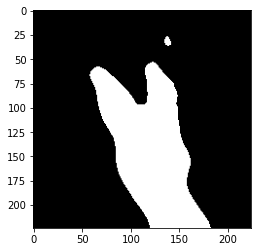

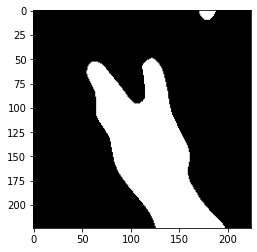

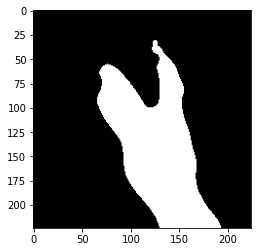

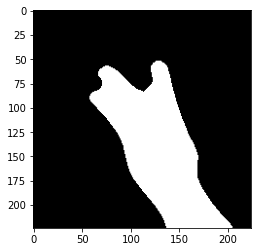

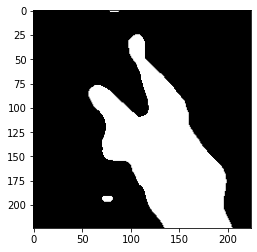

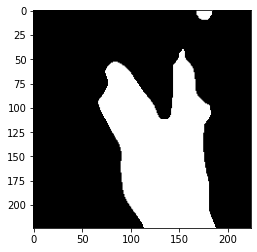

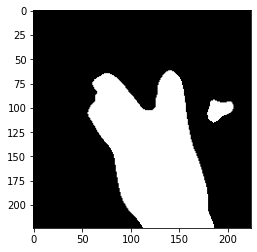

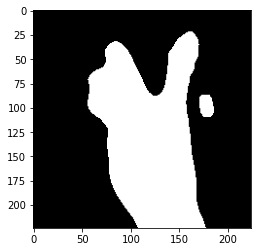

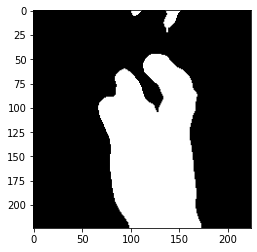

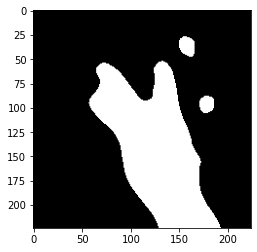

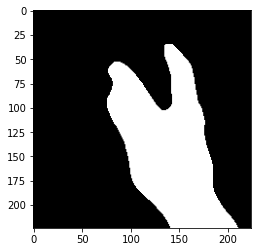

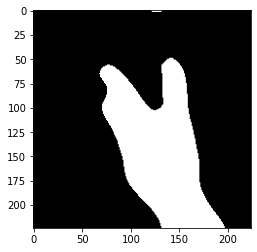

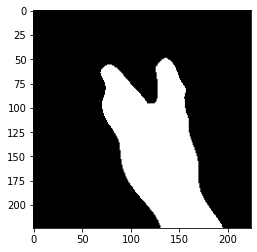

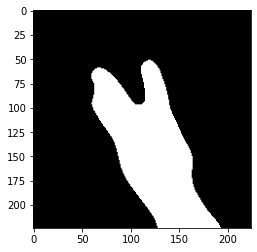

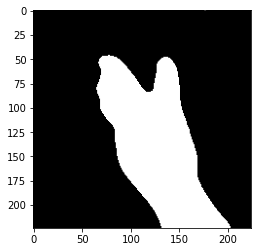

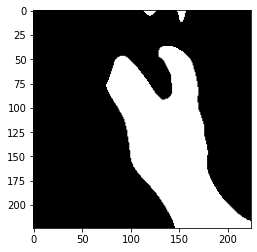

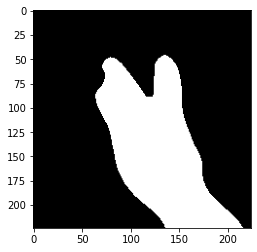

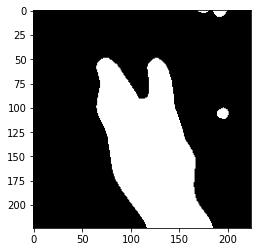

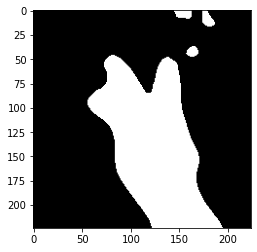

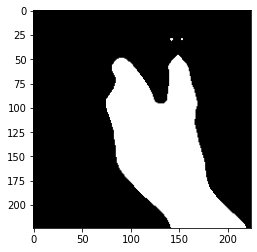

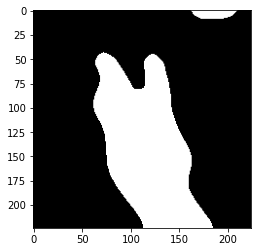

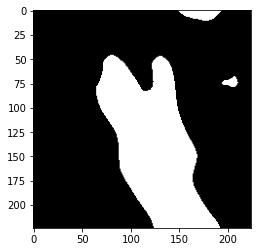

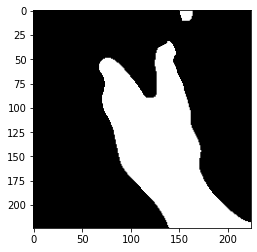

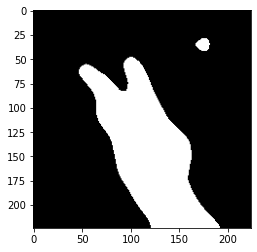

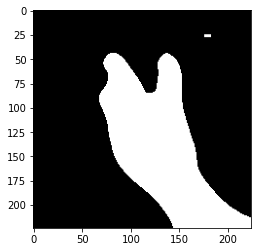

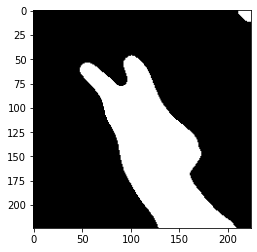

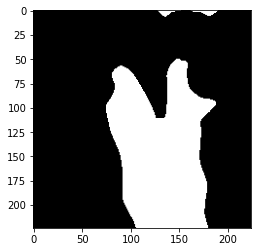

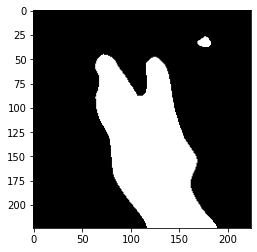

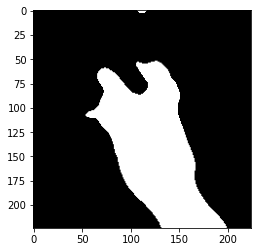

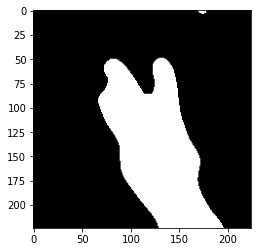

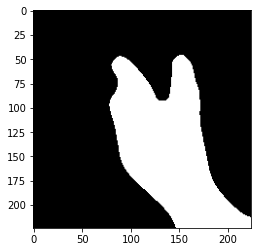

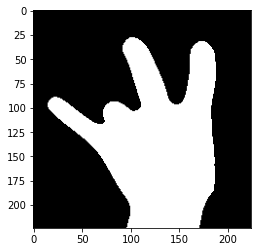

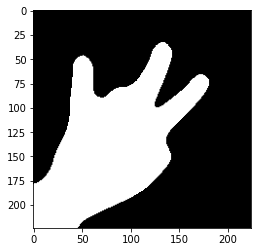

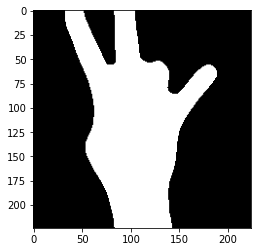

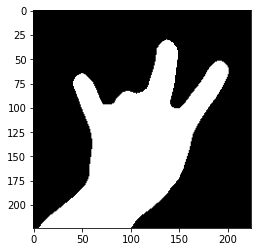

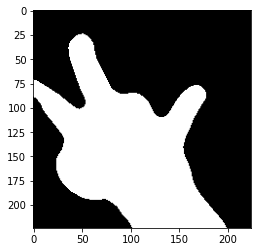

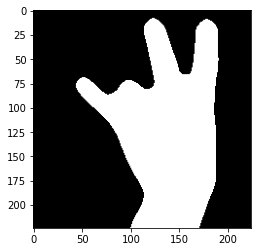

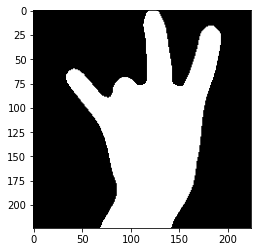

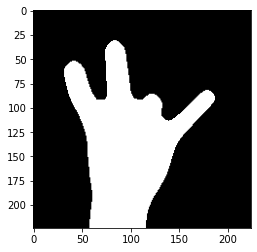

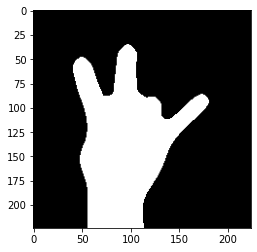

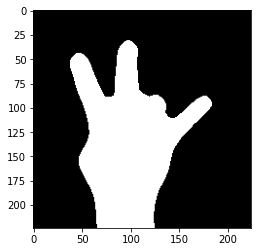

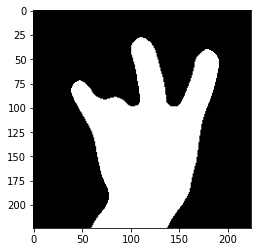

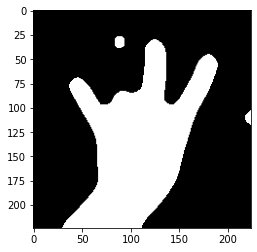

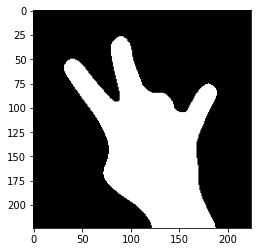

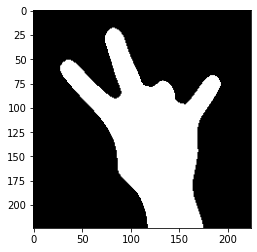

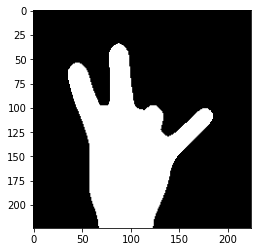

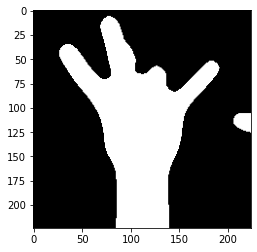

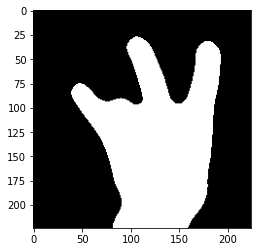

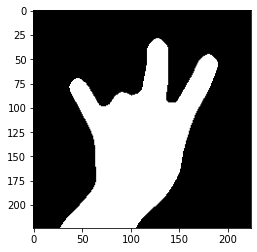

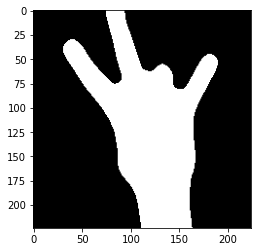

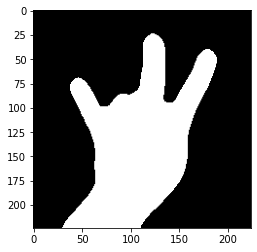

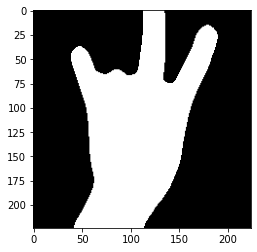

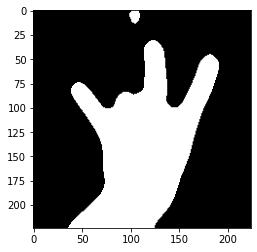

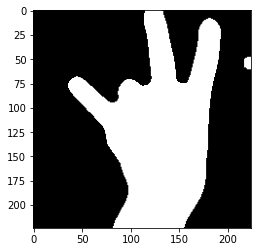

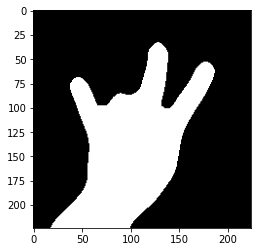

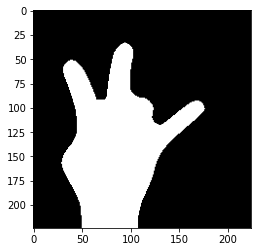

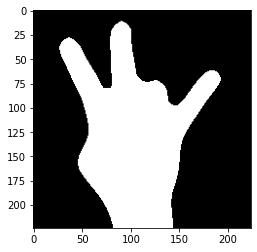

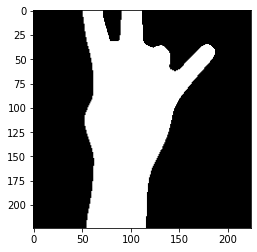

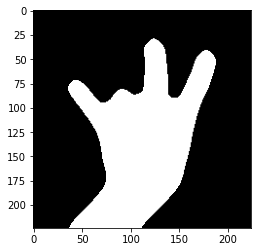

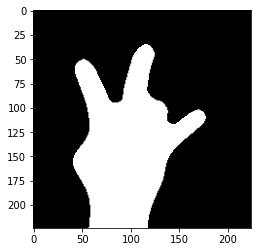

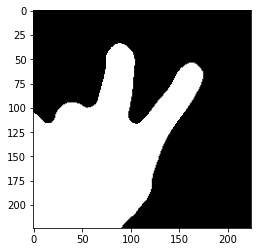

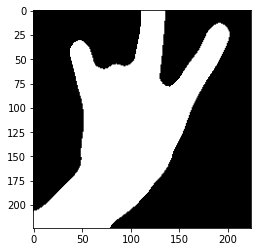

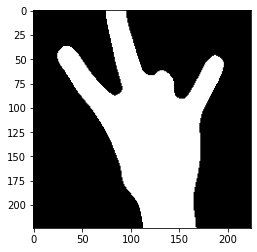

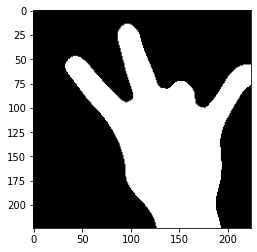

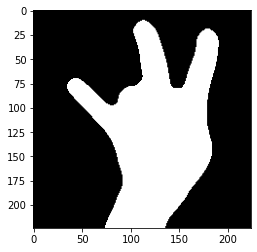

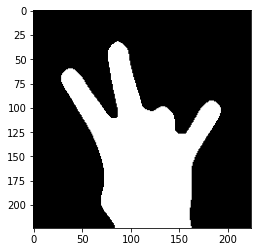

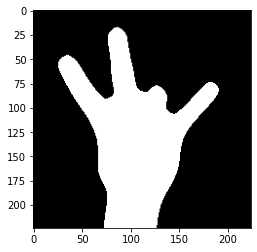

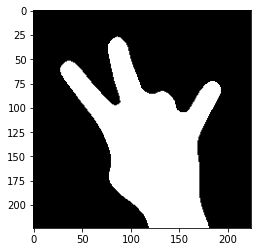

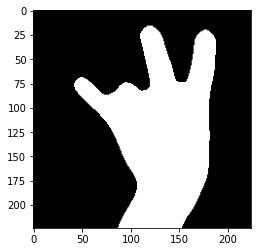

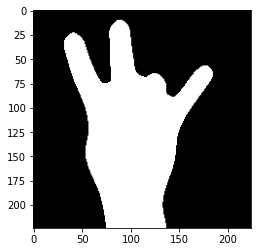

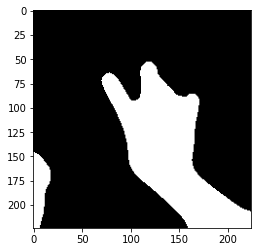

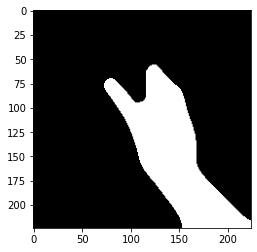

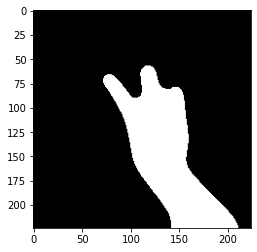

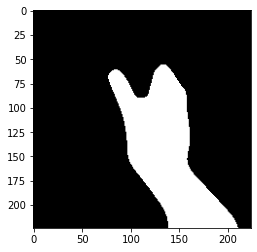

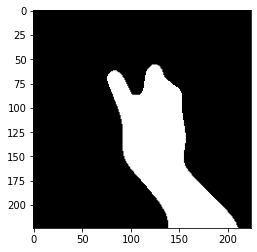

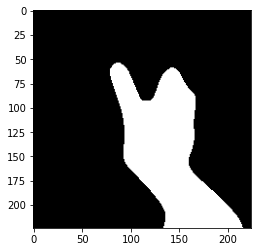

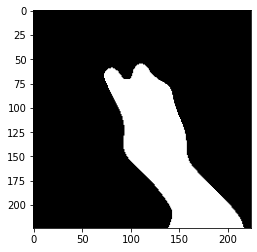

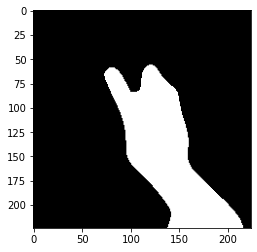

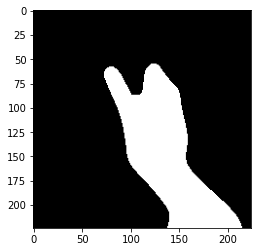

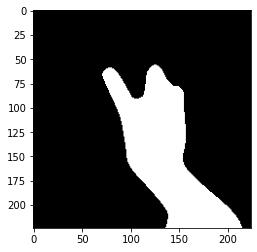

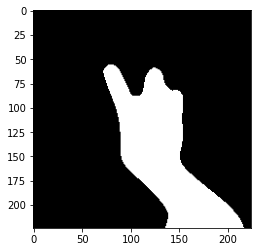

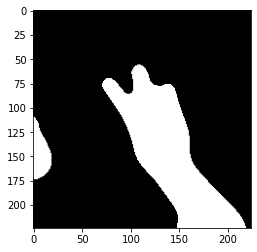

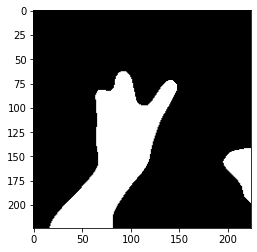

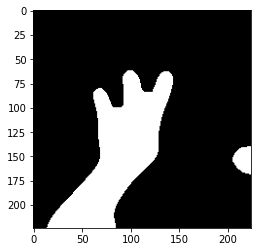

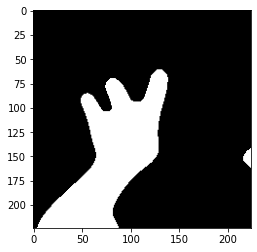

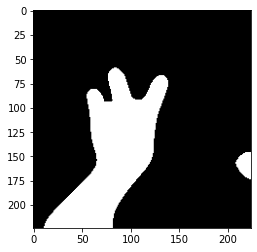

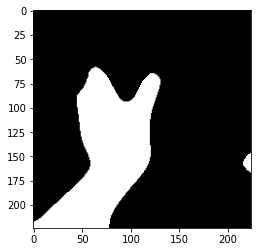

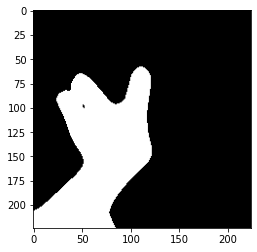

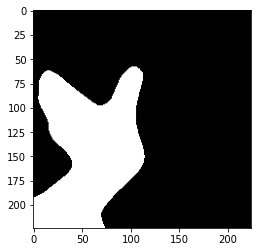

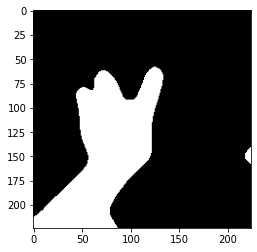

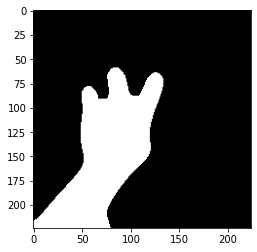

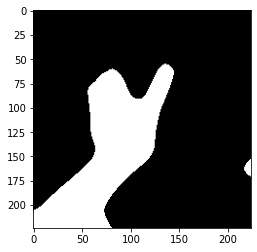

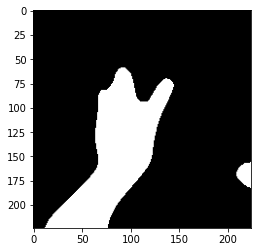

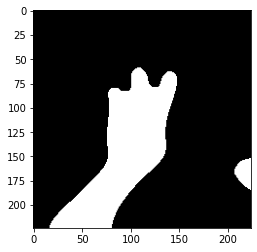

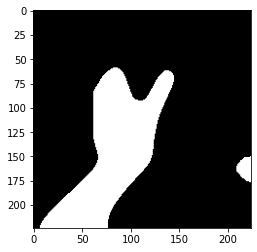

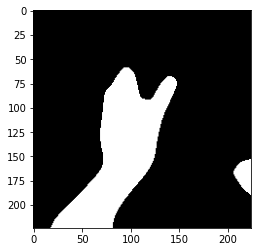

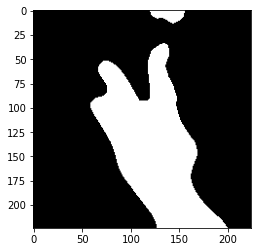

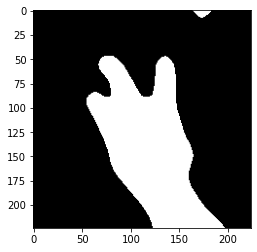

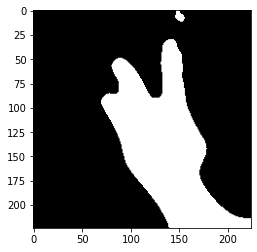

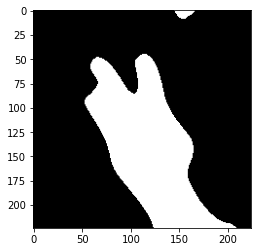

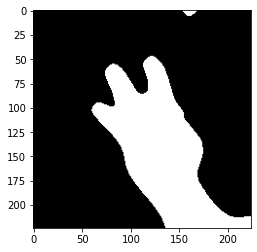

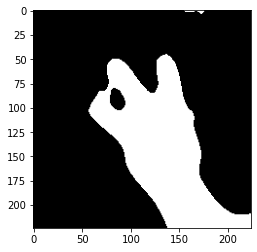

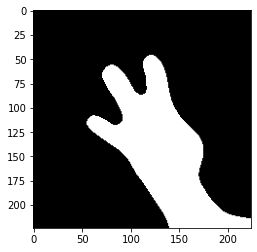

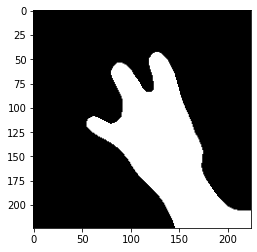

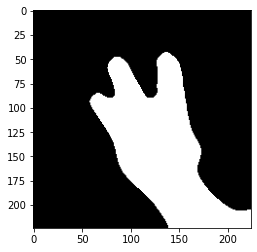

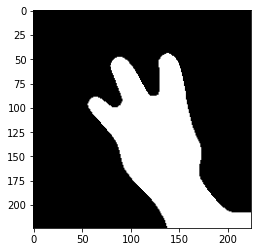

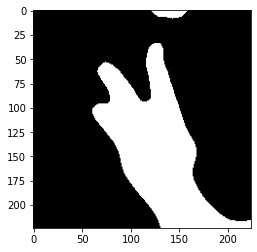

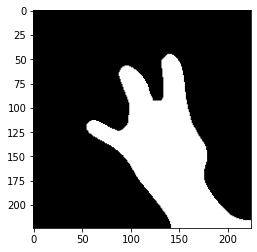

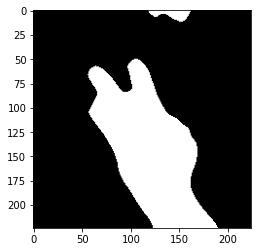

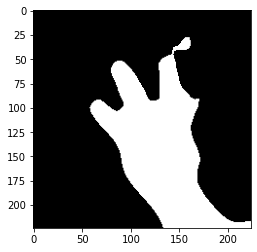

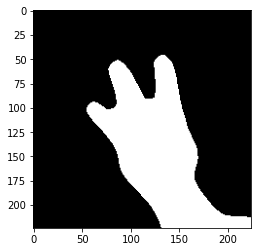

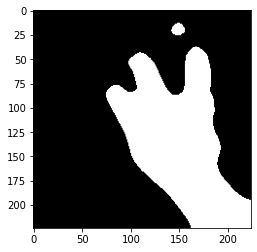

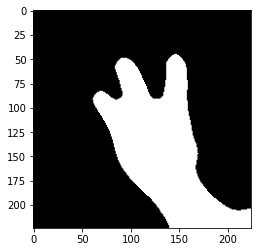

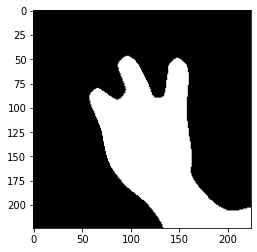

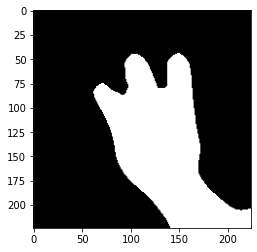

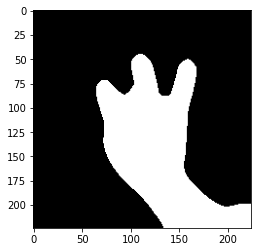

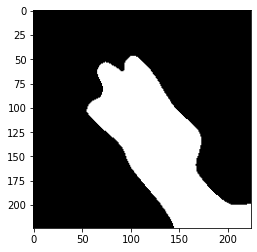

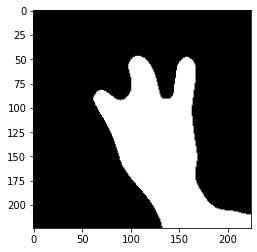

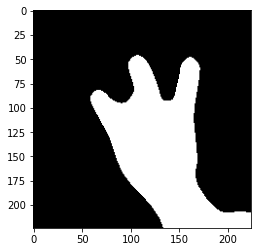

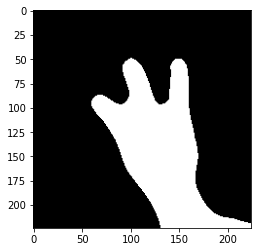

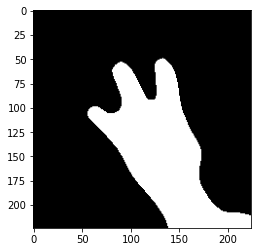

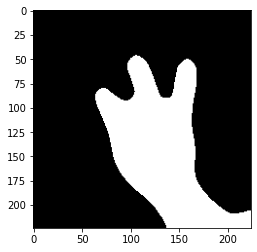

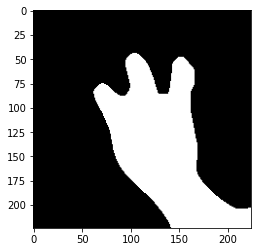

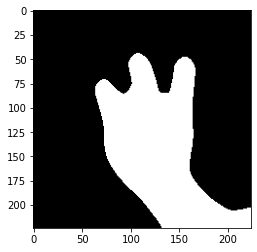

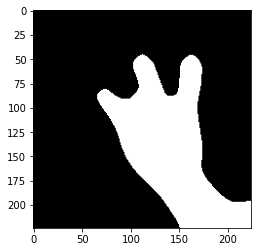

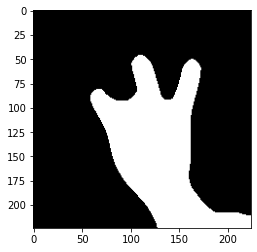

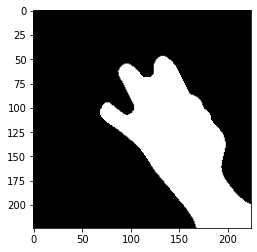

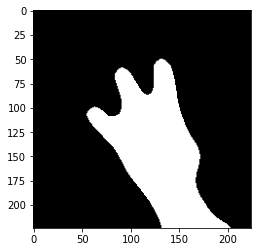

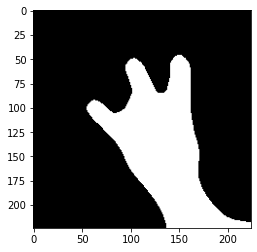

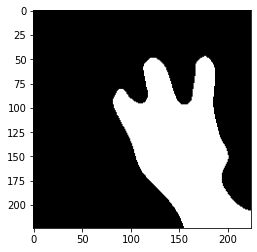

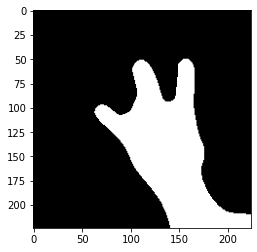

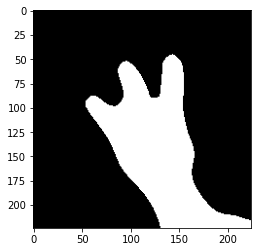

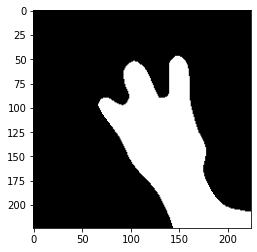

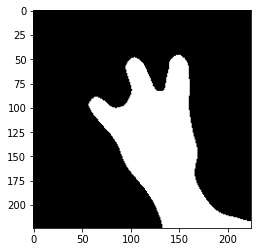

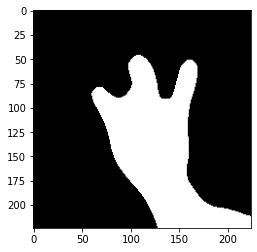

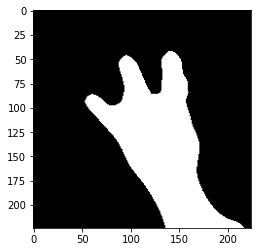

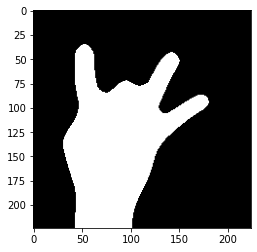

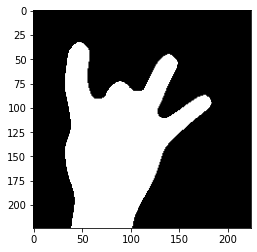

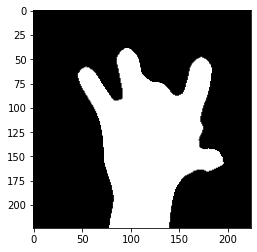

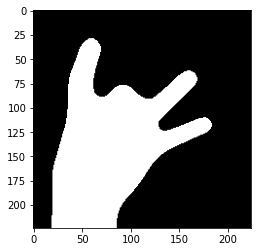

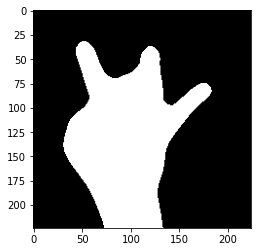

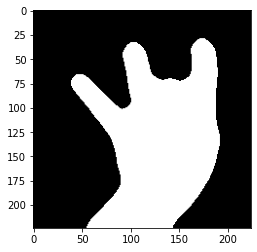

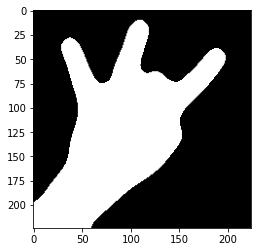

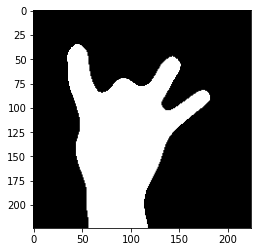

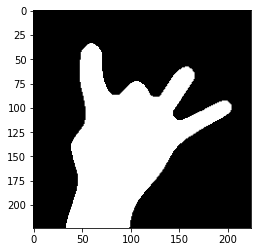

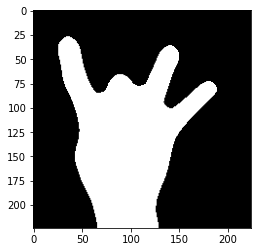

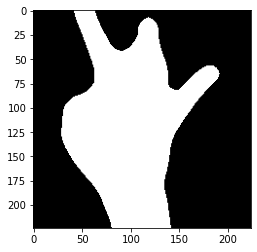

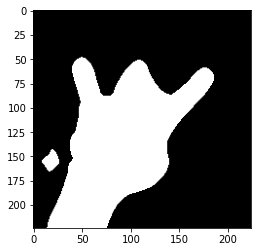

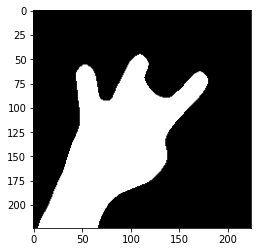

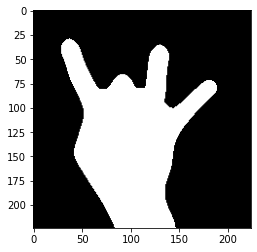

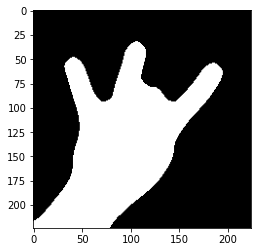

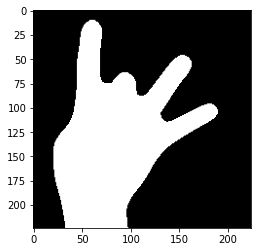

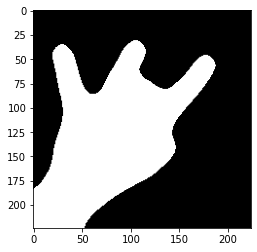

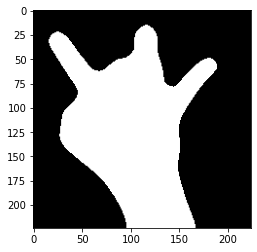

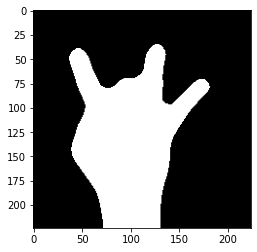

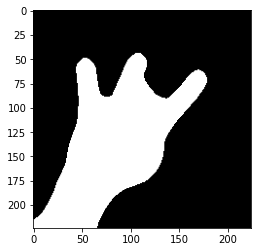

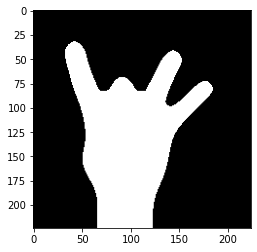

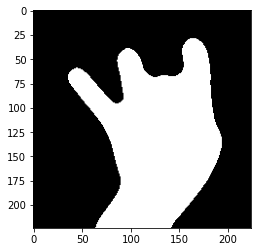

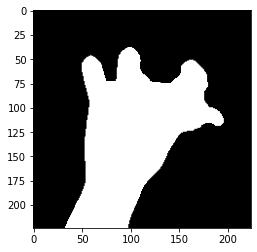

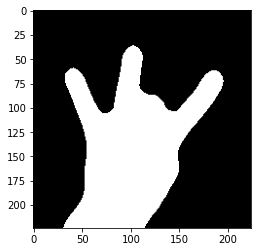

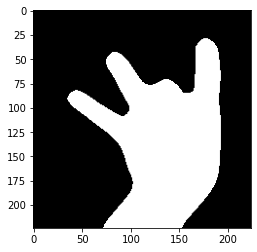

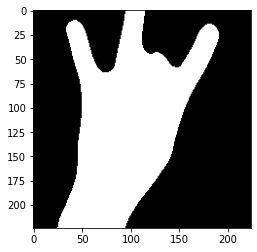

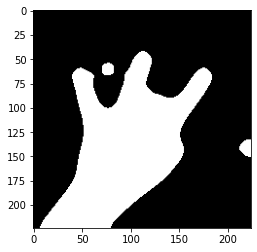

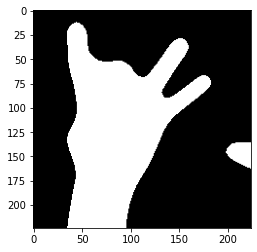

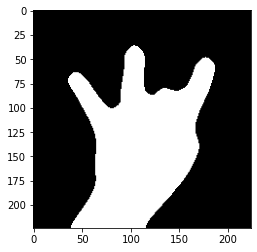

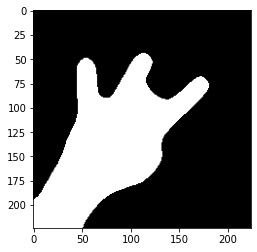

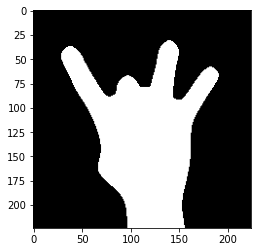

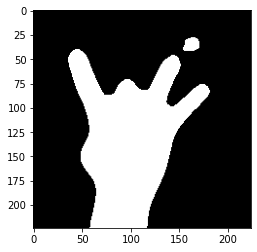

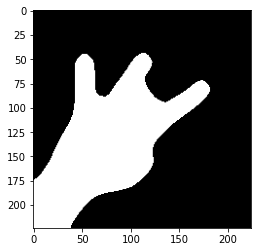

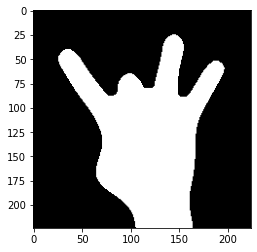

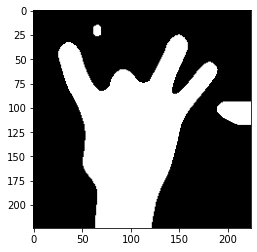

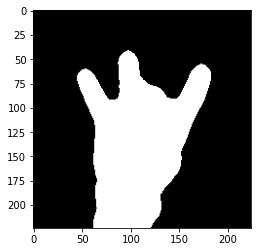

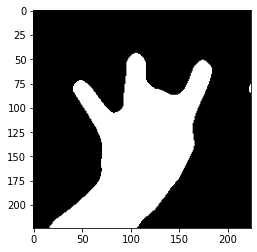

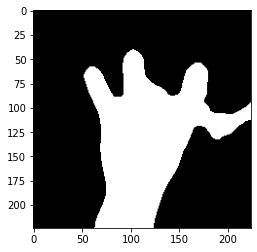

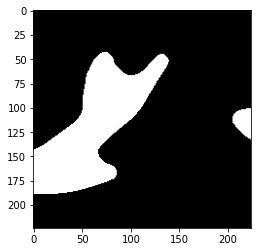

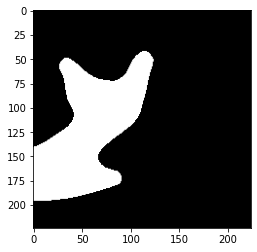

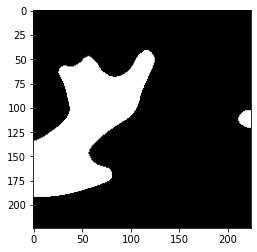

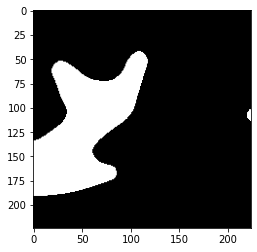

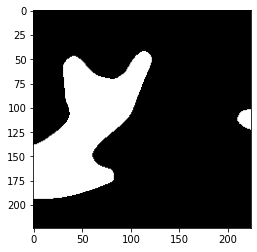

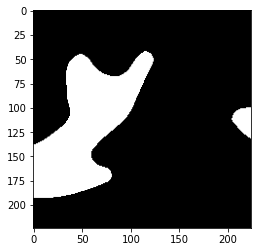

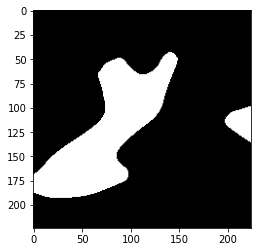

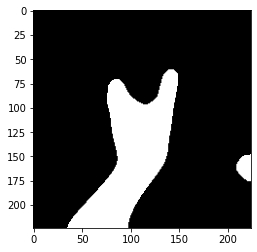

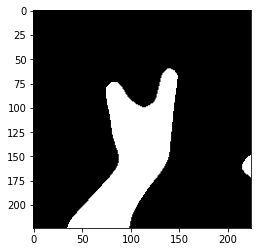

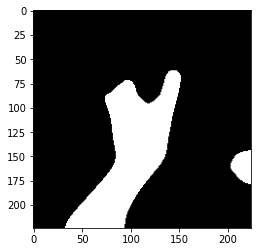

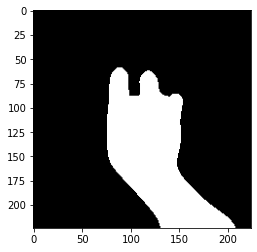

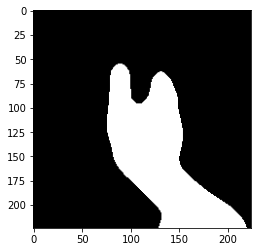

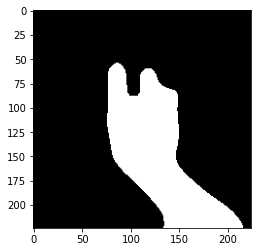

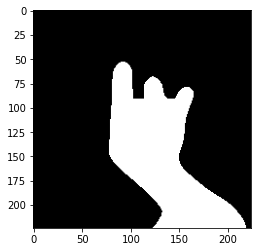

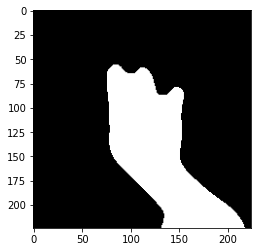

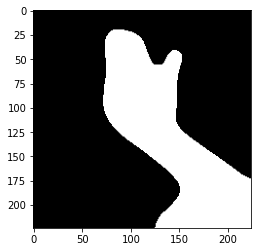

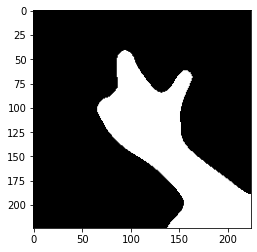

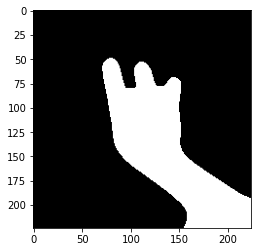

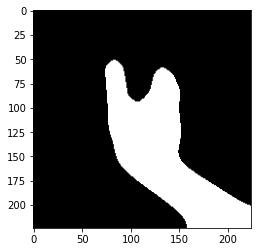

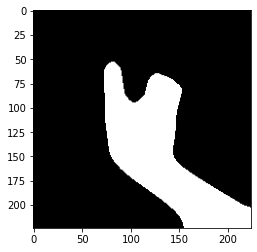

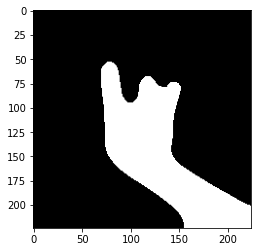

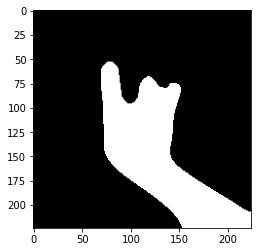

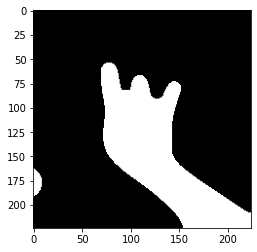

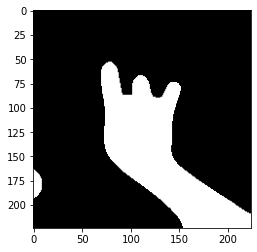

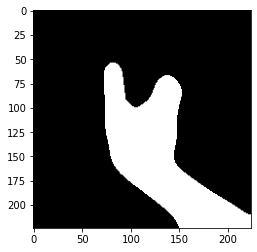

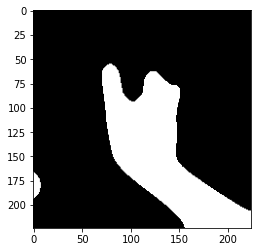

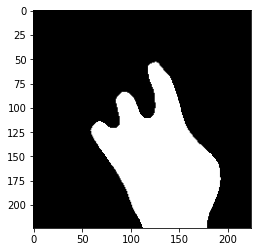

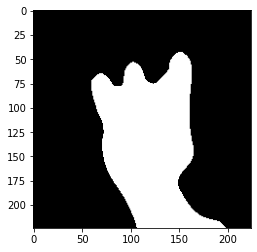

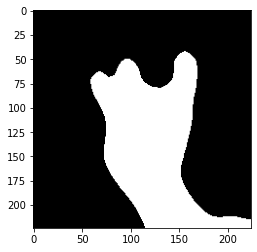

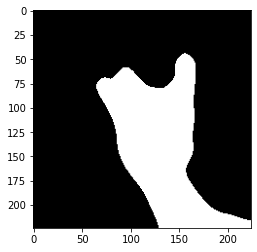

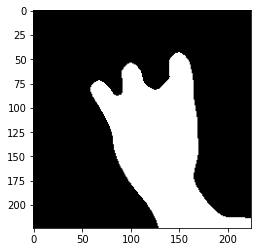

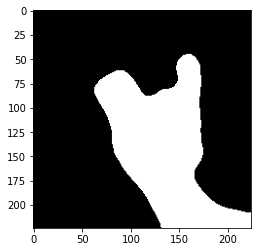

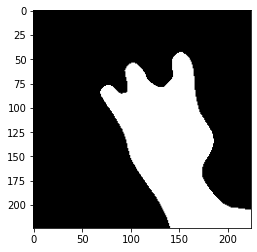

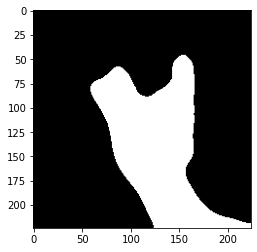

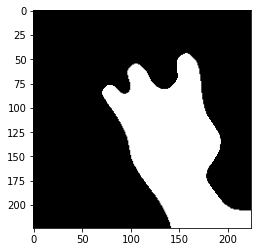

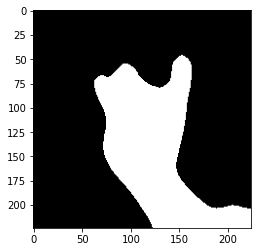

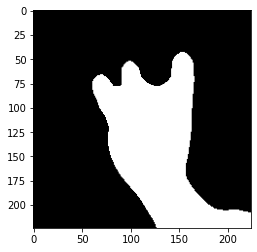

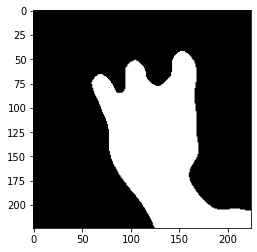

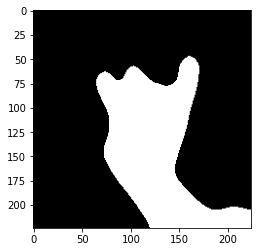

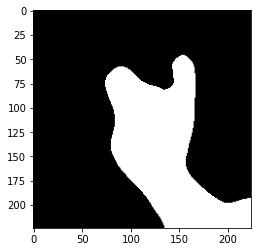

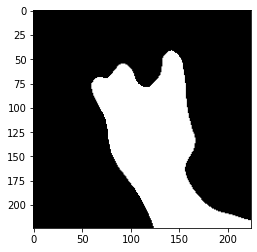

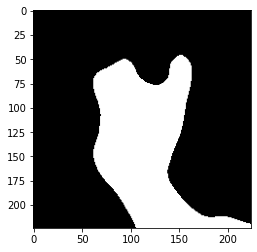

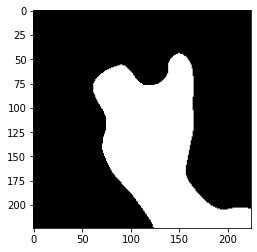

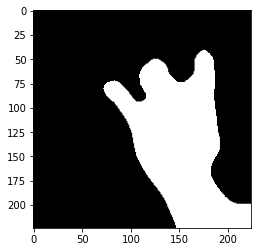

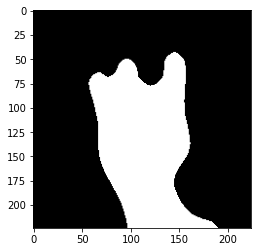

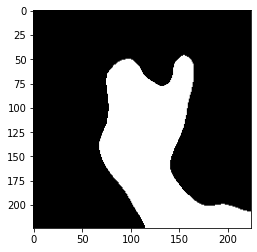

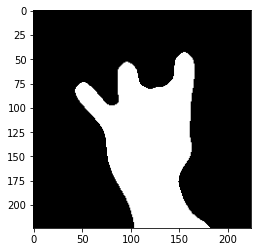

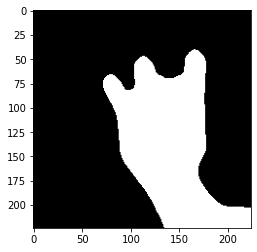

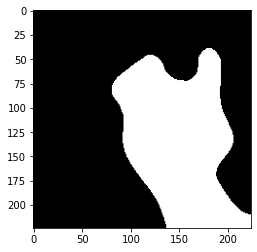

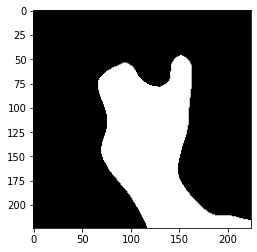

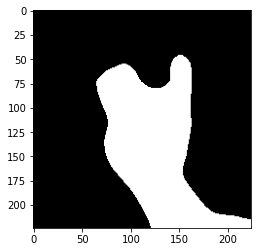

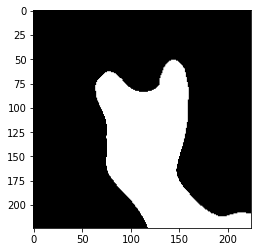

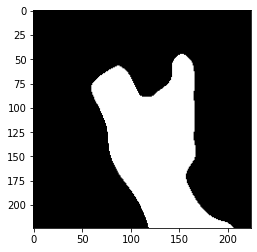

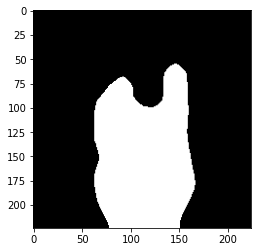

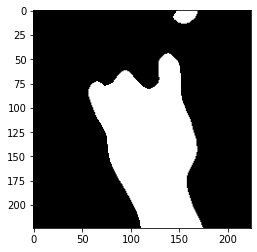

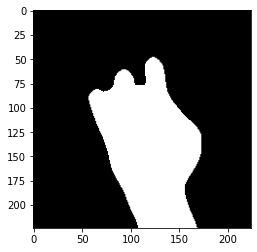

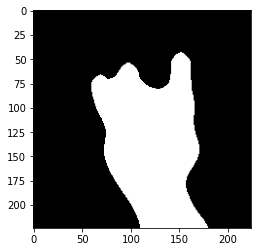

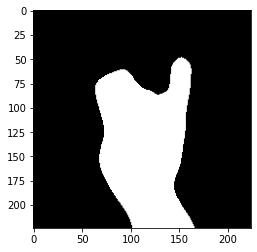

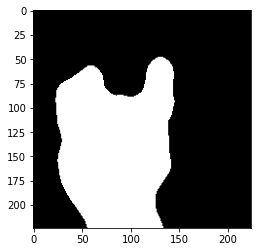

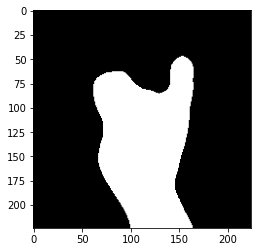

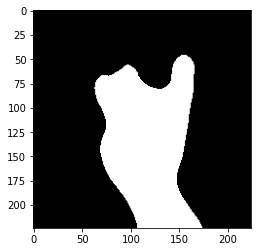

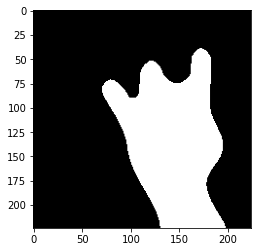

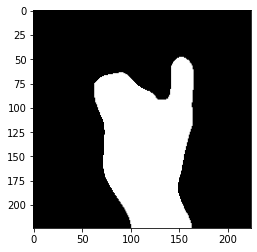

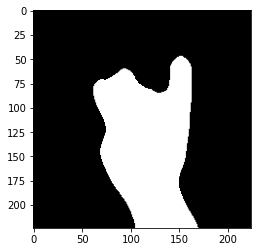

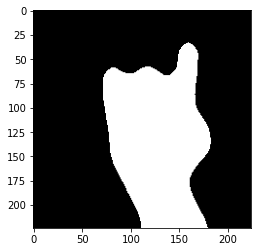

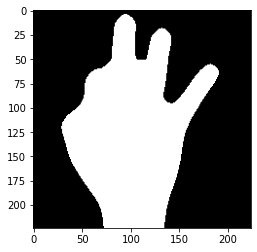

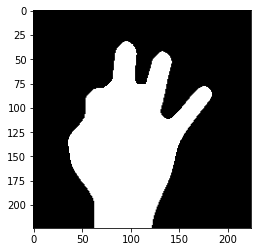

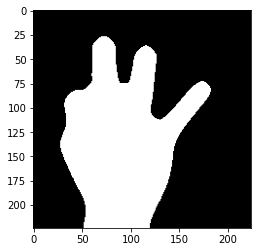

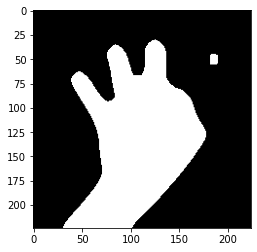

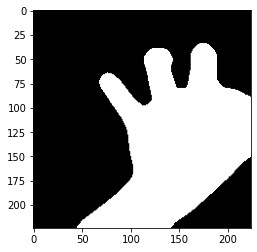

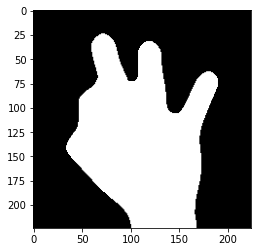

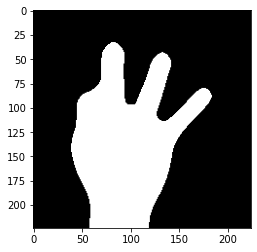

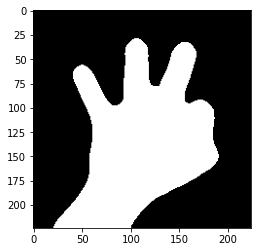

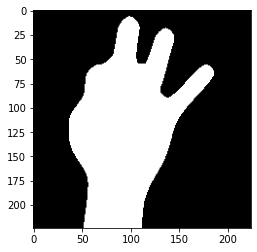

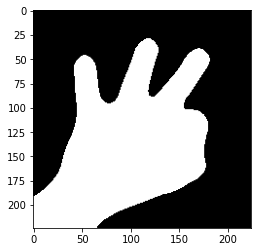

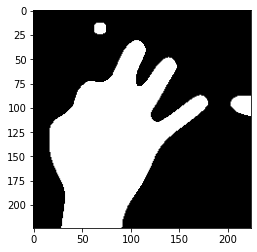

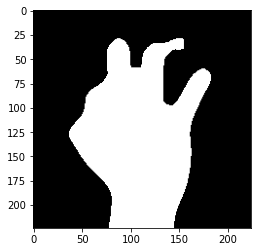

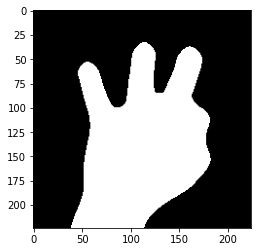

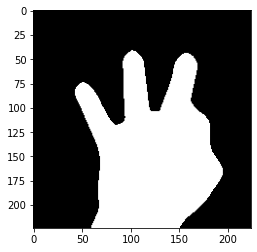

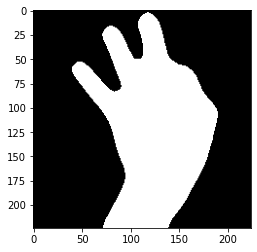

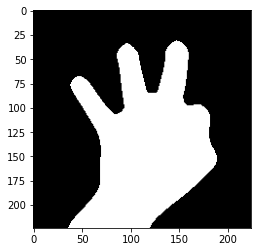

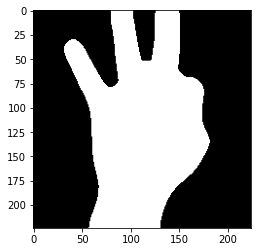

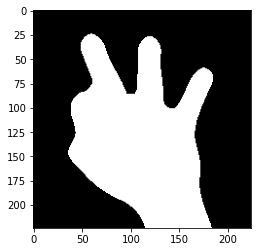

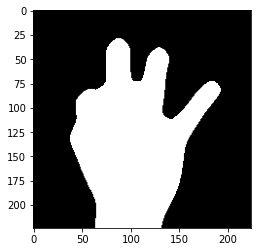

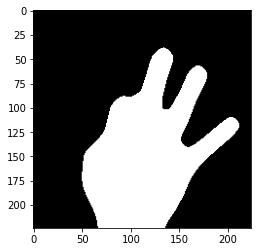

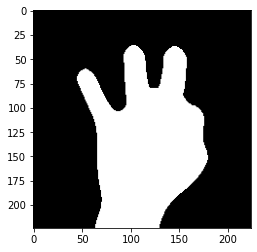

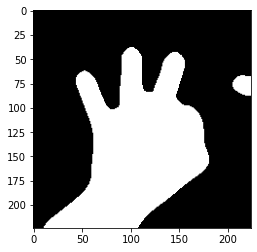

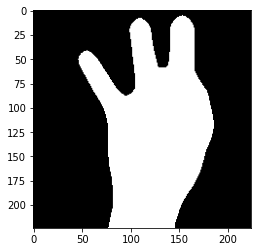

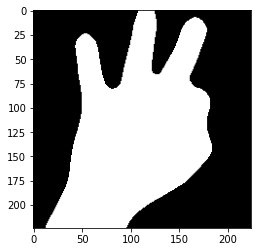

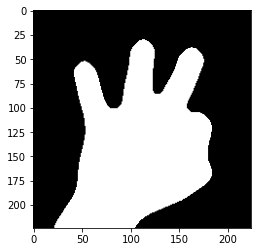

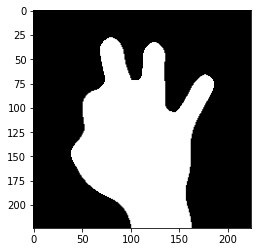

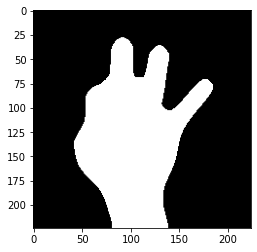

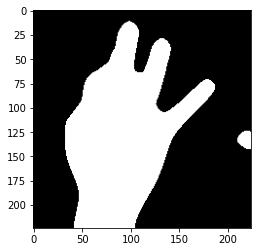

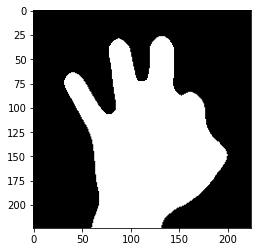

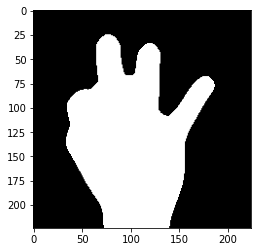

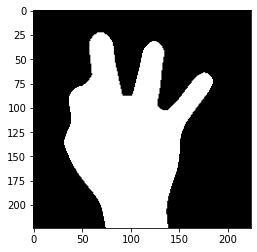

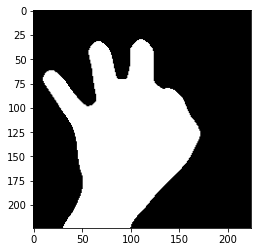

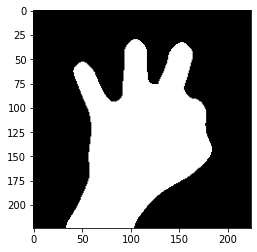

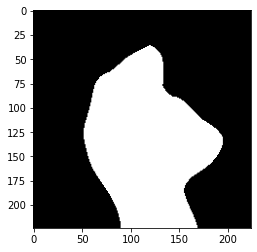

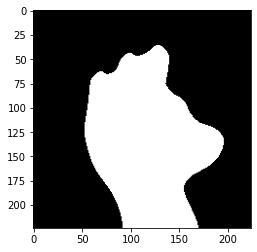

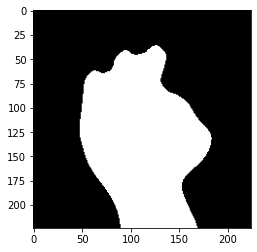

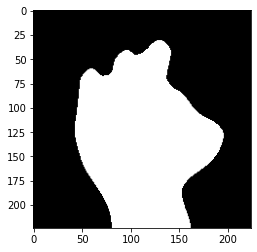

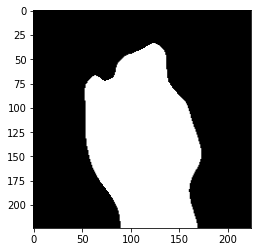

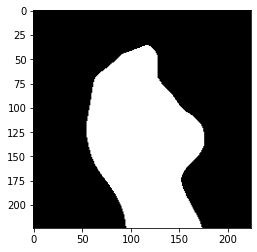

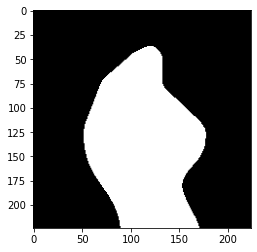

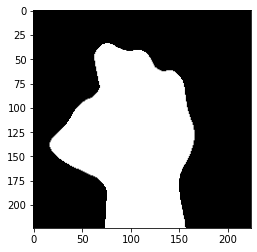

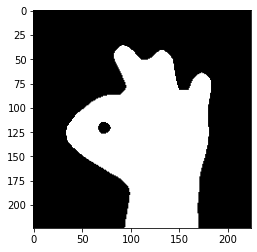

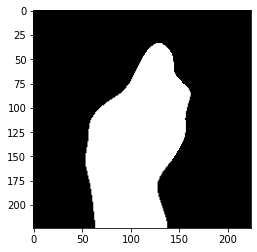

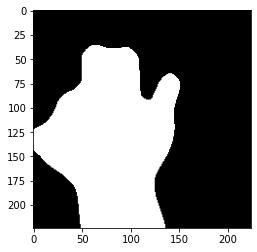

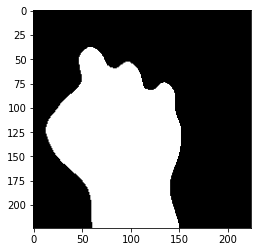

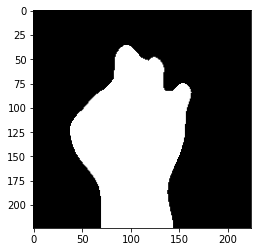

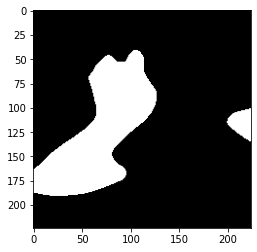

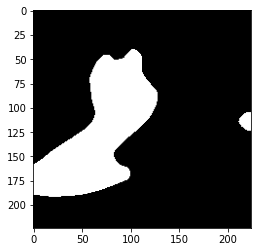

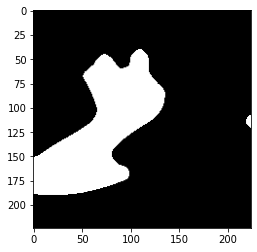

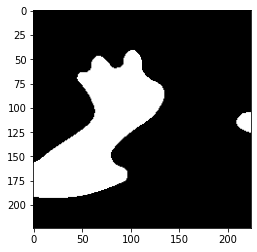

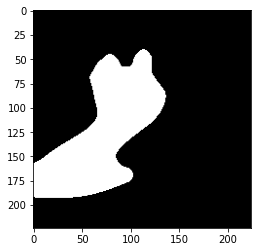

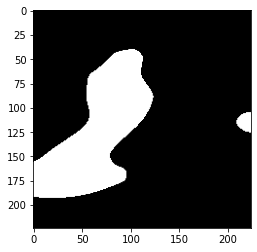

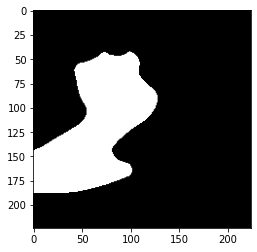

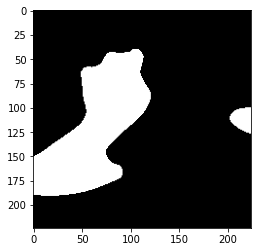

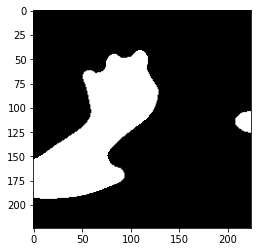

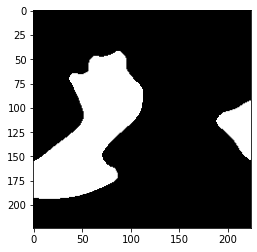

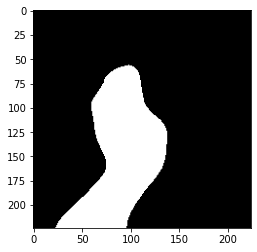

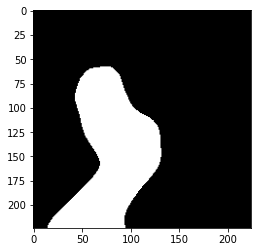

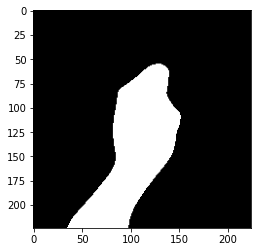

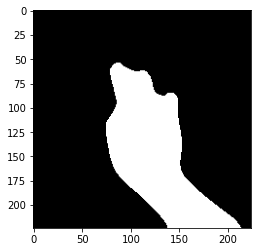

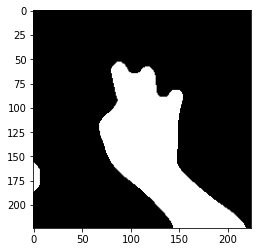

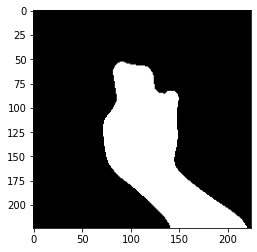

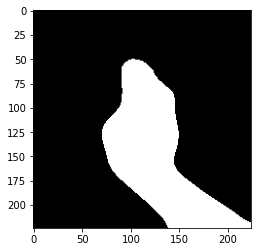

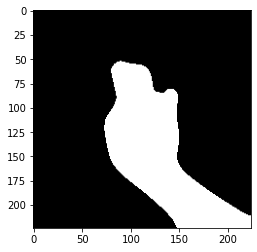

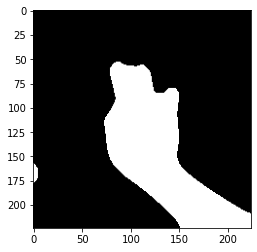

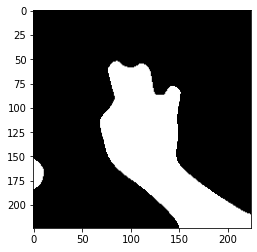

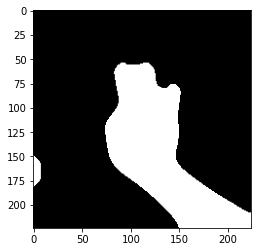

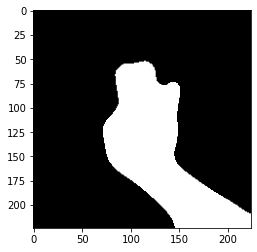

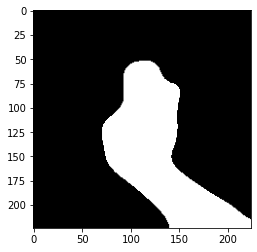

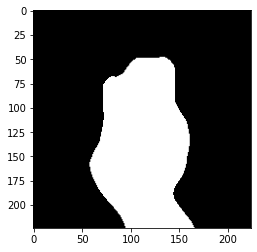

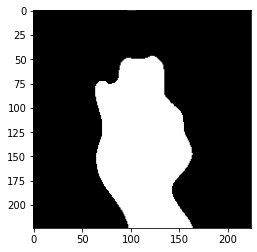

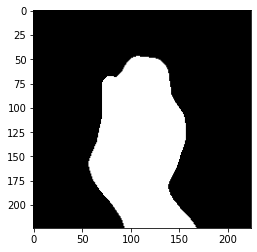

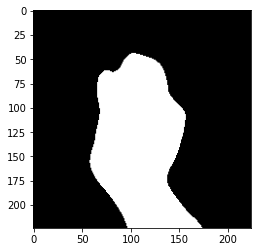

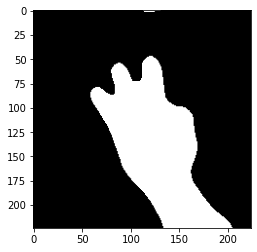

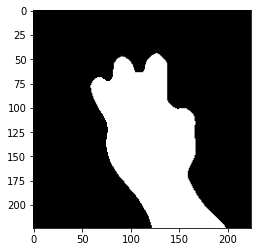

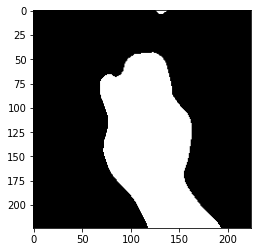

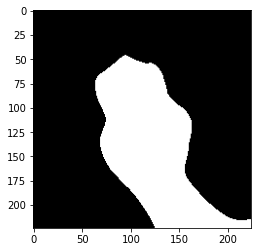

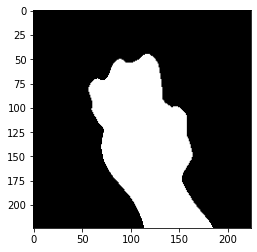

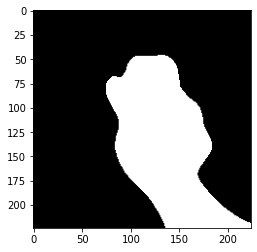

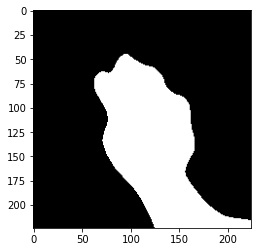

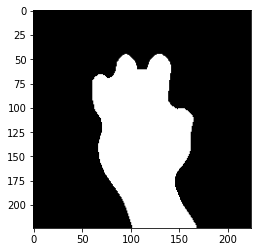

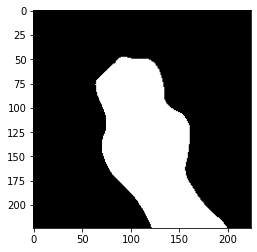

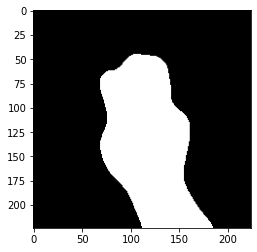

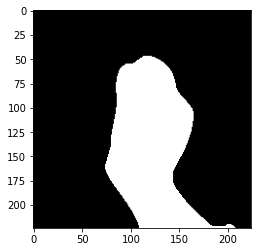

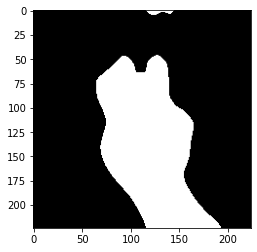

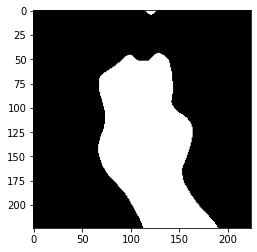

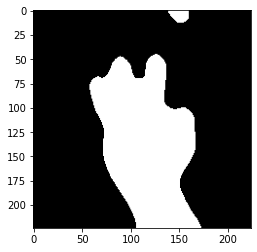

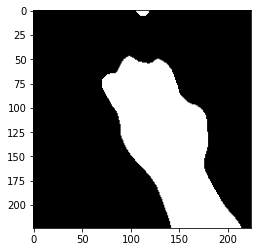

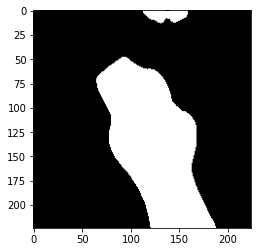

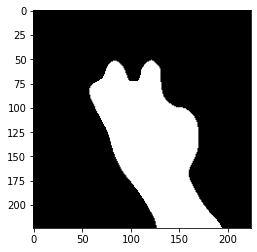

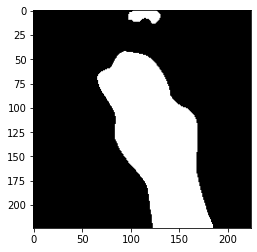

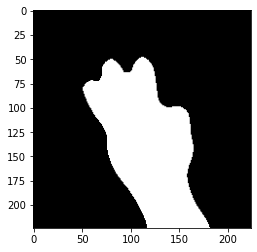

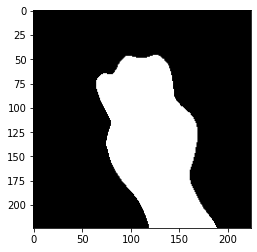

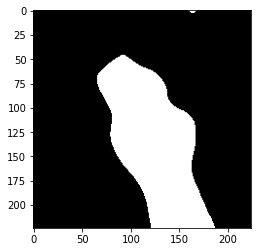

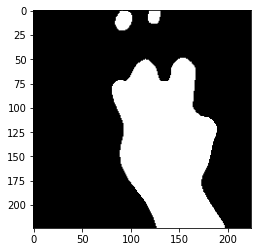

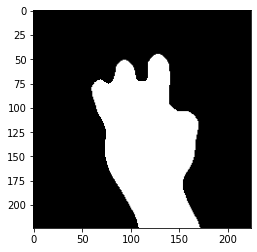

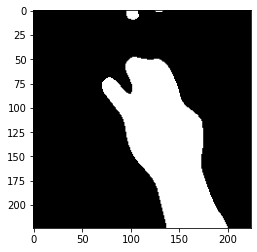

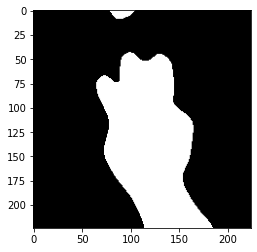

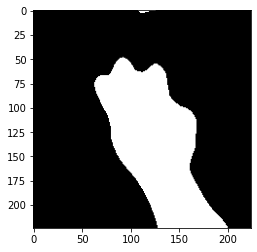

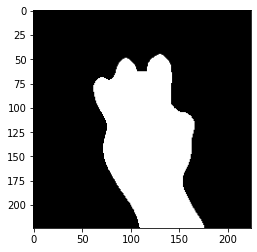

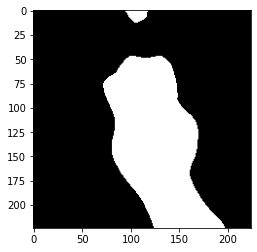

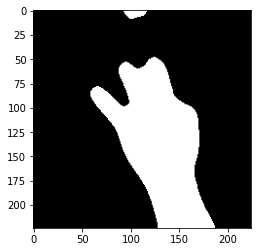

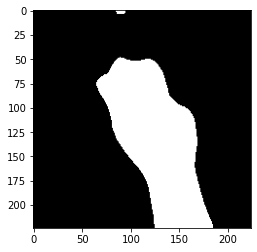

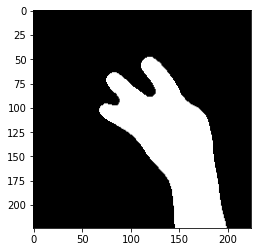

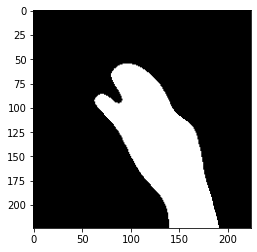

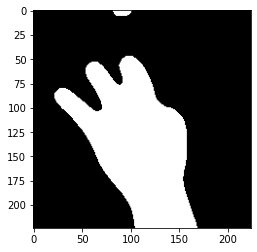

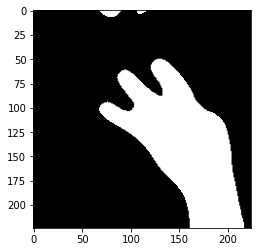

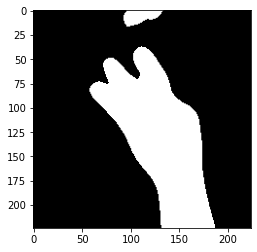

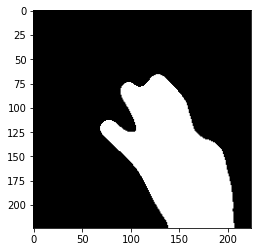

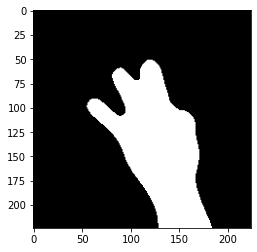

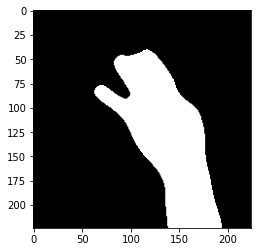

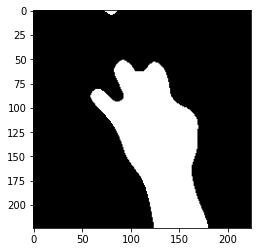

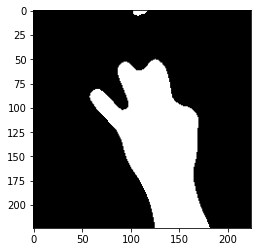

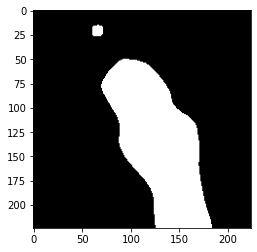

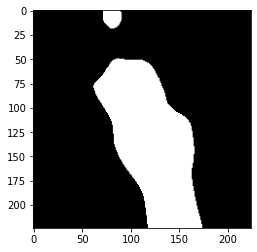

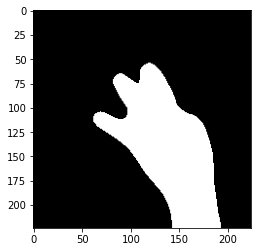

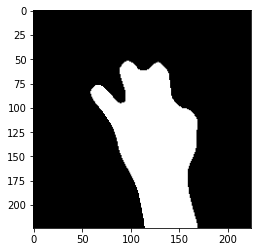

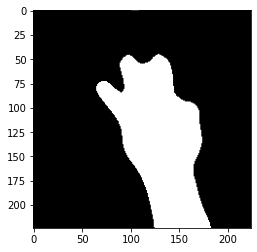

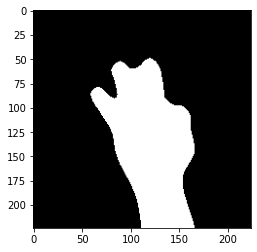

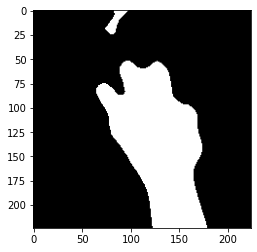

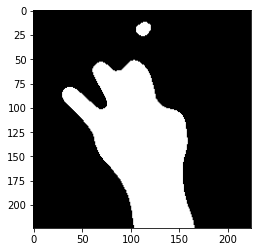

In [18]:
# Numbers
dataset_raw_numbers = os.path.join(dataset_raw, 'Numbers')
dataset_raw_preprocessed_number = os.path.join(dataset_preprocessed, 'Numbers')
for number in numbers:
  path_class = os.path.join(dataset_raw_numbers, number)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_number, number)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = number + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Static Single
dataset_raw_ss = os.path.join(dataset_raw, 'Static Single')
dataset_raw_preprocessed_ss = os.path.join(dataset_preprocessed, 'Static Single')
for sign in static_single:
  path_class = os.path.join(dataset_raw_ss, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_ss, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Static Double
dataset_raw_sd = os.path.join(dataset_raw, 'Static Double')
dataset_raw_preprocessed_sd = os.path.join(dataset_preprocessed, 'Static Double')
for sign in static_double:
  path_class = os.path.join(dataset_raw_sd, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_sd, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Dynamic Single
dataset_raw_ds = os.path.join(dataset_raw, 'Dynamic Single')
dataset_raw_preprocessed_ds = os.path.join(dataset_preprocessed, 'Dynamic Single')
for sign in dynamic_single:
  path_class = os.path.join(dataset_raw_ds, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_ds, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Dynamic Double
dataset_raw_dd = os.path.join(dataset_raw, 'Dynamic Double')
dataset_raw_preprocessed_dd = os.path.join(dataset_preprocessed, 'Dynamic Double')
for sign in dynamic_double:
  path_class = os.path.join(dataset_raw_dd, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_dd, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

# Verify folders
Count the total number of images in the experiment and raw dataset folders


## Raw Dataset Folder

In [13]:
# Letters
dataset_raw_letters = os.path.join(dataset_raw, 'Letters')
count_items(dataset_raw_letters, letters)

A 146
B 136
C 147
D 145
E 147
F 143
G 148
H 144
I 151
J 174
K 149
L 233
M 139
N 140
O 136
P 141
Q 136
R 137
S 152
T 137
U 141
V 139
W 141
X 155
Y 149
Z 0


In [20]:
# Numbers
dataset_raw_numbers = os.path.join(dataset_raw, 'Numbers')
count_items(dataset_raw_numbers, numbers)

1 119
2 114
3 112
4 107
5 102
6 111
7 108
8 109
9 127


In [21]:
# Static Single
dataset_raw_ss = os.path.join(dataset_raw, 'Static Single')
# pathss = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset/Static Single/FINE'
count_items(dataset_raw_ss, static_single)

Fine 66
Gabi 89
Good 97
Hapon 80
He-She 98
His-Her 78
I Love You 81
I-Me 84
Mine 97
Tanghali 99
Umaga 96
You 128
Your 98


In [22]:
# Static Double
dataset_raw_sd = os.path.join(dataset_raw, 'Static Double')
count_items(dataset_raw_sd, static_double)

Congratulations 72
Great 134
Help 92
Meet 112
Name 106
Night 98
Occupation 87
Pray 88
Rest 104
Stand 106
Study 108
To 80


In [23]:
# Dynamic Single
dataset_raw_ds = os.path.join(dataset_raw, 'Dynamic Single')
count_items(dataset_raw_ds, dynamic_single)

Invite 241
No 249


FileNotFoundError: ignored

In [ ]:
# Dynamic Double
dataset_raw_dd = os.path.join(dataset_raw, 'Dynamic Double')
count_items(dataset_raw_dd, dynamic_double)

## Dataset Preprocessed Folder

In [ ]:
# Letters
dataset_raw_preprocessed_letters = os.path.join(dataset_preprocessed, 'Letters')
count_items(dataset_raw_preprocessed_letters, letters)

A 139
B 131
C 127
D 138
E 140
F 137
G 139
H 123
I 136
J 138
K 142
L 222
M 131
N 130
O 130
P 128
Q 125
R 128
S 145
T 129
U 134
V 131
W 132
X 144
Y 141
Z 0


In [19]:
# Numbers
dataset_raw_preprocessed_number = os.path.join(dataset_preprocessed, 'Numbers')
count_items(dataset_raw_preprocessed_number, numbers)

1 115
2 105
3 106
4 98
5 97
6 103
7 105
8 103
9 121


In [ ]:
# Static Single
dataset_raw_preprocessed_ss = os.path.join(dataset_preprocessed, 'Static Single')
count_items(dataset_raw_preprocessed_ss, static_single)

In [ ]:
# Static Double
dataset_raw_preprocessed_sd = os.path.join(dataset_preprocessed, 'Static Double')
count_items(dataset_raw_preprocessed_sd, static_double)

In [ ]:
# Dynamic Single
dataset_raw_preprocessed_ds = os.path.join(dataset_preprocessed, 'Dynamic Static')
count_items(dataset_raw_preprocessed_ds, dynamic_single

In [ ]:
# Dynamic Double
dataset_raw_preprocessed_dd = os.path.join(dataset_preprocessed, 'Dynamic Double')
count_items(dataset_raw_preprocessed_dd, dynamic_double)